 # Simulation based on the Dataset of the ACN in 2019 using OpenDSS

## 1. Lines' properties estimation

There are five levels of current in the ACN infrastructure, that's why five types of lines are required.

The properties needed for OpenDSS in order to perform the simulation are:
- DIAM: diameter
- RAC: resistance in alternatif current
- Runits: unit of resistance in alternatif current (ft, m, etc per Ohm)
- radunits: unit of the diameter
- Normamps: normal ampicity

From the level of the current and the length of each type of line, we will use an online calculator to know these properties.

The online calculator is available in here: https://www.jcalc.net/cable-sizing-calculator-as3008

### 1.1. Properties of type 1 lines

Amps = 260 A\
Length = 10 m

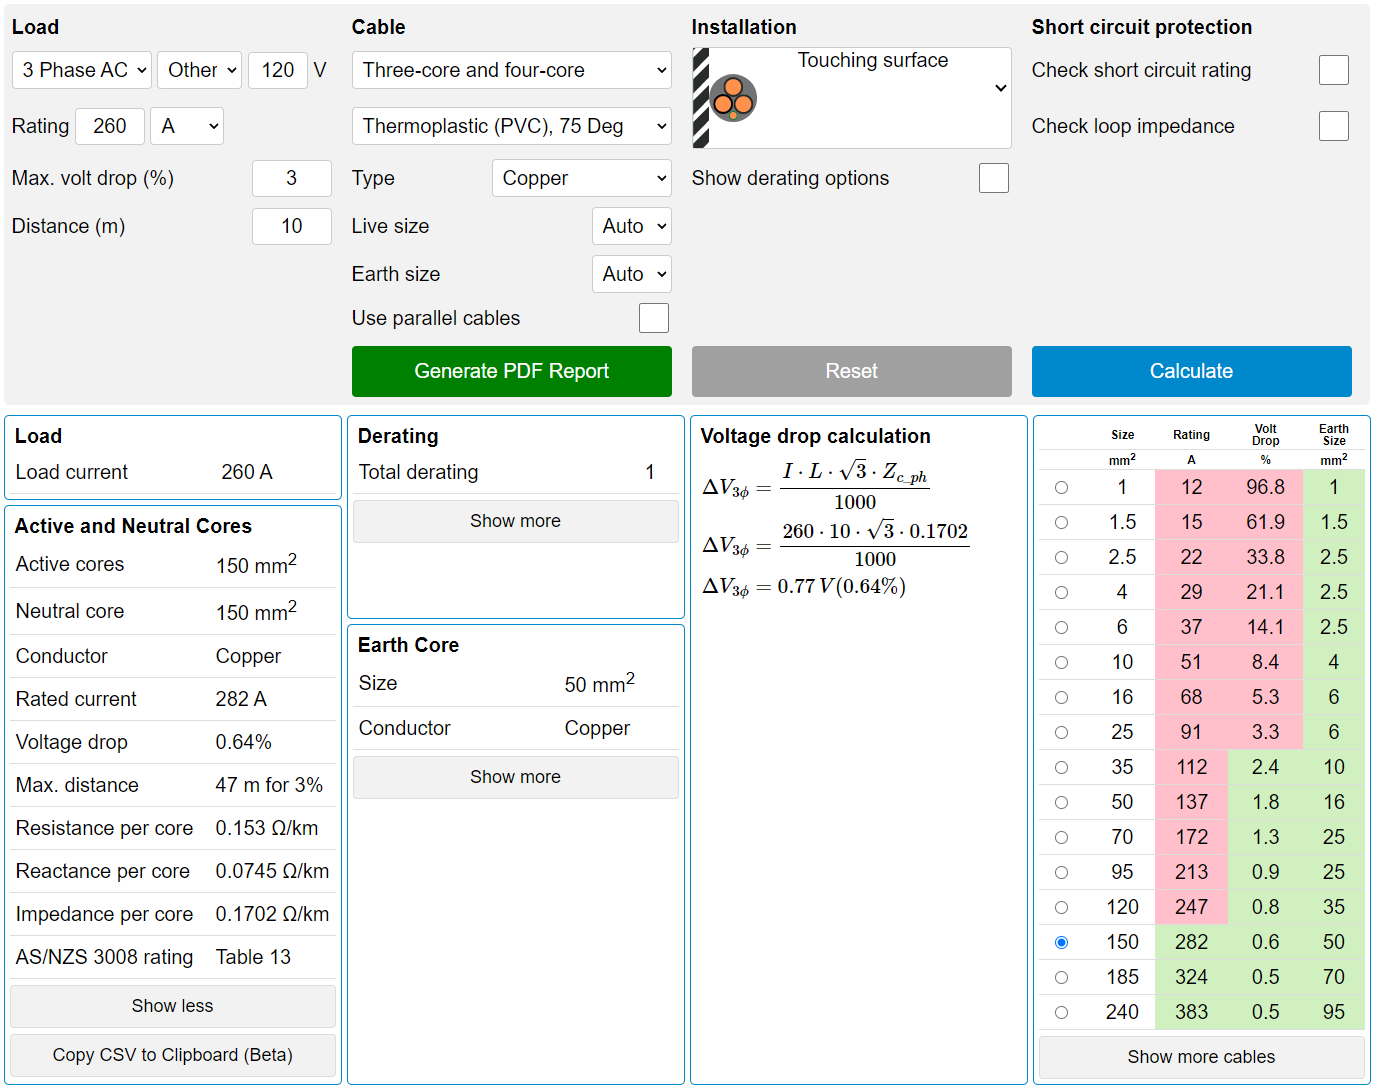

In [164]:
A = 150
d = 2 * math.sqrt(A / math.pi) / 10
print("DIAM =", f"{d:0.3}", "cm")

DIAM = 1.38 cm


### 1.2. Properties of type 2 lines

Amps = 130 A\
Length = 5 m

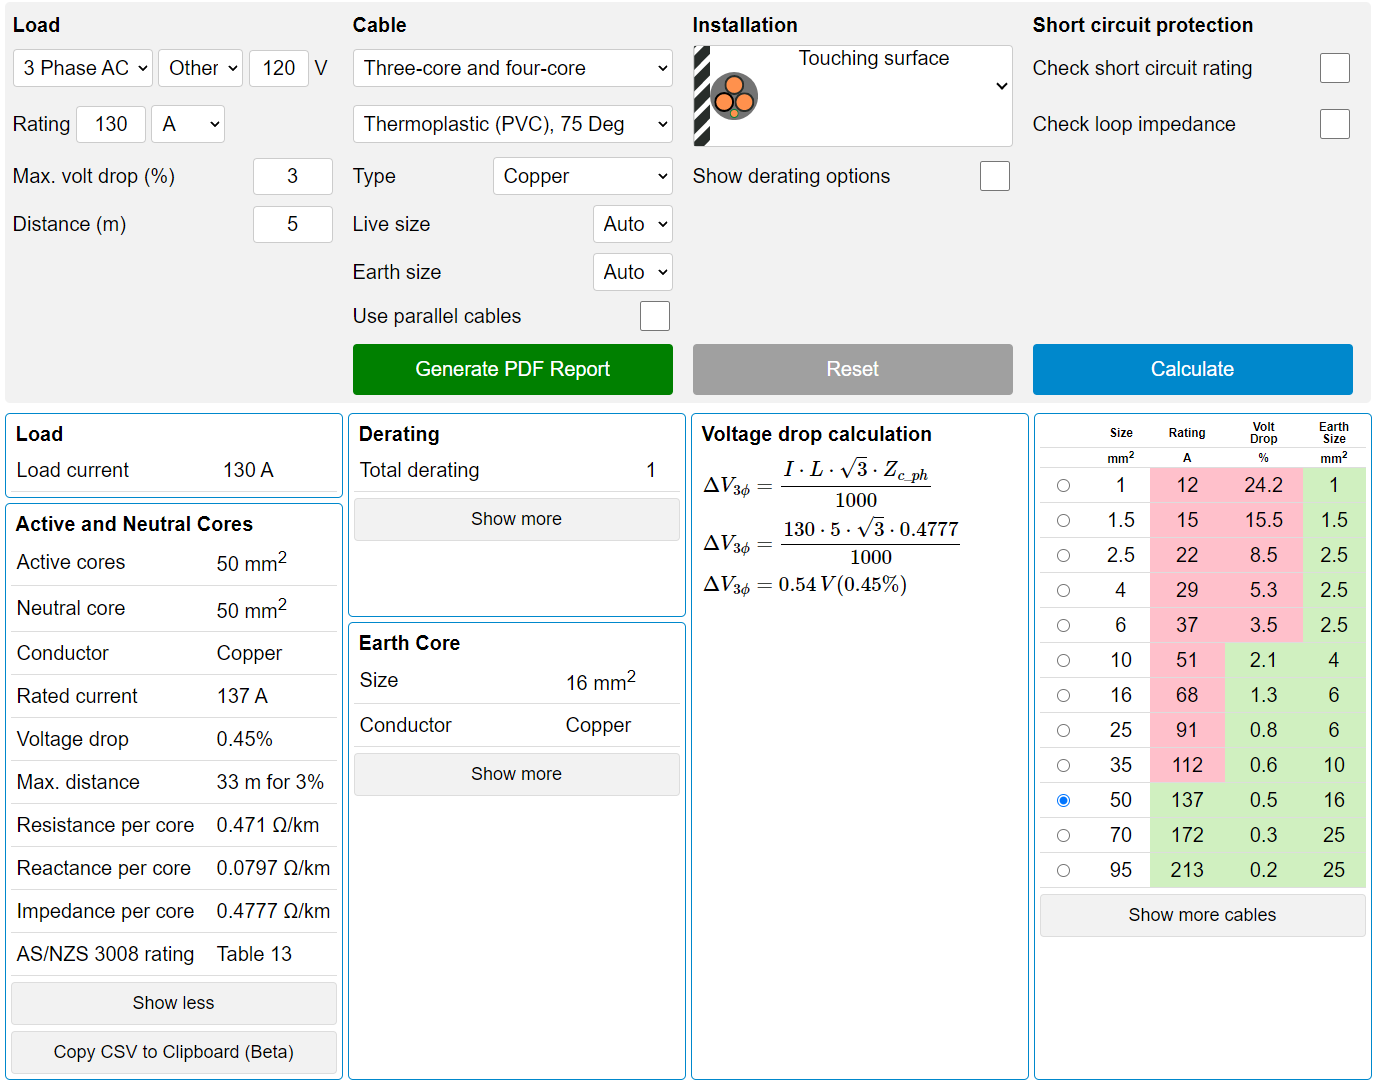

In [165]:
A = 50
d = 2 * math.sqrt(A / math.pi) / 10
print("DIAM =", f"{d:0.3}", "cm")

DIAM = 0.798 cm


### 1.3. Properties of type 3 lines 

Amps = 80 A\
Length = 10 m

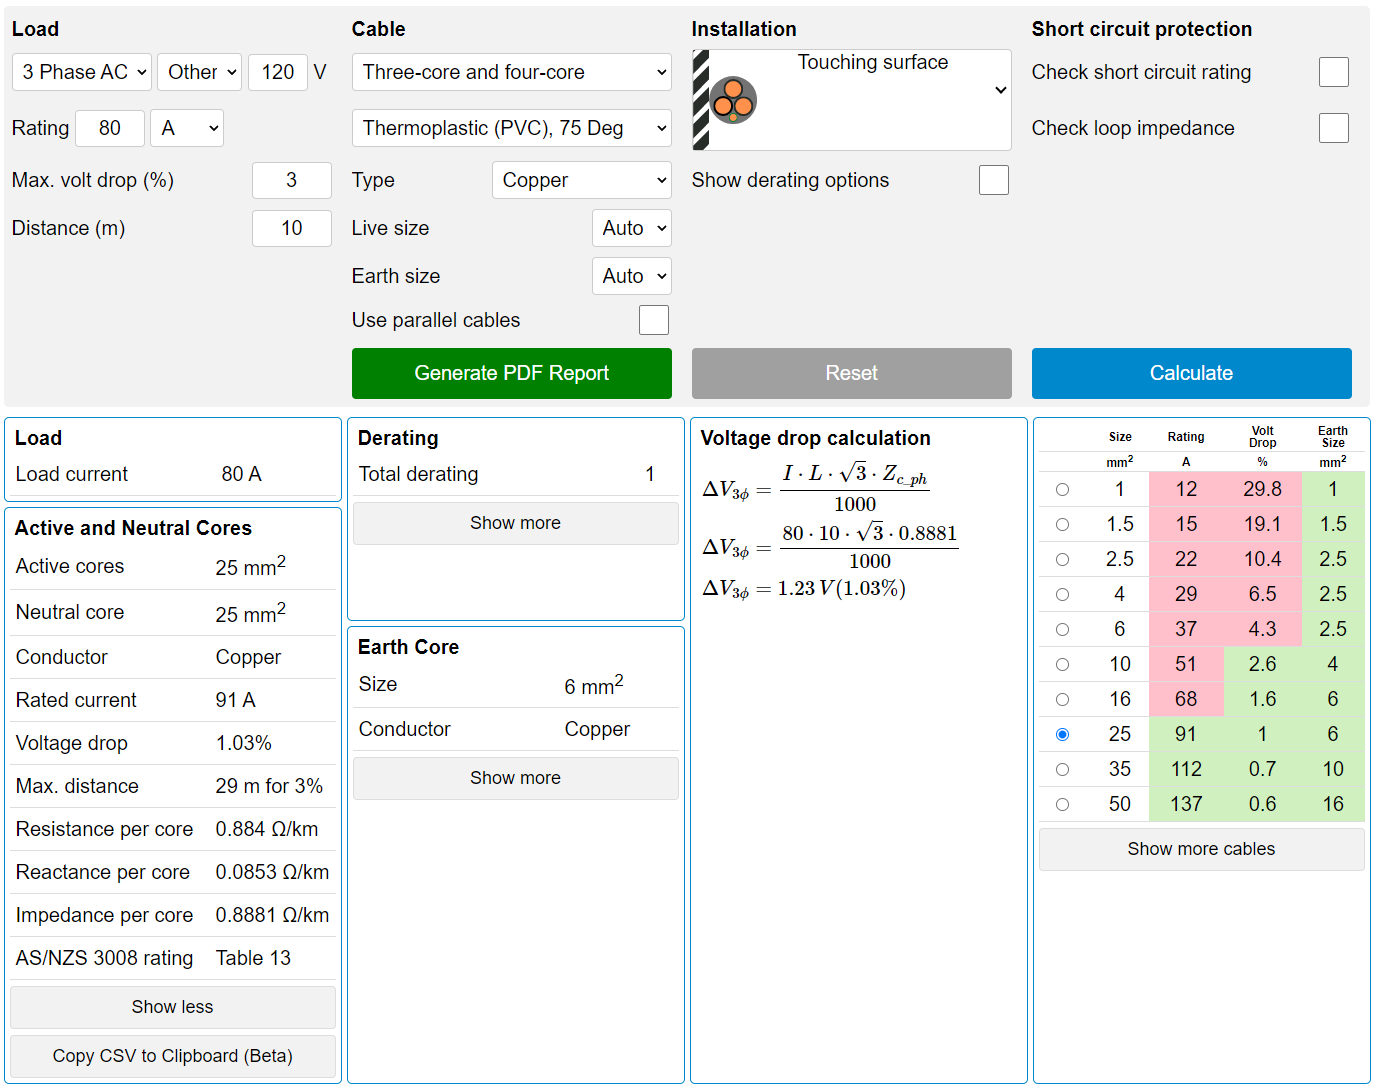

In [166]:
A = 25
d = 2 * math.sqrt(A / math.pi) / 10
print("DIAM =", f"{d:0.3}", "cm")

DIAM = 0.564 cm


### 1.4. Properties of type 4 lines 

Amps = 65 A\
Length = 5 m

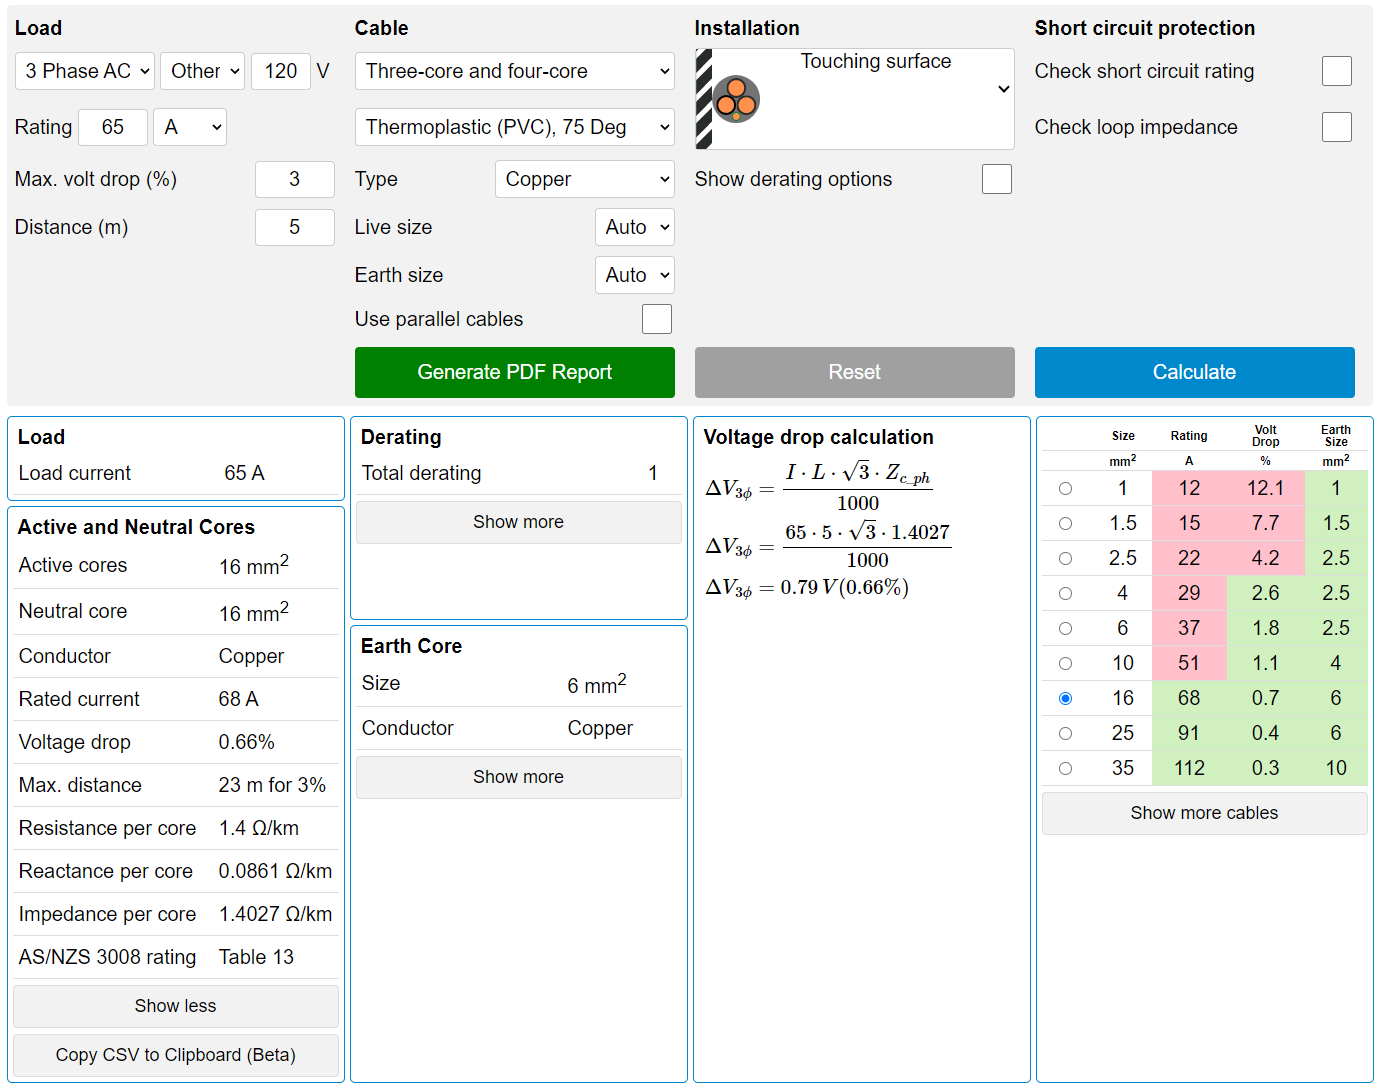

In [167]:
A = 16
d = 2 * math.sqrt(A / math.pi) / 10
print("DIAM =", f"{d:0.3}", "cm")

DIAM = 0.451 cm


### 1.5. Properties of type 5 lines

Amps = 55.4 A\
Length = 0.5 m

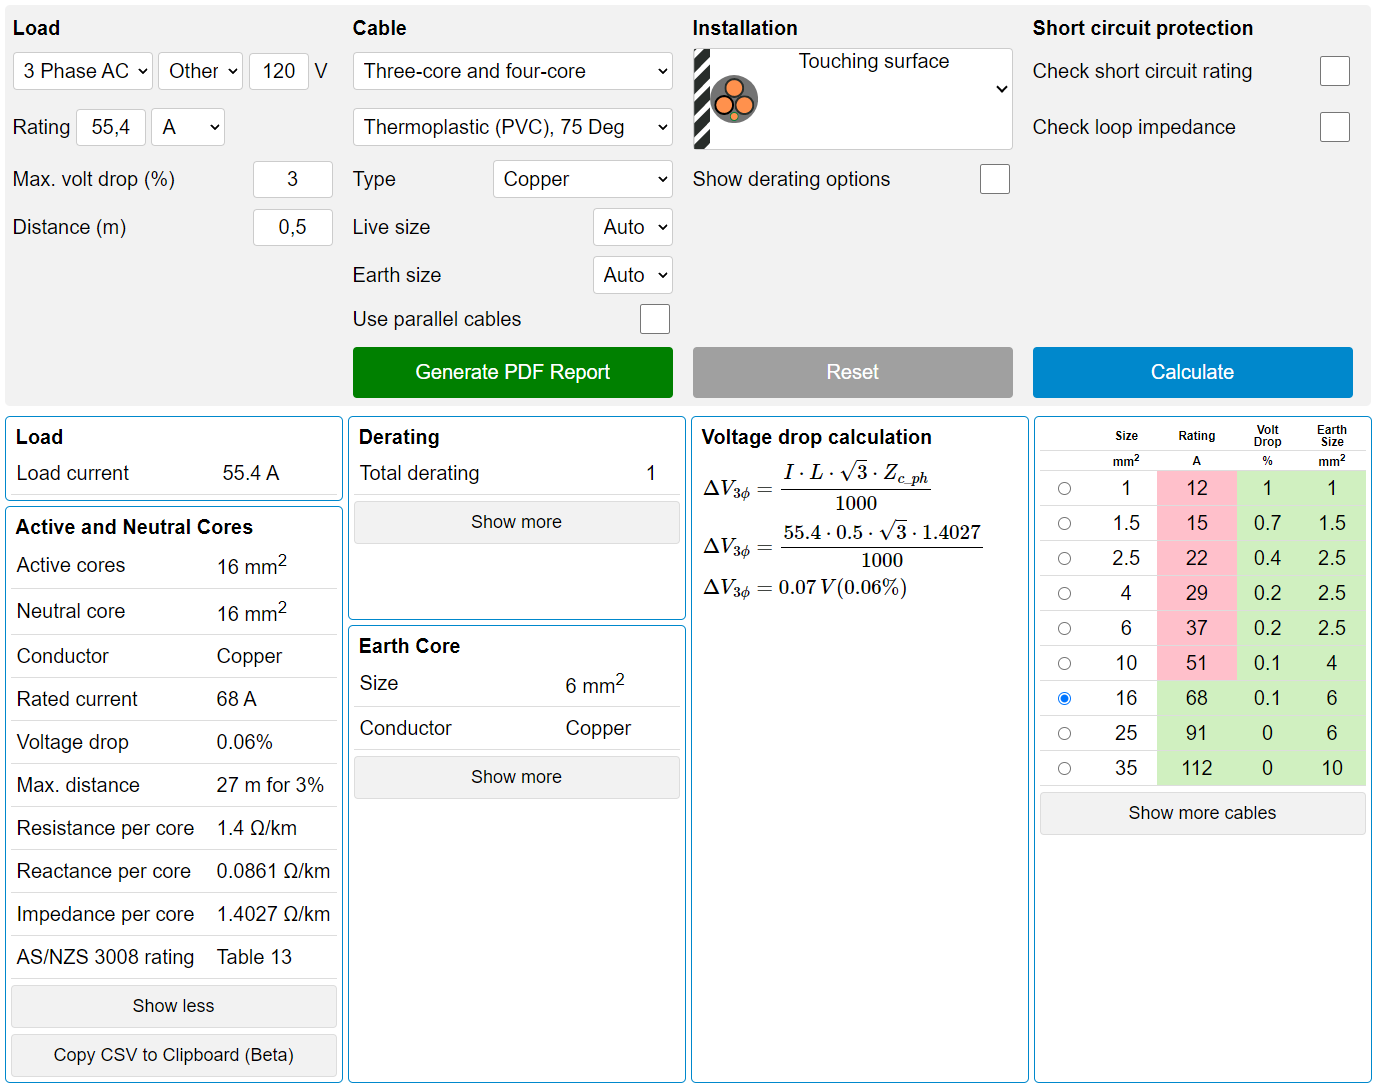

In [168]:
A = 16
d = 2 * math.sqrt(A / math.pi) / 10
print("DIAM =", f"{d:0.3}", "cm")

DIAM = 0.451 cm


## 2. Simulation

### 2.1 Importing the necessary libraries

In [1]:
import win32com.client
dssObj = win32com.client.Dispatch("OpenDSSEngine.DSS")
dssText = dssObj.Text
dssCircuit = dssObj.ActiveCircuit
dssSolution = dssCircuit.Solution
dssElem = dssCircuit.ActiveCktElement
dssBus = dssCircuit.ActiveBus
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import datetime as dt
import math
import cmath
import numpy as np

### 2.2 Compile the Master.DSS file for one time to activate Python interfacing 

In [2]:
dssText.Command = "compile 'C:/Users/lazhe/OneDrive/Thesis/OpenDSS/OpenDSS_simulations/1_Yearly_simulation_with_lines_losses/Master.DSS'"

### 2.3 Loading the Dataset to a dicionary called "data"

In [3]:
file_list = os.listdir("Dataset")
data = {}
for file in file_list:
    data[file[3:9].lower()] = pd.read_csv("Dataset/" + file)#"file[3:9].lower()" is used here to exract from the file name the name of the charging station

### 2.4 Running the simulation 

The simulation is done with a 10 minutes timestamp for the whole year of 2019, so the total number of simulation number is 52560 points.

P.S. 1: The OpenDSS simulatin using Python interfacing is a bit different than using only OpenDSS. Using only OpenDSS, the whole Dataset is fed to OpenDSS and we set the mode to yearly simulation and fix the timestamp and the total number of the time serie. In the case of Python interfacing, OpenDSS is called by a Python script to run a "Snap mode" simulation (simulation of a fixed values of the load power), then we change the values of the load power each timestamp depending on the Dataset. That's why the is a main loop that iterate over the Dataset to change the values and run a "Snap mode" simulation with OpenDSS every timestamp.

P.S. 2: You can skip the simulation and play around directly with the results, because they are already saved in a csv file and the simulation takes around 55 minutes (in my computer) to be done.

In [4]:
b = dt.datetime.now()                                                      #Get the begin time of the simulation to calculate the simulation time later
result = pd.DataFrame()                                                    #Initialize the result DataFrame 
losses = pd.DataFrame()                                                    #Initialize the losses DataFrame
voltages = pd.DataFrame()                                                  #Initialize the voltages DataFrame 
n_sim_pt = data["ca-148"].shape[0]                                         #Number of simulation points
for i in range(n_sim_pt):                                                  #The main for loop that iterate over the total simulation point
    print("simulation point number:", i)                                  #Print the simulation point number
    for station in data:                                                   #for loop that that iterates over the  stations
        station_kW = str(float(data[station].iloc[i,0]) * 0.001)           #Convert the power from W to kW
        dssText.Command = 'Edit "Load.' + station + '" kW=' + station_kW   #Change the power of the station "station" to its new value "station_kW"
    dssSolution.Solve()                                                    #Run a Snap mode simulation
    dssText.Command = 'Export p_byphase'                                   #Export the powers per phase to a csv file to be used later
    dssText.Command = 'Export losses'                                      #Export lines losses to a csv file to be used later
    dssText.Command = 'Export ElemVoltages'
    f = pd.read_csv("ACN_Infrastructure_EXP_P_BYPHASE.csv", nrows=1, header=87)#Reading the results from the exported csv file
    result = result.append(pd.DataFrame({"P1 (kW)" : [f.iloc[0,4]], "P2 (kW)" : [f.iloc[0,6]], "P3 (kW)" : [f.iloc[0,8]]}))#Saving the result in Pandas DataFrame
    f1 = pd.read_csv("ACN_Infrastructure_EXP_LOSSES.csv")                  #Reading the losses results 
    loss_1 = f1.iloc[1,4]                                                  #losses in the lines of type 1 (only one line)
    l2 = [4, 5]                                                            #List of the indices of the type 2 lines in "ACN_Infrastructure_EXP_LOSSES.csv"
    loss_2 = [f1.iloc[i,1] for i in l2]                                    #List of the losses in the lines of type 2
    l3 = [1, 2, 10, 11, 12, 21, 22, 23]                                    #List of the indices of the type 3 lines in "ACN_Infrastructure_EXP_LOSSES.csv"
    loss_3 = [f1.iloc[i,1] for i in l3]                                    #List of the losses in the lines of type 3
    l4 = [6, 7, 8, 9, 32, 33, 34, 35, 46, 47, 48,
          49, 59, 60, 61, 62, 73, 74, 75, 76]                              #List of the indices of the type 4 lines in "ACN_Infrastructure_EXP_LOSSES.csv"
    loss_4 = [f1.iloc[i,1] for i in l4]                                    #List of the losses in the lines of type 4
    l5 = [13, 14, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 
          29, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 
          50, 51, 52, 53, 54, 55, 56, 57, 58, 63, 64, 65, 66, 
          67, 68, 69, 70, 71, 72, 77, 78, 79, 80, 81, 82, 83, 84, 85]      #List of the indices of the type 5 lines in "ACN_Infrastructure_EXP_LOSSES.csv"
    loss_5 = [f1.iloc[i,4] for i in l5]                                    #List of the losses in the lines of type 5
    loss = [f1.iloc[i,1] for i in range(1,86)]                             #List of the losses in each line
    d = {"Type 1 lines losses (W)" : [loss_1],                             
         "Type 2 lines losses (W)" : [sum(loss_2)],  
         "Type 3 lines losses (W)" : [sum(loss_3)], 
         "Type 4 lines losses (W)" : [sum(loss_4)], 
         "Type 5 lines losses (W)" : [sum(loss_5)], 
         "Total lines losses (W)" : [sum(loss)]}                           #Dictionary that contains losses in different types of lines to be fed to "losses" DataFrame 
    losses = losses.append(pd.DataFrame(d))                                #Appending the dictionary to "losses" dataframe
    f2 = pd.read_csv("ACN_Infrastructure_EXP_ElemVoltages.csv", nrows=1, header=88)
    voltages = voltages.append(pd.DataFrame({"V1 (V)" : [f2.iloc[0,3]],
                                             "Ang1 (°)" : [f2.iloc[0,4]],
                                             "V2 (V)" : [f2.iloc[0,7]],
                                             "Ang2 (°)" : [f2.iloc[0,8]],
                                             "V3 (V)" : [f2.iloc[0,5]],
                                             "Ang3 (°)" : [f2.iloc[0,6]]}))
e = dt.datetime.now()                                                      #Get the end time of the simulation to calculate the simulation time later
print("Done ! (Simulation time:",e-b,")")                                  #Calculate and print the simulation time

simulation point number: 0
simulation point number: 1
simulation point number: 2
simulation point number: 3
simulation point number: 4
simulation point number: 5
simulation point number: 6
simulation point number: 7
simulation point number: 8
simulation point number: 9
simulation point number: 10
simulation point number: 11
simulation point number: 12
simulation point number: 13
simulation point number: 14
simulation point number: 15
simulation point number: 16
simulation point number: 17
simulation point number: 18
simulation point number: 19
simulation point number: 20
simulation point number: 21
simulation point number: 22
simulation point number: 23
simulation point number: 24
simulation point number: 25
simulation point number: 26
simulation point number: 27
simulation point number: 28
simulation point number: 29
simulation point number: 30
simulation point number: 31
simulation point number: 32
simulation point number: 33
simulation point number: 34
simulation point number: 35
si

simulation point number: 289
simulation point number: 290
simulation point number: 291
simulation point number: 292
simulation point number: 293
simulation point number: 294
simulation point number: 295
simulation point number: 296
simulation point number: 297
simulation point number: 298
simulation point number: 299
simulation point number: 300
simulation point number: 301
simulation point number: 302
simulation point number: 303
simulation point number: 304
simulation point number: 305
simulation point number: 306
simulation point number: 307
simulation point number: 308
simulation point number: 309
simulation point number: 310
simulation point number: 311
simulation point number: 312
simulation point number: 313
simulation point number: 314
simulation point number: 315
simulation point number: 316
simulation point number: 317
simulation point number: 318
simulation point number: 319
simulation point number: 320
simulation point number: 321
simulation point number: 322
simulation poi

simulation point number: 574
simulation point number: 575
simulation point number: 576
simulation point number: 577
simulation point number: 578
simulation point number: 579
simulation point number: 580
simulation point number: 581
simulation point number: 582
simulation point number: 583
simulation point number: 584
simulation point number: 585
simulation point number: 586
simulation point number: 587
simulation point number: 588
simulation point number: 589
simulation point number: 590
simulation point number: 591
simulation point number: 592
simulation point number: 593
simulation point number: 594
simulation point number: 595
simulation point number: 596
simulation point number: 597
simulation point number: 598
simulation point number: 599
simulation point number: 600
simulation point number: 601
simulation point number: 602
simulation point number: 603
simulation point number: 604
simulation point number: 605
simulation point number: 606
simulation point number: 607
simulation poi

simulation point number: 859
simulation point number: 860
simulation point number: 861
simulation point number: 862
simulation point number: 863
simulation point number: 864
simulation point number: 865
simulation point number: 866
simulation point number: 867
simulation point number: 868
simulation point number: 869
simulation point number: 870
simulation point number: 871
simulation point number: 872
simulation point number: 873
simulation point number: 874
simulation point number: 875
simulation point number: 876
simulation point number: 877
simulation point number: 878
simulation point number: 879
simulation point number: 880
simulation point number: 881
simulation point number: 882
simulation point number: 883
simulation point number: 884
simulation point number: 885
simulation point number: 886
simulation point number: 887
simulation point number: 888
simulation point number: 889
simulation point number: 890
simulation point number: 891
simulation point number: 892
simulation poi

simulation point number: 1137
simulation point number: 1138
simulation point number: 1139
simulation point number: 1140
simulation point number: 1141
simulation point number: 1142
simulation point number: 1143
simulation point number: 1144
simulation point number: 1145
simulation point number: 1146
simulation point number: 1147
simulation point number: 1148
simulation point number: 1149
simulation point number: 1150
simulation point number: 1151
simulation point number: 1152
simulation point number: 1153
simulation point number: 1154
simulation point number: 1155
simulation point number: 1156
simulation point number: 1157
simulation point number: 1158
simulation point number: 1159
simulation point number: 1160
simulation point number: 1161
simulation point number: 1162
simulation point number: 1163
simulation point number: 1164
simulation point number: 1165
simulation point number: 1166
simulation point number: 1167
simulation point number: 1168
simulation point number: 1169
simulation

simulation point number: 1411
simulation point number: 1412
simulation point number: 1413
simulation point number: 1414
simulation point number: 1415
simulation point number: 1416
simulation point number: 1417
simulation point number: 1418
simulation point number: 1419
simulation point number: 1420
simulation point number: 1421
simulation point number: 1422
simulation point number: 1423
simulation point number: 1424
simulation point number: 1425
simulation point number: 1426
simulation point number: 1427
simulation point number: 1428
simulation point number: 1429
simulation point number: 1430
simulation point number: 1431
simulation point number: 1432
simulation point number: 1433
simulation point number: 1434
simulation point number: 1435
simulation point number: 1436
simulation point number: 1437
simulation point number: 1438
simulation point number: 1439
simulation point number: 1440
simulation point number: 1441
simulation point number: 1442
simulation point number: 1443
simulation

simulation point number: 1687
simulation point number: 1688
simulation point number: 1689
simulation point number: 1690
simulation point number: 1691
simulation point number: 1692
simulation point number: 1693
simulation point number: 1694
simulation point number: 1695
simulation point number: 1696
simulation point number: 1697
simulation point number: 1698
simulation point number: 1699
simulation point number: 1700
simulation point number: 1701
simulation point number: 1702
simulation point number: 1703
simulation point number: 1704
simulation point number: 1705
simulation point number: 1706
simulation point number: 1707
simulation point number: 1708
simulation point number: 1709
simulation point number: 1710
simulation point number: 1711
simulation point number: 1712
simulation point number: 1713
simulation point number: 1714
simulation point number: 1715
simulation point number: 1716
simulation point number: 1717
simulation point number: 1718
simulation point number: 1719
simulation

simulation point number: 1961
simulation point number: 1962
simulation point number: 1963
simulation point number: 1964
simulation point number: 1965
simulation point number: 1966
simulation point number: 1967
simulation point number: 1968
simulation point number: 1969
simulation point number: 1970
simulation point number: 1971
simulation point number: 1972
simulation point number: 1973
simulation point number: 1974
simulation point number: 1975
simulation point number: 1976
simulation point number: 1977
simulation point number: 1978
simulation point number: 1979
simulation point number: 1980
simulation point number: 1981
simulation point number: 1982
simulation point number: 1983
simulation point number: 1984
simulation point number: 1985
simulation point number: 1986
simulation point number: 1987
simulation point number: 1988
simulation point number: 1989
simulation point number: 1990
simulation point number: 1991
simulation point number: 1992
simulation point number: 1993
simulation

simulation point number: 2236
simulation point number: 2237
simulation point number: 2238
simulation point number: 2239
simulation point number: 2240
simulation point number: 2241
simulation point number: 2242
simulation point number: 2243
simulation point number: 2244
simulation point number: 2245
simulation point number: 2246
simulation point number: 2247
simulation point number: 2248
simulation point number: 2249
simulation point number: 2250
simulation point number: 2251
simulation point number: 2252
simulation point number: 2253
simulation point number: 2254
simulation point number: 2255
simulation point number: 2256
simulation point number: 2257
simulation point number: 2258
simulation point number: 2259
simulation point number: 2260
simulation point number: 2261
simulation point number: 2262
simulation point number: 2263
simulation point number: 2264
simulation point number: 2265
simulation point number: 2266
simulation point number: 2267
simulation point number: 2268
simulation

simulation point number: 2513
simulation point number: 2514
simulation point number: 2515
simulation point number: 2516
simulation point number: 2517
simulation point number: 2518
simulation point number: 2519
simulation point number: 2520
simulation point number: 2521
simulation point number: 2522
simulation point number: 2523
simulation point number: 2524
simulation point number: 2525
simulation point number: 2526
simulation point number: 2527
simulation point number: 2528
simulation point number: 2529
simulation point number: 2530
simulation point number: 2531
simulation point number: 2532
simulation point number: 2533
simulation point number: 2534
simulation point number: 2535
simulation point number: 2536
simulation point number: 2537
simulation point number: 2538
simulation point number: 2539
simulation point number: 2540
simulation point number: 2541
simulation point number: 2542
simulation point number: 2543
simulation point number: 2544
simulation point number: 2545
simulation

simulation point number: 2789
simulation point number: 2790
simulation point number: 2791
simulation point number: 2792
simulation point number: 2793
simulation point number: 2794
simulation point number: 2795
simulation point number: 2796
simulation point number: 2797
simulation point number: 2798
simulation point number: 2799
simulation point number: 2800
simulation point number: 2801
simulation point number: 2802
simulation point number: 2803
simulation point number: 2804
simulation point number: 2805
simulation point number: 2806
simulation point number: 2807
simulation point number: 2808
simulation point number: 2809
simulation point number: 2810
simulation point number: 2811
simulation point number: 2812
simulation point number: 2813
simulation point number: 2814
simulation point number: 2815
simulation point number: 2816
simulation point number: 2817
simulation point number: 2818
simulation point number: 2819
simulation point number: 2820
simulation point number: 2821
simulation

simulation point number: 3064
simulation point number: 3065
simulation point number: 3066
simulation point number: 3067
simulation point number: 3068
simulation point number: 3069
simulation point number: 3070
simulation point number: 3071
simulation point number: 3072
simulation point number: 3073
simulation point number: 3074
simulation point number: 3075
simulation point number: 3076
simulation point number: 3077
simulation point number: 3078
simulation point number: 3079
simulation point number: 3080
simulation point number: 3081
simulation point number: 3082
simulation point number: 3083
simulation point number: 3084
simulation point number: 3085
simulation point number: 3086
simulation point number: 3087
simulation point number: 3088
simulation point number: 3089
simulation point number: 3090
simulation point number: 3091
simulation point number: 3092
simulation point number: 3093
simulation point number: 3094
simulation point number: 3095
simulation point number: 3096
simulation

simulation point number: 3338
simulation point number: 3339
simulation point number: 3340
simulation point number: 3341
simulation point number: 3342
simulation point number: 3343
simulation point number: 3344
simulation point number: 3345
simulation point number: 3346
simulation point number: 3347
simulation point number: 3348
simulation point number: 3349
simulation point number: 3350
simulation point number: 3351
simulation point number: 3352
simulation point number: 3353
simulation point number: 3354
simulation point number: 3355
simulation point number: 3356
simulation point number: 3357
simulation point number: 3358
simulation point number: 3359
simulation point number: 3360
simulation point number: 3361
simulation point number: 3362
simulation point number: 3363
simulation point number: 3364
simulation point number: 3365
simulation point number: 3366
simulation point number: 3367
simulation point number: 3368
simulation point number: 3369
simulation point number: 3370
simulation

simulation point number: 3613
simulation point number: 3614
simulation point number: 3615
simulation point number: 3616
simulation point number: 3617
simulation point number: 3618
simulation point number: 3619
simulation point number: 3620
simulation point number: 3621
simulation point number: 3622
simulation point number: 3623
simulation point number: 3624
simulation point number: 3625
simulation point number: 3626
simulation point number: 3627
simulation point number: 3628
simulation point number: 3629
simulation point number: 3630
simulation point number: 3631
simulation point number: 3632
simulation point number: 3633
simulation point number: 3634
simulation point number: 3635
simulation point number: 3636
simulation point number: 3637
simulation point number: 3638
simulation point number: 3639
simulation point number: 3640
simulation point number: 3641
simulation point number: 3642
simulation point number: 3643
simulation point number: 3644
simulation point number: 3645
simulation

simulation point number: 3887
simulation point number: 3888
simulation point number: 3889
simulation point number: 3890
simulation point number: 3891
simulation point number: 3892
simulation point number: 3893
simulation point number: 3894
simulation point number: 3895
simulation point number: 3896
simulation point number: 3897
simulation point number: 3898
simulation point number: 3899
simulation point number: 3900
simulation point number: 3901
simulation point number: 3902
simulation point number: 3903
simulation point number: 3904
simulation point number: 3905
simulation point number: 3906
simulation point number: 3907
simulation point number: 3908
simulation point number: 3909
simulation point number: 3910
simulation point number: 3911
simulation point number: 3912
simulation point number: 3913
simulation point number: 3914
simulation point number: 3915
simulation point number: 3916
simulation point number: 3917
simulation point number: 3918
simulation point number: 3919
simulation

simulation point number: 4162
simulation point number: 4163
simulation point number: 4164
simulation point number: 4165
simulation point number: 4166
simulation point number: 4167
simulation point number: 4168
simulation point number: 4169
simulation point number: 4170
simulation point number: 4171
simulation point number: 4172
simulation point number: 4173
simulation point number: 4174
simulation point number: 4175
simulation point number: 4176
simulation point number: 4177
simulation point number: 4178
simulation point number: 4179
simulation point number: 4180
simulation point number: 4181
simulation point number: 4182
simulation point number: 4183
simulation point number: 4184
simulation point number: 4185
simulation point number: 4186
simulation point number: 4187
simulation point number: 4188
simulation point number: 4189
simulation point number: 4190
simulation point number: 4191
simulation point number: 4192
simulation point number: 4193
simulation point number: 4194
simulation

simulation point number: 4438
simulation point number: 4439
simulation point number: 4440
simulation point number: 4441
simulation point number: 4442
simulation point number: 4443
simulation point number: 4444
simulation point number: 4445
simulation point number: 4446
simulation point number: 4447
simulation point number: 4448
simulation point number: 4449
simulation point number: 4450
simulation point number: 4451
simulation point number: 4452
simulation point number: 4453
simulation point number: 4454
simulation point number: 4455
simulation point number: 4456
simulation point number: 4457
simulation point number: 4458
simulation point number: 4459
simulation point number: 4460
simulation point number: 4461
simulation point number: 4462
simulation point number: 4463
simulation point number: 4464
simulation point number: 4465
simulation point number: 4466
simulation point number: 4467
simulation point number: 4468
simulation point number: 4469
simulation point number: 4470
simulation

simulation point number: 4713
simulation point number: 4714
simulation point number: 4715
simulation point number: 4716
simulation point number: 4717
simulation point number: 4718
simulation point number: 4719
simulation point number: 4720
simulation point number: 4721
simulation point number: 4722
simulation point number: 4723
simulation point number: 4724
simulation point number: 4725
simulation point number: 4726
simulation point number: 4727
simulation point number: 4728
simulation point number: 4729
simulation point number: 4730
simulation point number: 4731
simulation point number: 4732
simulation point number: 4733
simulation point number: 4734
simulation point number: 4735
simulation point number: 4736
simulation point number: 4737
simulation point number: 4738
simulation point number: 4739
simulation point number: 4740
simulation point number: 4741
simulation point number: 4742
simulation point number: 4743
simulation point number: 4744
simulation point number: 4745
simulation

simulation point number: 4988
simulation point number: 4989
simulation point number: 4990
simulation point number: 4991
simulation point number: 4992
simulation point number: 4993
simulation point number: 4994
simulation point number: 4995
simulation point number: 4996
simulation point number: 4997
simulation point number: 4998
simulation point number: 4999
simulation point number: 5000
simulation point number: 5001
simulation point number: 5002
simulation point number: 5003
simulation point number: 5004
simulation point number: 5005
simulation point number: 5006
simulation point number: 5007
simulation point number: 5008
simulation point number: 5009
simulation point number: 5010
simulation point number: 5011
simulation point number: 5012
simulation point number: 5013
simulation point number: 5014
simulation point number: 5015
simulation point number: 5016
simulation point number: 5017
simulation point number: 5018
simulation point number: 5019
simulation point number: 5020
simulation

simulation point number: 5264
simulation point number: 5265
simulation point number: 5266
simulation point number: 5267
simulation point number: 5268
simulation point number: 5269
simulation point number: 5270
simulation point number: 5271
simulation point number: 5272
simulation point number: 5273
simulation point number: 5274
simulation point number: 5275
simulation point number: 5276
simulation point number: 5277
simulation point number: 5278
simulation point number: 5279
simulation point number: 5280
simulation point number: 5281
simulation point number: 5282
simulation point number: 5283
simulation point number: 5284
simulation point number: 5285
simulation point number: 5286
simulation point number: 5287
simulation point number: 5288
simulation point number: 5289
simulation point number: 5290
simulation point number: 5291
simulation point number: 5292
simulation point number: 5293
simulation point number: 5294
simulation point number: 5295
simulation point number: 5296
simulation

simulation point number: 5539
simulation point number: 5540
simulation point number: 5541
simulation point number: 5542
simulation point number: 5543
simulation point number: 5544
simulation point number: 5545
simulation point number: 5546
simulation point number: 5547
simulation point number: 5548
simulation point number: 5549
simulation point number: 5550
simulation point number: 5551
simulation point number: 5552
simulation point number: 5553
simulation point number: 5554
simulation point number: 5555
simulation point number: 5556
simulation point number: 5557
simulation point number: 5558
simulation point number: 5559
simulation point number: 5560
simulation point number: 5561
simulation point number: 5562
simulation point number: 5563
simulation point number: 5564
simulation point number: 5565
simulation point number: 5566
simulation point number: 5567
simulation point number: 5568
simulation point number: 5569
simulation point number: 5570
simulation point number: 5571
simulation

simulation point number: 5813
simulation point number: 5814
simulation point number: 5815
simulation point number: 5816
simulation point number: 5817
simulation point number: 5818
simulation point number: 5819
simulation point number: 5820
simulation point number: 5821
simulation point number: 5822
simulation point number: 5823
simulation point number: 5824
simulation point number: 5825
simulation point number: 5826
simulation point number: 5827
simulation point number: 5828
simulation point number: 5829
simulation point number: 5830
simulation point number: 5831
simulation point number: 5832
simulation point number: 5833
simulation point number: 5834
simulation point number: 5835
simulation point number: 5836
simulation point number: 5837
simulation point number: 5838
simulation point number: 5839
simulation point number: 5840
simulation point number: 5841
simulation point number: 5842
simulation point number: 5843
simulation point number: 5844
simulation point number: 5845
simulation

simulation point number: 6088
simulation point number: 6089
simulation point number: 6090
simulation point number: 6091
simulation point number: 6092
simulation point number: 6093
simulation point number: 6094
simulation point number: 6095
simulation point number: 6096
simulation point number: 6097
simulation point number: 6098
simulation point number: 6099
simulation point number: 6100
simulation point number: 6101
simulation point number: 6102
simulation point number: 6103
simulation point number: 6104
simulation point number: 6105
simulation point number: 6106
simulation point number: 6107
simulation point number: 6108
simulation point number: 6109
simulation point number: 6110
simulation point number: 6111
simulation point number: 6112
simulation point number: 6113
simulation point number: 6114
simulation point number: 6115
simulation point number: 6116
simulation point number: 6117
simulation point number: 6118
simulation point number: 6119
simulation point number: 6120
simulation

simulation point number: 6363
simulation point number: 6364
simulation point number: 6365
simulation point number: 6366
simulation point number: 6367
simulation point number: 6368
simulation point number: 6369
simulation point number: 6370
simulation point number: 6371
simulation point number: 6372
simulation point number: 6373
simulation point number: 6374
simulation point number: 6375
simulation point number: 6376
simulation point number: 6377
simulation point number: 6378
simulation point number: 6379
simulation point number: 6380
simulation point number: 6381
simulation point number: 6382
simulation point number: 6383
simulation point number: 6384
simulation point number: 6385
simulation point number: 6386
simulation point number: 6387
simulation point number: 6388
simulation point number: 6389
simulation point number: 6390
simulation point number: 6391
simulation point number: 6392
simulation point number: 6393
simulation point number: 6394
simulation point number: 6395
simulation

simulation point number: 6640
simulation point number: 6641
simulation point number: 6642
simulation point number: 6643
simulation point number: 6644
simulation point number: 6645
simulation point number: 6646
simulation point number: 6647
simulation point number: 6648
simulation point number: 6649
simulation point number: 6650
simulation point number: 6651
simulation point number: 6652
simulation point number: 6653
simulation point number: 6654
simulation point number: 6655
simulation point number: 6656
simulation point number: 6657
simulation point number: 6658
simulation point number: 6659
simulation point number: 6660
simulation point number: 6661
simulation point number: 6662
simulation point number: 6663
simulation point number: 6664
simulation point number: 6665
simulation point number: 6666
simulation point number: 6667
simulation point number: 6668
simulation point number: 6669
simulation point number: 6670
simulation point number: 6671
simulation point number: 6672
simulation

simulation point number: 6915
simulation point number: 6916
simulation point number: 6917
simulation point number: 6918
simulation point number: 6919
simulation point number: 6920
simulation point number: 6921
simulation point number: 6922
simulation point number: 6923
simulation point number: 6924
simulation point number: 6925
simulation point number: 6926
simulation point number: 6927
simulation point number: 6928
simulation point number: 6929
simulation point number: 6930
simulation point number: 6931
simulation point number: 6932
simulation point number: 6933
simulation point number: 6934
simulation point number: 6935
simulation point number: 6936
simulation point number: 6937
simulation point number: 6938
simulation point number: 6939
simulation point number: 6940
simulation point number: 6941
simulation point number: 6942
simulation point number: 6943
simulation point number: 6944
simulation point number: 6945
simulation point number: 6946
simulation point number: 6947
simulation

simulation point number: 7192
simulation point number: 7193
simulation point number: 7194
simulation point number: 7195
simulation point number: 7196
simulation point number: 7197
simulation point number: 7198
simulation point number: 7199
simulation point number: 7200
simulation point number: 7201
simulation point number: 7202
simulation point number: 7203
simulation point number: 7204
simulation point number: 7205
simulation point number: 7206
simulation point number: 7207
simulation point number: 7208
simulation point number: 7209
simulation point number: 7210
simulation point number: 7211
simulation point number: 7212
simulation point number: 7213
simulation point number: 7214
simulation point number: 7215
simulation point number: 7216
simulation point number: 7217
simulation point number: 7218
simulation point number: 7219
simulation point number: 7220
simulation point number: 7221
simulation point number: 7222
simulation point number: 7223
simulation point number: 7224
simulation

simulation point number: 7467
simulation point number: 7468
simulation point number: 7469
simulation point number: 7470
simulation point number: 7471
simulation point number: 7472
simulation point number: 7473
simulation point number: 7474
simulation point number: 7475
simulation point number: 7476
simulation point number: 7477
simulation point number: 7478
simulation point number: 7479
simulation point number: 7480
simulation point number: 7481
simulation point number: 7482
simulation point number: 7483
simulation point number: 7484
simulation point number: 7485
simulation point number: 7486
simulation point number: 7487
simulation point number: 7488
simulation point number: 7489
simulation point number: 7490
simulation point number: 7491
simulation point number: 7492
simulation point number: 7493
simulation point number: 7494
simulation point number: 7495
simulation point number: 7496
simulation point number: 7497
simulation point number: 7498
simulation point number: 7499
simulation

simulation point number: 7743
simulation point number: 7744
simulation point number: 7745
simulation point number: 7746
simulation point number: 7747
simulation point number: 7748
simulation point number: 7749
simulation point number: 7750
simulation point number: 7751
simulation point number: 7752
simulation point number: 7753
simulation point number: 7754
simulation point number: 7755
simulation point number: 7756
simulation point number: 7757
simulation point number: 7758
simulation point number: 7759
simulation point number: 7760
simulation point number: 7761
simulation point number: 7762
simulation point number: 7763
simulation point number: 7764
simulation point number: 7765
simulation point number: 7766
simulation point number: 7767
simulation point number: 7768
simulation point number: 7769
simulation point number: 7770
simulation point number: 7771
simulation point number: 7772
simulation point number: 7773
simulation point number: 7774
simulation point number: 7775
simulation

simulation point number: 8019
simulation point number: 8020
simulation point number: 8021
simulation point number: 8022
simulation point number: 8023
simulation point number: 8024
simulation point number: 8025
simulation point number: 8026
simulation point number: 8027
simulation point number: 8028
simulation point number: 8029
simulation point number: 8030
simulation point number: 8031
simulation point number: 8032
simulation point number: 8033
simulation point number: 8034
simulation point number: 8035
simulation point number: 8036
simulation point number: 8037
simulation point number: 8038
simulation point number: 8039
simulation point number: 8040
simulation point number: 8041
simulation point number: 8042
simulation point number: 8043
simulation point number: 8044
simulation point number: 8045
simulation point number: 8046
simulation point number: 8047
simulation point number: 8048
simulation point number: 8049
simulation point number: 8050
simulation point number: 8051
simulation

simulation point number: 8293
simulation point number: 8294
simulation point number: 8295
simulation point number: 8296
simulation point number: 8297
simulation point number: 8298
simulation point number: 8299
simulation point number: 8300
simulation point number: 8301
simulation point number: 8302
simulation point number: 8303
simulation point number: 8304
simulation point number: 8305
simulation point number: 8306
simulation point number: 8307
simulation point number: 8308
simulation point number: 8309
simulation point number: 8310
simulation point number: 8311
simulation point number: 8312
simulation point number: 8313
simulation point number: 8314
simulation point number: 8315
simulation point number: 8316
simulation point number: 8317
simulation point number: 8318
simulation point number: 8319
simulation point number: 8320
simulation point number: 8321
simulation point number: 8322
simulation point number: 8323
simulation point number: 8324
simulation point number: 8325
simulation

simulation point number: 8570
simulation point number: 8571
simulation point number: 8572
simulation point number: 8573
simulation point number: 8574
simulation point number: 8575
simulation point number: 8576
simulation point number: 8577
simulation point number: 8578
simulation point number: 8579
simulation point number: 8580
simulation point number: 8581
simulation point number: 8582
simulation point number: 8583
simulation point number: 8584
simulation point number: 8585
simulation point number: 8586
simulation point number: 8587
simulation point number: 8588
simulation point number: 8589
simulation point number: 8590
simulation point number: 8591
simulation point number: 8592
simulation point number: 8593
simulation point number: 8594
simulation point number: 8595
simulation point number: 8596
simulation point number: 8597
simulation point number: 8598
simulation point number: 8599
simulation point number: 8600
simulation point number: 8601
simulation point number: 8602
simulation

simulation point number: 8844
simulation point number: 8845
simulation point number: 8846
simulation point number: 8847
simulation point number: 8848
simulation point number: 8849
simulation point number: 8850
simulation point number: 8851
simulation point number: 8852
simulation point number: 8853
simulation point number: 8854
simulation point number: 8855
simulation point number: 8856
simulation point number: 8857
simulation point number: 8858
simulation point number: 8859
simulation point number: 8860
simulation point number: 8861
simulation point number: 8862
simulation point number: 8863
simulation point number: 8864
simulation point number: 8865
simulation point number: 8866
simulation point number: 8867
simulation point number: 8868
simulation point number: 8869
simulation point number: 8870
simulation point number: 8871
simulation point number: 8872
simulation point number: 8873
simulation point number: 8874
simulation point number: 8875
simulation point number: 8876
simulation

simulation point number: 9121
simulation point number: 9122
simulation point number: 9123
simulation point number: 9124
simulation point number: 9125
simulation point number: 9126
simulation point number: 9127
simulation point number: 9128
simulation point number: 9129
simulation point number: 9130
simulation point number: 9131
simulation point number: 9132
simulation point number: 9133
simulation point number: 9134
simulation point number: 9135
simulation point number: 9136
simulation point number: 9137
simulation point number: 9138
simulation point number: 9139
simulation point number: 9140
simulation point number: 9141
simulation point number: 9142
simulation point number: 9143
simulation point number: 9144
simulation point number: 9145
simulation point number: 9146
simulation point number: 9147
simulation point number: 9148
simulation point number: 9149
simulation point number: 9150
simulation point number: 9151
simulation point number: 9152
simulation point number: 9153
simulation

simulation point number: 9397
simulation point number: 9398
simulation point number: 9399
simulation point number: 9400
simulation point number: 9401
simulation point number: 9402
simulation point number: 9403
simulation point number: 9404
simulation point number: 9405
simulation point number: 9406
simulation point number: 9407
simulation point number: 9408
simulation point number: 9409
simulation point number: 9410
simulation point number: 9411
simulation point number: 9412
simulation point number: 9413
simulation point number: 9414
simulation point number: 9415
simulation point number: 9416
simulation point number: 9417
simulation point number: 9418
simulation point number: 9419
simulation point number: 9420
simulation point number: 9421
simulation point number: 9422
simulation point number: 9423
simulation point number: 9424
simulation point number: 9425
simulation point number: 9426
simulation point number: 9427
simulation point number: 9428
simulation point number: 9429
simulation

simulation point number: 9672
simulation point number: 9673
simulation point number: 9674
simulation point number: 9675
simulation point number: 9676
simulation point number: 9677
simulation point number: 9678
simulation point number: 9679
simulation point number: 9680
simulation point number: 9681
simulation point number: 9682
simulation point number: 9683
simulation point number: 9684
simulation point number: 9685
simulation point number: 9686
simulation point number: 9687
simulation point number: 9688
simulation point number: 9689
simulation point number: 9690
simulation point number: 9691
simulation point number: 9692
simulation point number: 9693
simulation point number: 9694
simulation point number: 9695
simulation point number: 9696
simulation point number: 9697
simulation point number: 9698
simulation point number: 9699
simulation point number: 9700
simulation point number: 9701
simulation point number: 9702
simulation point number: 9703
simulation point number: 9704
simulation

simulation point number: 9947
simulation point number: 9948
simulation point number: 9949
simulation point number: 9950
simulation point number: 9951
simulation point number: 9952
simulation point number: 9953
simulation point number: 9954
simulation point number: 9955
simulation point number: 9956
simulation point number: 9957
simulation point number: 9958
simulation point number: 9959
simulation point number: 9960
simulation point number: 9961
simulation point number: 9962
simulation point number: 9963
simulation point number: 9964
simulation point number: 9965
simulation point number: 9966
simulation point number: 9967
simulation point number: 9968
simulation point number: 9969
simulation point number: 9970
simulation point number: 9971
simulation point number: 9972
simulation point number: 9973
simulation point number: 9974
simulation point number: 9975
simulation point number: 9976
simulation point number: 9977
simulation point number: 9978
simulation point number: 9979
simulation

simulation point number: 10214
simulation point number: 10215
simulation point number: 10216
simulation point number: 10217
simulation point number: 10218
simulation point number: 10219
simulation point number: 10220
simulation point number: 10221
simulation point number: 10222
simulation point number: 10223
simulation point number: 10224
simulation point number: 10225
simulation point number: 10226
simulation point number: 10227
simulation point number: 10228
simulation point number: 10229
simulation point number: 10230
simulation point number: 10231
simulation point number: 10232
simulation point number: 10233
simulation point number: 10234
simulation point number: 10235
simulation point number: 10236
simulation point number: 10237
simulation point number: 10238
simulation point number: 10239
simulation point number: 10240
simulation point number: 10241
simulation point number: 10242
simulation point number: 10243
simulation point number: 10244
simulation point number: 10245
simulati

simulation point number: 10482
simulation point number: 10483
simulation point number: 10484
simulation point number: 10485
simulation point number: 10486
simulation point number: 10487
simulation point number: 10488
simulation point number: 10489
simulation point number: 10490
simulation point number: 10491
simulation point number: 10492
simulation point number: 10493
simulation point number: 10494
simulation point number: 10495
simulation point number: 10496
simulation point number: 10497
simulation point number: 10498
simulation point number: 10499
simulation point number: 10500
simulation point number: 10501
simulation point number: 10502
simulation point number: 10503
simulation point number: 10504
simulation point number: 10505
simulation point number: 10506
simulation point number: 10507
simulation point number: 10508
simulation point number: 10509
simulation point number: 10510
simulation point number: 10511
simulation point number: 10512
simulation point number: 10513
simulati

simulation point number: 10747
simulation point number: 10748
simulation point number: 10749
simulation point number: 10750
simulation point number: 10751
simulation point number: 10752
simulation point number: 10753
simulation point number: 10754
simulation point number: 10755
simulation point number: 10756
simulation point number: 10757
simulation point number: 10758
simulation point number: 10759
simulation point number: 10760
simulation point number: 10761
simulation point number: 10762
simulation point number: 10763
simulation point number: 10764
simulation point number: 10765
simulation point number: 10766
simulation point number: 10767
simulation point number: 10768
simulation point number: 10769
simulation point number: 10770
simulation point number: 10771
simulation point number: 10772
simulation point number: 10773
simulation point number: 10774
simulation point number: 10775
simulation point number: 10776
simulation point number: 10777
simulation point number: 10778
simulati

simulation point number: 11014
simulation point number: 11015
simulation point number: 11016
simulation point number: 11017
simulation point number: 11018
simulation point number: 11019
simulation point number: 11020
simulation point number: 11021
simulation point number: 11022
simulation point number: 11023
simulation point number: 11024
simulation point number: 11025
simulation point number: 11026
simulation point number: 11027
simulation point number: 11028
simulation point number: 11029
simulation point number: 11030
simulation point number: 11031
simulation point number: 11032
simulation point number: 11033
simulation point number: 11034
simulation point number: 11035
simulation point number: 11036
simulation point number: 11037
simulation point number: 11038
simulation point number: 11039
simulation point number: 11040
simulation point number: 11041
simulation point number: 11042
simulation point number: 11043
simulation point number: 11044
simulation point number: 11045
simulati

simulation point number: 11280
simulation point number: 11281
simulation point number: 11282
simulation point number: 11283
simulation point number: 11284
simulation point number: 11285
simulation point number: 11286
simulation point number: 11287
simulation point number: 11288
simulation point number: 11289
simulation point number: 11290
simulation point number: 11291
simulation point number: 11292
simulation point number: 11293
simulation point number: 11294
simulation point number: 11295
simulation point number: 11296
simulation point number: 11297
simulation point number: 11298
simulation point number: 11299
simulation point number: 11300
simulation point number: 11301
simulation point number: 11302
simulation point number: 11303
simulation point number: 11304
simulation point number: 11305
simulation point number: 11306
simulation point number: 11307
simulation point number: 11308
simulation point number: 11309
simulation point number: 11310
simulation point number: 11311
simulati

simulation point number: 11547
simulation point number: 11548
simulation point number: 11549
simulation point number: 11550
simulation point number: 11551
simulation point number: 11552
simulation point number: 11553
simulation point number: 11554
simulation point number: 11555
simulation point number: 11556
simulation point number: 11557
simulation point number: 11558
simulation point number: 11559
simulation point number: 11560
simulation point number: 11561
simulation point number: 11562
simulation point number: 11563
simulation point number: 11564
simulation point number: 11565
simulation point number: 11566
simulation point number: 11567
simulation point number: 11568
simulation point number: 11569
simulation point number: 11570
simulation point number: 11571
simulation point number: 11572
simulation point number: 11573
simulation point number: 11574
simulation point number: 11575
simulation point number: 11576
simulation point number: 11577
simulation point number: 11578
simulati

simulation point number: 11814
simulation point number: 11815
simulation point number: 11816
simulation point number: 11817
simulation point number: 11818
simulation point number: 11819
simulation point number: 11820
simulation point number: 11821
simulation point number: 11822
simulation point number: 11823
simulation point number: 11824
simulation point number: 11825
simulation point number: 11826
simulation point number: 11827
simulation point number: 11828
simulation point number: 11829
simulation point number: 11830
simulation point number: 11831
simulation point number: 11832
simulation point number: 11833
simulation point number: 11834
simulation point number: 11835
simulation point number: 11836
simulation point number: 11837
simulation point number: 11838
simulation point number: 11839
simulation point number: 11840
simulation point number: 11841
simulation point number: 11842
simulation point number: 11843
simulation point number: 11844
simulation point number: 11845
simulati

simulation point number: 12079
simulation point number: 12080
simulation point number: 12081
simulation point number: 12082
simulation point number: 12083
simulation point number: 12084
simulation point number: 12085
simulation point number: 12086
simulation point number: 12087
simulation point number: 12088
simulation point number: 12089
simulation point number: 12090
simulation point number: 12091
simulation point number: 12092
simulation point number: 12093
simulation point number: 12094
simulation point number: 12095
simulation point number: 12096
simulation point number: 12097
simulation point number: 12098
simulation point number: 12099
simulation point number: 12100
simulation point number: 12101
simulation point number: 12102
simulation point number: 12103
simulation point number: 12104
simulation point number: 12105
simulation point number: 12106
simulation point number: 12107
simulation point number: 12108
simulation point number: 12109
simulation point number: 12110
simulati

simulation point number: 12345
simulation point number: 12346
simulation point number: 12347
simulation point number: 12348
simulation point number: 12349
simulation point number: 12350
simulation point number: 12351
simulation point number: 12352
simulation point number: 12353
simulation point number: 12354
simulation point number: 12355
simulation point number: 12356
simulation point number: 12357
simulation point number: 12358
simulation point number: 12359
simulation point number: 12360
simulation point number: 12361
simulation point number: 12362
simulation point number: 12363
simulation point number: 12364
simulation point number: 12365
simulation point number: 12366
simulation point number: 12367
simulation point number: 12368
simulation point number: 12369
simulation point number: 12370
simulation point number: 12371
simulation point number: 12372
simulation point number: 12373
simulation point number: 12374
simulation point number: 12375
simulation point number: 12376
simulati

simulation point number: 12610
simulation point number: 12611
simulation point number: 12612
simulation point number: 12613
simulation point number: 12614
simulation point number: 12615
simulation point number: 12616
simulation point number: 12617
simulation point number: 12618
simulation point number: 12619
simulation point number: 12620
simulation point number: 12621
simulation point number: 12622
simulation point number: 12623
simulation point number: 12624
simulation point number: 12625
simulation point number: 12626
simulation point number: 12627
simulation point number: 12628
simulation point number: 12629
simulation point number: 12630
simulation point number: 12631
simulation point number: 12632
simulation point number: 12633
simulation point number: 12634
simulation point number: 12635
simulation point number: 12636
simulation point number: 12637
simulation point number: 12638
simulation point number: 12639
simulation point number: 12640
simulation point number: 12641
simulati

simulation point number: 12875
simulation point number: 12876
simulation point number: 12877
simulation point number: 12878
simulation point number: 12879
simulation point number: 12880
simulation point number: 12881
simulation point number: 12882
simulation point number: 12883
simulation point number: 12884
simulation point number: 12885
simulation point number: 12886
simulation point number: 12887
simulation point number: 12888
simulation point number: 12889
simulation point number: 12890
simulation point number: 12891
simulation point number: 12892
simulation point number: 12893
simulation point number: 12894
simulation point number: 12895
simulation point number: 12896
simulation point number: 12897
simulation point number: 12898
simulation point number: 12899
simulation point number: 12900
simulation point number: 12901
simulation point number: 12902
simulation point number: 12903
simulation point number: 12904
simulation point number: 12905
simulation point number: 12906
simulati

simulation point number: 13142
simulation point number: 13143
simulation point number: 13144
simulation point number: 13145
simulation point number: 13146
simulation point number: 13147
simulation point number: 13148
simulation point number: 13149
simulation point number: 13150
simulation point number: 13151
simulation point number: 13152
simulation point number: 13153
simulation point number: 13154
simulation point number: 13155
simulation point number: 13156
simulation point number: 13157
simulation point number: 13158
simulation point number: 13159
simulation point number: 13160
simulation point number: 13161
simulation point number: 13162
simulation point number: 13163
simulation point number: 13164
simulation point number: 13165
simulation point number: 13166
simulation point number: 13167
simulation point number: 13168
simulation point number: 13169
simulation point number: 13170
simulation point number: 13171
simulation point number: 13172
simulation point number: 13173
simulati

simulation point number: 13408
simulation point number: 13409
simulation point number: 13410
simulation point number: 13411
simulation point number: 13412
simulation point number: 13413
simulation point number: 13414
simulation point number: 13415
simulation point number: 13416
simulation point number: 13417
simulation point number: 13418
simulation point number: 13419
simulation point number: 13420
simulation point number: 13421
simulation point number: 13422
simulation point number: 13423
simulation point number: 13424
simulation point number: 13425
simulation point number: 13426
simulation point number: 13427
simulation point number: 13428
simulation point number: 13429
simulation point number: 13430
simulation point number: 13431
simulation point number: 13432
simulation point number: 13433
simulation point number: 13434
simulation point number: 13435
simulation point number: 13436
simulation point number: 13437
simulation point number: 13438
simulation point number: 13439
simulati

simulation point number: 13674
simulation point number: 13675
simulation point number: 13676
simulation point number: 13677
simulation point number: 13678
simulation point number: 13679
simulation point number: 13680
simulation point number: 13681
simulation point number: 13682
simulation point number: 13683
simulation point number: 13684
simulation point number: 13685
simulation point number: 13686
simulation point number: 13687
simulation point number: 13688
simulation point number: 13689
simulation point number: 13690
simulation point number: 13691
simulation point number: 13692
simulation point number: 13693
simulation point number: 13694
simulation point number: 13695
simulation point number: 13696
simulation point number: 13697
simulation point number: 13698
simulation point number: 13699
simulation point number: 13700
simulation point number: 13701
simulation point number: 13702
simulation point number: 13703
simulation point number: 13704
simulation point number: 13705
simulati

simulation point number: 13941
simulation point number: 13942
simulation point number: 13943
simulation point number: 13944
simulation point number: 13945
simulation point number: 13946
simulation point number: 13947
simulation point number: 13948
simulation point number: 13949
simulation point number: 13950
simulation point number: 13951
simulation point number: 13952
simulation point number: 13953
simulation point number: 13954
simulation point number: 13955
simulation point number: 13956
simulation point number: 13957
simulation point number: 13958
simulation point number: 13959
simulation point number: 13960
simulation point number: 13961
simulation point number: 13962
simulation point number: 13963
simulation point number: 13964
simulation point number: 13965
simulation point number: 13966
simulation point number: 13967
simulation point number: 13968
simulation point number: 13969
simulation point number: 13970
simulation point number: 13971
simulation point number: 13972
simulati

simulation point number: 14206
simulation point number: 14207
simulation point number: 14208
simulation point number: 14209
simulation point number: 14210
simulation point number: 14211
simulation point number: 14212
simulation point number: 14213
simulation point number: 14214
simulation point number: 14215
simulation point number: 14216
simulation point number: 14217
simulation point number: 14218
simulation point number: 14219
simulation point number: 14220
simulation point number: 14221
simulation point number: 14222
simulation point number: 14223
simulation point number: 14224
simulation point number: 14225
simulation point number: 14226
simulation point number: 14227
simulation point number: 14228
simulation point number: 14229
simulation point number: 14230
simulation point number: 14231
simulation point number: 14232
simulation point number: 14233
simulation point number: 14234
simulation point number: 14235
simulation point number: 14236
simulation point number: 14237
simulati

simulation point number: 14473
simulation point number: 14474
simulation point number: 14475
simulation point number: 14476
simulation point number: 14477
simulation point number: 14478
simulation point number: 14479
simulation point number: 14480
simulation point number: 14481
simulation point number: 14482
simulation point number: 14483
simulation point number: 14484
simulation point number: 14485
simulation point number: 14486
simulation point number: 14487
simulation point number: 14488
simulation point number: 14489
simulation point number: 14490
simulation point number: 14491
simulation point number: 14492
simulation point number: 14493
simulation point number: 14494
simulation point number: 14495
simulation point number: 14496
simulation point number: 14497
simulation point number: 14498
simulation point number: 14499
simulation point number: 14500
simulation point number: 14501
simulation point number: 14502
simulation point number: 14503
simulation point number: 14504
simulati

simulation point number: 14739
simulation point number: 14740
simulation point number: 14741
simulation point number: 14742
simulation point number: 14743
simulation point number: 14744
simulation point number: 14745
simulation point number: 14746
simulation point number: 14747
simulation point number: 14748
simulation point number: 14749
simulation point number: 14750
simulation point number: 14751
simulation point number: 14752
simulation point number: 14753
simulation point number: 14754
simulation point number: 14755
simulation point number: 14756
simulation point number: 14757
simulation point number: 14758
simulation point number: 14759
simulation point number: 14760
simulation point number: 14761
simulation point number: 14762
simulation point number: 14763
simulation point number: 14764
simulation point number: 14765
simulation point number: 14766
simulation point number: 14767
simulation point number: 14768
simulation point number: 14769
simulation point number: 14770
simulati

simulation point number: 15007
simulation point number: 15008
simulation point number: 15009
simulation point number: 15010
simulation point number: 15011
simulation point number: 15012
simulation point number: 15013
simulation point number: 15014
simulation point number: 15015
simulation point number: 15016
simulation point number: 15017
simulation point number: 15018
simulation point number: 15019
simulation point number: 15020
simulation point number: 15021
simulation point number: 15022
simulation point number: 15023
simulation point number: 15024
simulation point number: 15025
simulation point number: 15026
simulation point number: 15027
simulation point number: 15028
simulation point number: 15029
simulation point number: 15030
simulation point number: 15031
simulation point number: 15032
simulation point number: 15033
simulation point number: 15034
simulation point number: 15035
simulation point number: 15036
simulation point number: 15037
simulation point number: 15038
simulati

simulation point number: 15274
simulation point number: 15275
simulation point number: 15276
simulation point number: 15277
simulation point number: 15278
simulation point number: 15279
simulation point number: 15280
simulation point number: 15281
simulation point number: 15282
simulation point number: 15283
simulation point number: 15284
simulation point number: 15285
simulation point number: 15286
simulation point number: 15287
simulation point number: 15288
simulation point number: 15289
simulation point number: 15290
simulation point number: 15291
simulation point number: 15292
simulation point number: 15293
simulation point number: 15294
simulation point number: 15295
simulation point number: 15296
simulation point number: 15297
simulation point number: 15298
simulation point number: 15299
simulation point number: 15300
simulation point number: 15301
simulation point number: 15302
simulation point number: 15303
simulation point number: 15304
simulation point number: 15305
simulati

simulation point number: 15540
simulation point number: 15541
simulation point number: 15542
simulation point number: 15543
simulation point number: 15544
simulation point number: 15545
simulation point number: 15546
simulation point number: 15547
simulation point number: 15548
simulation point number: 15549
simulation point number: 15550
simulation point number: 15551
simulation point number: 15552
simulation point number: 15553
simulation point number: 15554
simulation point number: 15555
simulation point number: 15556
simulation point number: 15557
simulation point number: 15558
simulation point number: 15559
simulation point number: 15560
simulation point number: 15561
simulation point number: 15562
simulation point number: 15563
simulation point number: 15564
simulation point number: 15565
simulation point number: 15566
simulation point number: 15567
simulation point number: 15568
simulation point number: 15569
simulation point number: 15570
simulation point number: 15571
simulati

simulation point number: 15805
simulation point number: 15806
simulation point number: 15807
simulation point number: 15808
simulation point number: 15809
simulation point number: 15810
simulation point number: 15811
simulation point number: 15812
simulation point number: 15813
simulation point number: 15814
simulation point number: 15815
simulation point number: 15816
simulation point number: 15817
simulation point number: 15818
simulation point number: 15819
simulation point number: 15820
simulation point number: 15821
simulation point number: 15822
simulation point number: 15823
simulation point number: 15824
simulation point number: 15825
simulation point number: 15826
simulation point number: 15827
simulation point number: 15828
simulation point number: 15829
simulation point number: 15830
simulation point number: 15831
simulation point number: 15832
simulation point number: 15833
simulation point number: 15834
simulation point number: 15835
simulation point number: 15836
simulati

simulation point number: 16072
simulation point number: 16073
simulation point number: 16074
simulation point number: 16075
simulation point number: 16076
simulation point number: 16077
simulation point number: 16078
simulation point number: 16079
simulation point number: 16080
simulation point number: 16081
simulation point number: 16082
simulation point number: 16083
simulation point number: 16084
simulation point number: 16085
simulation point number: 16086
simulation point number: 16087
simulation point number: 16088
simulation point number: 16089
simulation point number: 16090
simulation point number: 16091
simulation point number: 16092
simulation point number: 16093
simulation point number: 16094
simulation point number: 16095
simulation point number: 16096
simulation point number: 16097
simulation point number: 16098
simulation point number: 16099
simulation point number: 16100
simulation point number: 16101
simulation point number: 16102
simulation point number: 16103
simulati

simulation point number: 16339
simulation point number: 16340
simulation point number: 16341
simulation point number: 16342
simulation point number: 16343
simulation point number: 16344
simulation point number: 16345
simulation point number: 16346
simulation point number: 16347
simulation point number: 16348
simulation point number: 16349
simulation point number: 16350
simulation point number: 16351
simulation point number: 16352
simulation point number: 16353
simulation point number: 16354
simulation point number: 16355
simulation point number: 16356
simulation point number: 16357
simulation point number: 16358
simulation point number: 16359
simulation point number: 16360
simulation point number: 16361
simulation point number: 16362
simulation point number: 16363
simulation point number: 16364
simulation point number: 16365
simulation point number: 16366
simulation point number: 16367
simulation point number: 16368
simulation point number: 16369
simulation point number: 16370
simulati

simulation point number: 16605
simulation point number: 16606
simulation point number: 16607
simulation point number: 16608
simulation point number: 16609
simulation point number: 16610
simulation point number: 16611
simulation point number: 16612
simulation point number: 16613
simulation point number: 16614
simulation point number: 16615
simulation point number: 16616
simulation point number: 16617
simulation point number: 16618
simulation point number: 16619
simulation point number: 16620
simulation point number: 16621
simulation point number: 16622
simulation point number: 16623
simulation point number: 16624
simulation point number: 16625
simulation point number: 16626
simulation point number: 16627
simulation point number: 16628
simulation point number: 16629
simulation point number: 16630
simulation point number: 16631
simulation point number: 16632
simulation point number: 16633
simulation point number: 16634
simulation point number: 16635
simulation point number: 16636
simulati

simulation point number: 16870
simulation point number: 16871
simulation point number: 16872
simulation point number: 16873
simulation point number: 16874
simulation point number: 16875
simulation point number: 16876
simulation point number: 16877
simulation point number: 16878
simulation point number: 16879
simulation point number: 16880
simulation point number: 16881
simulation point number: 16882
simulation point number: 16883
simulation point number: 16884
simulation point number: 16885
simulation point number: 16886
simulation point number: 16887
simulation point number: 16888
simulation point number: 16889
simulation point number: 16890
simulation point number: 16891
simulation point number: 16892
simulation point number: 16893
simulation point number: 16894
simulation point number: 16895
simulation point number: 16896
simulation point number: 16897
simulation point number: 16898
simulation point number: 16899
simulation point number: 16900
simulation point number: 16901
simulati

simulation point number: 17136
simulation point number: 17137
simulation point number: 17138
simulation point number: 17139
simulation point number: 17140
simulation point number: 17141
simulation point number: 17142
simulation point number: 17143
simulation point number: 17144
simulation point number: 17145
simulation point number: 17146
simulation point number: 17147
simulation point number: 17148
simulation point number: 17149
simulation point number: 17150
simulation point number: 17151
simulation point number: 17152
simulation point number: 17153
simulation point number: 17154
simulation point number: 17155
simulation point number: 17156
simulation point number: 17157
simulation point number: 17158
simulation point number: 17159
simulation point number: 17160
simulation point number: 17161
simulation point number: 17162
simulation point number: 17163
simulation point number: 17164
simulation point number: 17165
simulation point number: 17166
simulation point number: 17167
simulati

simulation point number: 17403
simulation point number: 17404
simulation point number: 17405
simulation point number: 17406
simulation point number: 17407
simulation point number: 17408
simulation point number: 17409
simulation point number: 17410
simulation point number: 17411
simulation point number: 17412
simulation point number: 17413
simulation point number: 17414
simulation point number: 17415
simulation point number: 17416
simulation point number: 17417
simulation point number: 17418
simulation point number: 17419
simulation point number: 17420
simulation point number: 17421
simulation point number: 17422
simulation point number: 17423
simulation point number: 17424
simulation point number: 17425
simulation point number: 17426
simulation point number: 17427
simulation point number: 17428
simulation point number: 17429
simulation point number: 17430
simulation point number: 17431
simulation point number: 17432
simulation point number: 17433
simulation point number: 17434
simulati

simulation point number: 17669
simulation point number: 17670
simulation point number: 17671
simulation point number: 17672
simulation point number: 17673
simulation point number: 17674
simulation point number: 17675
simulation point number: 17676
simulation point number: 17677
simulation point number: 17678
simulation point number: 17679
simulation point number: 17680
simulation point number: 17681
simulation point number: 17682
simulation point number: 17683
simulation point number: 17684
simulation point number: 17685
simulation point number: 17686
simulation point number: 17687
simulation point number: 17688
simulation point number: 17689
simulation point number: 17690
simulation point number: 17691
simulation point number: 17692
simulation point number: 17693
simulation point number: 17694
simulation point number: 17695
simulation point number: 17696
simulation point number: 17697
simulation point number: 17698
simulation point number: 17699
simulation point number: 17700
simulati

simulation point number: 17934
simulation point number: 17935
simulation point number: 17936
simulation point number: 17937
simulation point number: 17938
simulation point number: 17939
simulation point number: 17940
simulation point number: 17941
simulation point number: 17942
simulation point number: 17943
simulation point number: 17944
simulation point number: 17945
simulation point number: 17946
simulation point number: 17947
simulation point number: 17948
simulation point number: 17949
simulation point number: 17950
simulation point number: 17951
simulation point number: 17952
simulation point number: 17953
simulation point number: 17954
simulation point number: 17955
simulation point number: 17956
simulation point number: 17957
simulation point number: 17958
simulation point number: 17959
simulation point number: 17960
simulation point number: 17961
simulation point number: 17962
simulation point number: 17963
simulation point number: 17964
simulation point number: 17965
simulati

simulation point number: 18199
simulation point number: 18200
simulation point number: 18201
simulation point number: 18202
simulation point number: 18203
simulation point number: 18204
simulation point number: 18205
simulation point number: 18206
simulation point number: 18207
simulation point number: 18208
simulation point number: 18209
simulation point number: 18210
simulation point number: 18211
simulation point number: 18212
simulation point number: 18213
simulation point number: 18214
simulation point number: 18215
simulation point number: 18216
simulation point number: 18217
simulation point number: 18218
simulation point number: 18219
simulation point number: 18220
simulation point number: 18221
simulation point number: 18222
simulation point number: 18223
simulation point number: 18224
simulation point number: 18225
simulation point number: 18226
simulation point number: 18227
simulation point number: 18228
simulation point number: 18229
simulation point number: 18230
simulati

simulation point number: 18465
simulation point number: 18466
simulation point number: 18467
simulation point number: 18468
simulation point number: 18469
simulation point number: 18470
simulation point number: 18471
simulation point number: 18472
simulation point number: 18473
simulation point number: 18474
simulation point number: 18475
simulation point number: 18476
simulation point number: 18477
simulation point number: 18478
simulation point number: 18479
simulation point number: 18480
simulation point number: 18481
simulation point number: 18482
simulation point number: 18483
simulation point number: 18484
simulation point number: 18485
simulation point number: 18486
simulation point number: 18487
simulation point number: 18488
simulation point number: 18489
simulation point number: 18490
simulation point number: 18491
simulation point number: 18492
simulation point number: 18493
simulation point number: 18494
simulation point number: 18495
simulation point number: 18496
simulati

simulation point number: 18730
simulation point number: 18731
simulation point number: 18732
simulation point number: 18733
simulation point number: 18734
simulation point number: 18735
simulation point number: 18736
simulation point number: 18737
simulation point number: 18738
simulation point number: 18739
simulation point number: 18740
simulation point number: 18741
simulation point number: 18742
simulation point number: 18743
simulation point number: 18744
simulation point number: 18745
simulation point number: 18746
simulation point number: 18747
simulation point number: 18748
simulation point number: 18749
simulation point number: 18750
simulation point number: 18751
simulation point number: 18752
simulation point number: 18753
simulation point number: 18754
simulation point number: 18755
simulation point number: 18756
simulation point number: 18757
simulation point number: 18758
simulation point number: 18759
simulation point number: 18760
simulation point number: 18761
simulati

simulation point number: 18995
simulation point number: 18996
simulation point number: 18997
simulation point number: 18998
simulation point number: 18999
simulation point number: 19000
simulation point number: 19001
simulation point number: 19002
simulation point number: 19003
simulation point number: 19004
simulation point number: 19005
simulation point number: 19006
simulation point number: 19007
simulation point number: 19008
simulation point number: 19009
simulation point number: 19010
simulation point number: 19011
simulation point number: 19012
simulation point number: 19013
simulation point number: 19014
simulation point number: 19015
simulation point number: 19016
simulation point number: 19017
simulation point number: 19018
simulation point number: 19019
simulation point number: 19020
simulation point number: 19021
simulation point number: 19022
simulation point number: 19023
simulation point number: 19024
simulation point number: 19025
simulation point number: 19026
simulati

simulation point number: 19262
simulation point number: 19263
simulation point number: 19264
simulation point number: 19265
simulation point number: 19266
simulation point number: 19267
simulation point number: 19268
simulation point number: 19269
simulation point number: 19270
simulation point number: 19271
simulation point number: 19272
simulation point number: 19273
simulation point number: 19274
simulation point number: 19275
simulation point number: 19276
simulation point number: 19277
simulation point number: 19278
simulation point number: 19279
simulation point number: 19280
simulation point number: 19281
simulation point number: 19282
simulation point number: 19283
simulation point number: 19284
simulation point number: 19285
simulation point number: 19286
simulation point number: 19287
simulation point number: 19288
simulation point number: 19289
simulation point number: 19290
simulation point number: 19291
simulation point number: 19292
simulation point number: 19293
simulati

simulation point number: 19527
simulation point number: 19528
simulation point number: 19529
simulation point number: 19530
simulation point number: 19531
simulation point number: 19532
simulation point number: 19533
simulation point number: 19534
simulation point number: 19535
simulation point number: 19536
simulation point number: 19537
simulation point number: 19538
simulation point number: 19539
simulation point number: 19540
simulation point number: 19541
simulation point number: 19542
simulation point number: 19543
simulation point number: 19544
simulation point number: 19545
simulation point number: 19546
simulation point number: 19547
simulation point number: 19548
simulation point number: 19549
simulation point number: 19550
simulation point number: 19551
simulation point number: 19552
simulation point number: 19553
simulation point number: 19554
simulation point number: 19555
simulation point number: 19556
simulation point number: 19557
simulation point number: 19558
simulati

simulation point number: 19793
simulation point number: 19794
simulation point number: 19795
simulation point number: 19796
simulation point number: 19797
simulation point number: 19798
simulation point number: 19799
simulation point number: 19800
simulation point number: 19801
simulation point number: 19802
simulation point number: 19803
simulation point number: 19804
simulation point number: 19805
simulation point number: 19806
simulation point number: 19807
simulation point number: 19808
simulation point number: 19809
simulation point number: 19810
simulation point number: 19811
simulation point number: 19812
simulation point number: 19813
simulation point number: 19814
simulation point number: 19815
simulation point number: 19816
simulation point number: 19817
simulation point number: 19818
simulation point number: 19819
simulation point number: 19820
simulation point number: 19821
simulation point number: 19822
simulation point number: 19823
simulation point number: 19824
simulati

simulation point number: 20060
simulation point number: 20061
simulation point number: 20062
simulation point number: 20063
simulation point number: 20064
simulation point number: 20065
simulation point number: 20066
simulation point number: 20067
simulation point number: 20068
simulation point number: 20069
simulation point number: 20070
simulation point number: 20071
simulation point number: 20072
simulation point number: 20073
simulation point number: 20074
simulation point number: 20075
simulation point number: 20076
simulation point number: 20077
simulation point number: 20078
simulation point number: 20079
simulation point number: 20080
simulation point number: 20081
simulation point number: 20082
simulation point number: 20083
simulation point number: 20084
simulation point number: 20085
simulation point number: 20086
simulation point number: 20087
simulation point number: 20088
simulation point number: 20089
simulation point number: 20090
simulation point number: 20091
simulati

simulation point number: 20325
simulation point number: 20326
simulation point number: 20327
simulation point number: 20328
simulation point number: 20329
simulation point number: 20330
simulation point number: 20331
simulation point number: 20332
simulation point number: 20333
simulation point number: 20334
simulation point number: 20335
simulation point number: 20336
simulation point number: 20337
simulation point number: 20338
simulation point number: 20339
simulation point number: 20340
simulation point number: 20341
simulation point number: 20342
simulation point number: 20343
simulation point number: 20344
simulation point number: 20345
simulation point number: 20346
simulation point number: 20347
simulation point number: 20348
simulation point number: 20349
simulation point number: 20350
simulation point number: 20351
simulation point number: 20352
simulation point number: 20353
simulation point number: 20354
simulation point number: 20355
simulation point number: 20356
simulati

simulation point number: 20591
simulation point number: 20592
simulation point number: 20593
simulation point number: 20594
simulation point number: 20595
simulation point number: 20596
simulation point number: 20597
simulation point number: 20598
simulation point number: 20599
simulation point number: 20600
simulation point number: 20601
simulation point number: 20602
simulation point number: 20603
simulation point number: 20604
simulation point number: 20605
simulation point number: 20606
simulation point number: 20607
simulation point number: 20608
simulation point number: 20609
simulation point number: 20610
simulation point number: 20611
simulation point number: 20612
simulation point number: 20613
simulation point number: 20614
simulation point number: 20615
simulation point number: 20616
simulation point number: 20617
simulation point number: 20618
simulation point number: 20619
simulation point number: 20620
simulation point number: 20621
simulation point number: 20622
simulati

simulation point number: 20857
simulation point number: 20858
simulation point number: 20859
simulation point number: 20860
simulation point number: 20861
simulation point number: 20862
simulation point number: 20863
simulation point number: 20864
simulation point number: 20865
simulation point number: 20866
simulation point number: 20867
simulation point number: 20868
simulation point number: 20869
simulation point number: 20870
simulation point number: 20871
simulation point number: 20872
simulation point number: 20873
simulation point number: 20874
simulation point number: 20875
simulation point number: 20876
simulation point number: 20877
simulation point number: 20878
simulation point number: 20879
simulation point number: 20880
simulation point number: 20881
simulation point number: 20882
simulation point number: 20883
simulation point number: 20884
simulation point number: 20885
simulation point number: 20886
simulation point number: 20887
simulation point number: 20888
simulati

simulation point number: 21125
simulation point number: 21126
simulation point number: 21127
simulation point number: 21128
simulation point number: 21129
simulation point number: 21130
simulation point number: 21131
simulation point number: 21132
simulation point number: 21133
simulation point number: 21134
simulation point number: 21135
simulation point number: 21136
simulation point number: 21137
simulation point number: 21138
simulation point number: 21139
simulation point number: 21140
simulation point number: 21141
simulation point number: 21142
simulation point number: 21143
simulation point number: 21144
simulation point number: 21145
simulation point number: 21146
simulation point number: 21147
simulation point number: 21148
simulation point number: 21149
simulation point number: 21150
simulation point number: 21151
simulation point number: 21152
simulation point number: 21153
simulation point number: 21154
simulation point number: 21155
simulation point number: 21156
simulati

simulation point number: 21390
simulation point number: 21391
simulation point number: 21392
simulation point number: 21393
simulation point number: 21394
simulation point number: 21395
simulation point number: 21396
simulation point number: 21397
simulation point number: 21398
simulation point number: 21399
simulation point number: 21400
simulation point number: 21401
simulation point number: 21402
simulation point number: 21403
simulation point number: 21404
simulation point number: 21405
simulation point number: 21406
simulation point number: 21407
simulation point number: 21408
simulation point number: 21409
simulation point number: 21410
simulation point number: 21411
simulation point number: 21412
simulation point number: 21413
simulation point number: 21414
simulation point number: 21415
simulation point number: 21416
simulation point number: 21417
simulation point number: 21418
simulation point number: 21419
simulation point number: 21420
simulation point number: 21421
simulati

simulation point number: 21656
simulation point number: 21657
simulation point number: 21658
simulation point number: 21659
simulation point number: 21660
simulation point number: 21661
simulation point number: 21662
simulation point number: 21663
simulation point number: 21664
simulation point number: 21665
simulation point number: 21666
simulation point number: 21667
simulation point number: 21668
simulation point number: 21669
simulation point number: 21670
simulation point number: 21671
simulation point number: 21672
simulation point number: 21673
simulation point number: 21674
simulation point number: 21675
simulation point number: 21676
simulation point number: 21677
simulation point number: 21678
simulation point number: 21679
simulation point number: 21680
simulation point number: 21681
simulation point number: 21682
simulation point number: 21683
simulation point number: 21684
simulation point number: 21685
simulation point number: 21686
simulation point number: 21687
simulati

simulation point number: 21922
simulation point number: 21923
simulation point number: 21924
simulation point number: 21925
simulation point number: 21926
simulation point number: 21927
simulation point number: 21928
simulation point number: 21929
simulation point number: 21930
simulation point number: 21931
simulation point number: 21932
simulation point number: 21933
simulation point number: 21934
simulation point number: 21935
simulation point number: 21936
simulation point number: 21937
simulation point number: 21938
simulation point number: 21939
simulation point number: 21940
simulation point number: 21941
simulation point number: 21942
simulation point number: 21943
simulation point number: 21944
simulation point number: 21945
simulation point number: 21946
simulation point number: 21947
simulation point number: 21948
simulation point number: 21949
simulation point number: 21950
simulation point number: 21951
simulation point number: 21952
simulation point number: 21953
simulati

simulation point number: 22187
simulation point number: 22188
simulation point number: 22189
simulation point number: 22190
simulation point number: 22191
simulation point number: 22192
simulation point number: 22193
simulation point number: 22194
simulation point number: 22195
simulation point number: 22196
simulation point number: 22197
simulation point number: 22198
simulation point number: 22199
simulation point number: 22200
simulation point number: 22201
simulation point number: 22202
simulation point number: 22203
simulation point number: 22204
simulation point number: 22205
simulation point number: 22206
simulation point number: 22207
simulation point number: 22208
simulation point number: 22209
simulation point number: 22210
simulation point number: 22211
simulation point number: 22212
simulation point number: 22213
simulation point number: 22214
simulation point number: 22215
simulation point number: 22216
simulation point number: 22217
simulation point number: 22218
simulati

simulation point number: 22453
simulation point number: 22454
simulation point number: 22455
simulation point number: 22456
simulation point number: 22457
simulation point number: 22458
simulation point number: 22459
simulation point number: 22460
simulation point number: 22461
simulation point number: 22462
simulation point number: 22463
simulation point number: 22464
simulation point number: 22465
simulation point number: 22466
simulation point number: 22467
simulation point number: 22468
simulation point number: 22469
simulation point number: 22470
simulation point number: 22471
simulation point number: 22472
simulation point number: 22473
simulation point number: 22474
simulation point number: 22475
simulation point number: 22476
simulation point number: 22477
simulation point number: 22478
simulation point number: 22479
simulation point number: 22480
simulation point number: 22481
simulation point number: 22482
simulation point number: 22483
simulation point number: 22484
simulati

simulation point number: 22721
simulation point number: 22722
simulation point number: 22723
simulation point number: 22724
simulation point number: 22725
simulation point number: 22726
simulation point number: 22727
simulation point number: 22728
simulation point number: 22729
simulation point number: 22730
simulation point number: 22731
simulation point number: 22732
simulation point number: 22733
simulation point number: 22734
simulation point number: 22735
simulation point number: 22736
simulation point number: 22737
simulation point number: 22738
simulation point number: 22739
simulation point number: 22740
simulation point number: 22741
simulation point number: 22742
simulation point number: 22743
simulation point number: 22744
simulation point number: 22745
simulation point number: 22746
simulation point number: 22747
simulation point number: 22748
simulation point number: 22749
simulation point number: 22750
simulation point number: 22751
simulation point number: 22752
simulati

simulation point number: 22986
simulation point number: 22987
simulation point number: 22988
simulation point number: 22989
simulation point number: 22990
simulation point number: 22991
simulation point number: 22992
simulation point number: 22993
simulation point number: 22994
simulation point number: 22995
simulation point number: 22996
simulation point number: 22997
simulation point number: 22998
simulation point number: 22999
simulation point number: 23000
simulation point number: 23001
simulation point number: 23002
simulation point number: 23003
simulation point number: 23004
simulation point number: 23005
simulation point number: 23006
simulation point number: 23007
simulation point number: 23008
simulation point number: 23009
simulation point number: 23010
simulation point number: 23011
simulation point number: 23012
simulation point number: 23013
simulation point number: 23014
simulation point number: 23015
simulation point number: 23016
simulation point number: 23017
simulati

simulation point number: 23252
simulation point number: 23253
simulation point number: 23254
simulation point number: 23255
simulation point number: 23256
simulation point number: 23257
simulation point number: 23258
simulation point number: 23259
simulation point number: 23260
simulation point number: 23261
simulation point number: 23262
simulation point number: 23263
simulation point number: 23264
simulation point number: 23265
simulation point number: 23266
simulation point number: 23267
simulation point number: 23268
simulation point number: 23269
simulation point number: 23270
simulation point number: 23271
simulation point number: 23272
simulation point number: 23273
simulation point number: 23274
simulation point number: 23275
simulation point number: 23276
simulation point number: 23277
simulation point number: 23278
simulation point number: 23279
simulation point number: 23280
simulation point number: 23281
simulation point number: 23282
simulation point number: 23283
simulati

simulation point number: 23518
simulation point number: 23519
simulation point number: 23520
simulation point number: 23521
simulation point number: 23522
simulation point number: 23523
simulation point number: 23524
simulation point number: 23525
simulation point number: 23526
simulation point number: 23527
simulation point number: 23528
simulation point number: 23529
simulation point number: 23530
simulation point number: 23531
simulation point number: 23532
simulation point number: 23533
simulation point number: 23534
simulation point number: 23535
simulation point number: 23536
simulation point number: 23537
simulation point number: 23538
simulation point number: 23539
simulation point number: 23540
simulation point number: 23541
simulation point number: 23542
simulation point number: 23543
simulation point number: 23544
simulation point number: 23545
simulation point number: 23546
simulation point number: 23547
simulation point number: 23548
simulation point number: 23549
simulati

simulation point number: 23783
simulation point number: 23784
simulation point number: 23785
simulation point number: 23786
simulation point number: 23787
simulation point number: 23788
simulation point number: 23789
simulation point number: 23790
simulation point number: 23791
simulation point number: 23792
simulation point number: 23793
simulation point number: 23794
simulation point number: 23795
simulation point number: 23796
simulation point number: 23797
simulation point number: 23798
simulation point number: 23799
simulation point number: 23800
simulation point number: 23801
simulation point number: 23802
simulation point number: 23803
simulation point number: 23804
simulation point number: 23805
simulation point number: 23806
simulation point number: 23807
simulation point number: 23808
simulation point number: 23809
simulation point number: 23810
simulation point number: 23811
simulation point number: 23812
simulation point number: 23813
simulation point number: 23814
simulati

simulation point number: 24050
simulation point number: 24051
simulation point number: 24052
simulation point number: 24053
simulation point number: 24054
simulation point number: 24055
simulation point number: 24056
simulation point number: 24057
simulation point number: 24058
simulation point number: 24059
simulation point number: 24060
simulation point number: 24061
simulation point number: 24062
simulation point number: 24063
simulation point number: 24064
simulation point number: 24065
simulation point number: 24066
simulation point number: 24067
simulation point number: 24068
simulation point number: 24069
simulation point number: 24070
simulation point number: 24071
simulation point number: 24072
simulation point number: 24073
simulation point number: 24074
simulation point number: 24075
simulation point number: 24076
simulation point number: 24077
simulation point number: 24078
simulation point number: 24079
simulation point number: 24080
simulation point number: 24081
simulati

simulation point number: 24317
simulation point number: 24318
simulation point number: 24319
simulation point number: 24320
simulation point number: 24321
simulation point number: 24322
simulation point number: 24323
simulation point number: 24324
simulation point number: 24325
simulation point number: 24326
simulation point number: 24327
simulation point number: 24328
simulation point number: 24329
simulation point number: 24330
simulation point number: 24331
simulation point number: 24332
simulation point number: 24333
simulation point number: 24334
simulation point number: 24335
simulation point number: 24336
simulation point number: 24337
simulation point number: 24338
simulation point number: 24339
simulation point number: 24340
simulation point number: 24341
simulation point number: 24342
simulation point number: 24343
simulation point number: 24344
simulation point number: 24345
simulation point number: 24346
simulation point number: 24347
simulation point number: 24348
simulati

simulation point number: 24583
simulation point number: 24584
simulation point number: 24585
simulation point number: 24586
simulation point number: 24587
simulation point number: 24588
simulation point number: 24589
simulation point number: 24590
simulation point number: 24591
simulation point number: 24592
simulation point number: 24593
simulation point number: 24594
simulation point number: 24595
simulation point number: 24596
simulation point number: 24597
simulation point number: 24598
simulation point number: 24599
simulation point number: 24600
simulation point number: 24601
simulation point number: 24602
simulation point number: 24603
simulation point number: 24604
simulation point number: 24605
simulation point number: 24606
simulation point number: 24607
simulation point number: 24608
simulation point number: 24609
simulation point number: 24610
simulation point number: 24611
simulation point number: 24612
simulation point number: 24613
simulation point number: 24614
simulati

simulation point number: 24849
simulation point number: 24850
simulation point number: 24851
simulation point number: 24852
simulation point number: 24853
simulation point number: 24854
simulation point number: 24855
simulation point number: 24856
simulation point number: 24857
simulation point number: 24858
simulation point number: 24859
simulation point number: 24860
simulation point number: 24861
simulation point number: 24862
simulation point number: 24863
simulation point number: 24864
simulation point number: 24865
simulation point number: 24866
simulation point number: 24867
simulation point number: 24868
simulation point number: 24869
simulation point number: 24870
simulation point number: 24871
simulation point number: 24872
simulation point number: 24873
simulation point number: 24874
simulation point number: 24875
simulation point number: 24876
simulation point number: 24877
simulation point number: 24878
simulation point number: 24879
simulation point number: 24880
simulati

simulation point number: 25116
simulation point number: 25117
simulation point number: 25118
simulation point number: 25119
simulation point number: 25120
simulation point number: 25121
simulation point number: 25122
simulation point number: 25123
simulation point number: 25124
simulation point number: 25125
simulation point number: 25126
simulation point number: 25127
simulation point number: 25128
simulation point number: 25129
simulation point number: 25130
simulation point number: 25131
simulation point number: 25132
simulation point number: 25133
simulation point number: 25134
simulation point number: 25135
simulation point number: 25136
simulation point number: 25137
simulation point number: 25138
simulation point number: 25139
simulation point number: 25140
simulation point number: 25141
simulation point number: 25142
simulation point number: 25143
simulation point number: 25144
simulation point number: 25145
simulation point number: 25146
simulation point number: 25147
simulati

simulation point number: 25382
simulation point number: 25383
simulation point number: 25384
simulation point number: 25385
simulation point number: 25386
simulation point number: 25387
simulation point number: 25388
simulation point number: 25389
simulation point number: 25390
simulation point number: 25391
simulation point number: 25392
simulation point number: 25393
simulation point number: 25394
simulation point number: 25395
simulation point number: 25396
simulation point number: 25397
simulation point number: 25398
simulation point number: 25399
simulation point number: 25400
simulation point number: 25401
simulation point number: 25402
simulation point number: 25403
simulation point number: 25404
simulation point number: 25405
simulation point number: 25406
simulation point number: 25407
simulation point number: 25408
simulation point number: 25409
simulation point number: 25410
simulation point number: 25411
simulation point number: 25412
simulation point number: 25413
simulati

simulation point number: 25648
simulation point number: 25649
simulation point number: 25650
simulation point number: 25651
simulation point number: 25652
simulation point number: 25653
simulation point number: 25654
simulation point number: 25655
simulation point number: 25656
simulation point number: 25657
simulation point number: 25658
simulation point number: 25659
simulation point number: 25660
simulation point number: 25661
simulation point number: 25662
simulation point number: 25663
simulation point number: 25664
simulation point number: 25665
simulation point number: 25666
simulation point number: 25667
simulation point number: 25668
simulation point number: 25669
simulation point number: 25670
simulation point number: 25671
simulation point number: 25672
simulation point number: 25673
simulation point number: 25674
simulation point number: 25675
simulation point number: 25676
simulation point number: 25677
simulation point number: 25678
simulation point number: 25679
simulati

simulation point number: 25915
simulation point number: 25916
simulation point number: 25917
simulation point number: 25918
simulation point number: 25919
simulation point number: 25920
simulation point number: 25921
simulation point number: 25922
simulation point number: 25923
simulation point number: 25924
simulation point number: 25925
simulation point number: 25926
simulation point number: 25927
simulation point number: 25928
simulation point number: 25929
simulation point number: 25930
simulation point number: 25931
simulation point number: 25932
simulation point number: 25933
simulation point number: 25934
simulation point number: 25935
simulation point number: 25936
simulation point number: 25937
simulation point number: 25938
simulation point number: 25939
simulation point number: 25940
simulation point number: 25941
simulation point number: 25942
simulation point number: 25943
simulation point number: 25944
simulation point number: 25945
simulation point number: 25946
simulati

simulation point number: 26180
simulation point number: 26181
simulation point number: 26182
simulation point number: 26183
simulation point number: 26184
simulation point number: 26185
simulation point number: 26186
simulation point number: 26187
simulation point number: 26188
simulation point number: 26189
simulation point number: 26190
simulation point number: 26191
simulation point number: 26192
simulation point number: 26193
simulation point number: 26194
simulation point number: 26195
simulation point number: 26196
simulation point number: 26197
simulation point number: 26198
simulation point number: 26199
simulation point number: 26200
simulation point number: 26201
simulation point number: 26202
simulation point number: 26203
simulation point number: 26204
simulation point number: 26205
simulation point number: 26206
simulation point number: 26207
simulation point number: 26208
simulation point number: 26209
simulation point number: 26210
simulation point number: 26211
simulati

simulation point number: 26445
simulation point number: 26446
simulation point number: 26447
simulation point number: 26448
simulation point number: 26449
simulation point number: 26450
simulation point number: 26451
simulation point number: 26452
simulation point number: 26453
simulation point number: 26454
simulation point number: 26455
simulation point number: 26456
simulation point number: 26457
simulation point number: 26458
simulation point number: 26459
simulation point number: 26460
simulation point number: 26461
simulation point number: 26462
simulation point number: 26463
simulation point number: 26464
simulation point number: 26465
simulation point number: 26466
simulation point number: 26467
simulation point number: 26468
simulation point number: 26469
simulation point number: 26470
simulation point number: 26471
simulation point number: 26472
simulation point number: 26473
simulation point number: 26474
simulation point number: 26475
simulation point number: 26476
simulati

simulation point number: 26712
simulation point number: 26713
simulation point number: 26714
simulation point number: 26715
simulation point number: 26716
simulation point number: 26717
simulation point number: 26718
simulation point number: 26719
simulation point number: 26720
simulation point number: 26721
simulation point number: 26722
simulation point number: 26723
simulation point number: 26724
simulation point number: 26725
simulation point number: 26726
simulation point number: 26727
simulation point number: 26728
simulation point number: 26729
simulation point number: 26730
simulation point number: 26731
simulation point number: 26732
simulation point number: 26733
simulation point number: 26734
simulation point number: 26735
simulation point number: 26736
simulation point number: 26737
simulation point number: 26738
simulation point number: 26739
simulation point number: 26740
simulation point number: 26741
simulation point number: 26742
simulation point number: 26743
simulati

simulation point number: 26977
simulation point number: 26978
simulation point number: 26979
simulation point number: 26980
simulation point number: 26981
simulation point number: 26982
simulation point number: 26983
simulation point number: 26984
simulation point number: 26985
simulation point number: 26986
simulation point number: 26987
simulation point number: 26988
simulation point number: 26989
simulation point number: 26990
simulation point number: 26991
simulation point number: 26992
simulation point number: 26993
simulation point number: 26994
simulation point number: 26995
simulation point number: 26996
simulation point number: 26997
simulation point number: 26998
simulation point number: 26999
simulation point number: 27000
simulation point number: 27001
simulation point number: 27002
simulation point number: 27003
simulation point number: 27004
simulation point number: 27005
simulation point number: 27006
simulation point number: 27007
simulation point number: 27008
simulati

simulation point number: 27245
simulation point number: 27246
simulation point number: 27247
simulation point number: 27248
simulation point number: 27249
simulation point number: 27250
simulation point number: 27251
simulation point number: 27252
simulation point number: 27253
simulation point number: 27254
simulation point number: 27255
simulation point number: 27256
simulation point number: 27257
simulation point number: 27258
simulation point number: 27259
simulation point number: 27260
simulation point number: 27261
simulation point number: 27262
simulation point number: 27263
simulation point number: 27264
simulation point number: 27265
simulation point number: 27266
simulation point number: 27267
simulation point number: 27268
simulation point number: 27269
simulation point number: 27270
simulation point number: 27271
simulation point number: 27272
simulation point number: 27273
simulation point number: 27274
simulation point number: 27275
simulation point number: 27276
simulati

simulation point number: 27512
simulation point number: 27513
simulation point number: 27514
simulation point number: 27515
simulation point number: 27516
simulation point number: 27517
simulation point number: 27518
simulation point number: 27519
simulation point number: 27520
simulation point number: 27521
simulation point number: 27522
simulation point number: 27523
simulation point number: 27524
simulation point number: 27525
simulation point number: 27526
simulation point number: 27527
simulation point number: 27528
simulation point number: 27529
simulation point number: 27530
simulation point number: 27531
simulation point number: 27532
simulation point number: 27533
simulation point number: 27534
simulation point number: 27535
simulation point number: 27536
simulation point number: 27537
simulation point number: 27538
simulation point number: 27539
simulation point number: 27540
simulation point number: 27541
simulation point number: 27542
simulation point number: 27543
simulati

simulation point number: 27780
simulation point number: 27781
simulation point number: 27782
simulation point number: 27783
simulation point number: 27784
simulation point number: 27785
simulation point number: 27786
simulation point number: 27787
simulation point number: 27788
simulation point number: 27789
simulation point number: 27790
simulation point number: 27791
simulation point number: 27792
simulation point number: 27793
simulation point number: 27794
simulation point number: 27795
simulation point number: 27796
simulation point number: 27797
simulation point number: 27798
simulation point number: 27799
simulation point number: 27800
simulation point number: 27801
simulation point number: 27802
simulation point number: 27803
simulation point number: 27804
simulation point number: 27805
simulation point number: 27806
simulation point number: 27807
simulation point number: 27808
simulation point number: 27809
simulation point number: 27810
simulation point number: 27811
simulati

simulation point number: 28045
simulation point number: 28046
simulation point number: 28047
simulation point number: 28048
simulation point number: 28049
simulation point number: 28050
simulation point number: 28051
simulation point number: 28052
simulation point number: 28053
simulation point number: 28054
simulation point number: 28055
simulation point number: 28056
simulation point number: 28057
simulation point number: 28058
simulation point number: 28059
simulation point number: 28060
simulation point number: 28061
simulation point number: 28062
simulation point number: 28063
simulation point number: 28064
simulation point number: 28065
simulation point number: 28066
simulation point number: 28067
simulation point number: 28068
simulation point number: 28069
simulation point number: 28070
simulation point number: 28071
simulation point number: 28072
simulation point number: 28073
simulation point number: 28074
simulation point number: 28075
simulation point number: 28076
simulati

simulation point number: 28312
simulation point number: 28313
simulation point number: 28314
simulation point number: 28315
simulation point number: 28316
simulation point number: 28317
simulation point number: 28318
simulation point number: 28319
simulation point number: 28320
simulation point number: 28321
simulation point number: 28322
simulation point number: 28323
simulation point number: 28324
simulation point number: 28325
simulation point number: 28326
simulation point number: 28327
simulation point number: 28328
simulation point number: 28329
simulation point number: 28330
simulation point number: 28331
simulation point number: 28332
simulation point number: 28333
simulation point number: 28334
simulation point number: 28335
simulation point number: 28336
simulation point number: 28337
simulation point number: 28338
simulation point number: 28339
simulation point number: 28340
simulation point number: 28341
simulation point number: 28342
simulation point number: 28343
simulati

simulation point number: 28579
simulation point number: 28580
simulation point number: 28581
simulation point number: 28582
simulation point number: 28583
simulation point number: 28584
simulation point number: 28585
simulation point number: 28586
simulation point number: 28587
simulation point number: 28588
simulation point number: 28589
simulation point number: 28590
simulation point number: 28591
simulation point number: 28592
simulation point number: 28593
simulation point number: 28594
simulation point number: 28595
simulation point number: 28596
simulation point number: 28597
simulation point number: 28598
simulation point number: 28599
simulation point number: 28600
simulation point number: 28601
simulation point number: 28602
simulation point number: 28603
simulation point number: 28604
simulation point number: 28605
simulation point number: 28606
simulation point number: 28607
simulation point number: 28608
simulation point number: 28609
simulation point number: 28610
simulati

simulation point number: 28845
simulation point number: 28846
simulation point number: 28847
simulation point number: 28848
simulation point number: 28849
simulation point number: 28850
simulation point number: 28851
simulation point number: 28852
simulation point number: 28853
simulation point number: 28854
simulation point number: 28855
simulation point number: 28856
simulation point number: 28857
simulation point number: 28858
simulation point number: 28859
simulation point number: 28860
simulation point number: 28861
simulation point number: 28862
simulation point number: 28863
simulation point number: 28864
simulation point number: 28865
simulation point number: 28866
simulation point number: 28867
simulation point number: 28868
simulation point number: 28869
simulation point number: 28870
simulation point number: 28871
simulation point number: 28872
simulation point number: 28873
simulation point number: 28874
simulation point number: 28875
simulation point number: 28876
simulati

simulation point number: 29112
simulation point number: 29113
simulation point number: 29114
simulation point number: 29115
simulation point number: 29116
simulation point number: 29117
simulation point number: 29118
simulation point number: 29119
simulation point number: 29120
simulation point number: 29121
simulation point number: 29122
simulation point number: 29123
simulation point number: 29124
simulation point number: 29125
simulation point number: 29126
simulation point number: 29127
simulation point number: 29128
simulation point number: 29129
simulation point number: 29130
simulation point number: 29131
simulation point number: 29132
simulation point number: 29133
simulation point number: 29134
simulation point number: 29135
simulation point number: 29136
simulation point number: 29137
simulation point number: 29138
simulation point number: 29139
simulation point number: 29140
simulation point number: 29141
simulation point number: 29142
simulation point number: 29143
simulati

simulation point number: 29379
simulation point number: 29380
simulation point number: 29381
simulation point number: 29382
simulation point number: 29383
simulation point number: 29384
simulation point number: 29385
simulation point number: 29386
simulation point number: 29387
simulation point number: 29388
simulation point number: 29389
simulation point number: 29390
simulation point number: 29391
simulation point number: 29392
simulation point number: 29393
simulation point number: 29394
simulation point number: 29395
simulation point number: 29396
simulation point number: 29397
simulation point number: 29398
simulation point number: 29399
simulation point number: 29400
simulation point number: 29401
simulation point number: 29402
simulation point number: 29403
simulation point number: 29404
simulation point number: 29405
simulation point number: 29406
simulation point number: 29407
simulation point number: 29408
simulation point number: 29409
simulation point number: 29410
simulati

simulation point number: 29645
simulation point number: 29646
simulation point number: 29647
simulation point number: 29648
simulation point number: 29649
simulation point number: 29650
simulation point number: 29651
simulation point number: 29652
simulation point number: 29653
simulation point number: 29654
simulation point number: 29655
simulation point number: 29656
simulation point number: 29657
simulation point number: 29658
simulation point number: 29659
simulation point number: 29660
simulation point number: 29661
simulation point number: 29662
simulation point number: 29663
simulation point number: 29664
simulation point number: 29665
simulation point number: 29666
simulation point number: 29667
simulation point number: 29668
simulation point number: 29669
simulation point number: 29670
simulation point number: 29671
simulation point number: 29672
simulation point number: 29673
simulation point number: 29674
simulation point number: 29675
simulation point number: 29676
simulati

simulation point number: 29910
simulation point number: 29911
simulation point number: 29912
simulation point number: 29913
simulation point number: 29914
simulation point number: 29915
simulation point number: 29916
simulation point number: 29917
simulation point number: 29918
simulation point number: 29919
simulation point number: 29920
simulation point number: 29921
simulation point number: 29922
simulation point number: 29923
simulation point number: 29924
simulation point number: 29925
simulation point number: 29926
simulation point number: 29927
simulation point number: 29928
simulation point number: 29929
simulation point number: 29930
simulation point number: 29931
simulation point number: 29932
simulation point number: 29933
simulation point number: 29934
simulation point number: 29935
simulation point number: 29936
simulation point number: 29937
simulation point number: 29938
simulation point number: 29939
simulation point number: 29940
simulation point number: 29941
simulati

simulation point number: 30176
simulation point number: 30177
simulation point number: 30178
simulation point number: 30179
simulation point number: 30180
simulation point number: 30181
simulation point number: 30182
simulation point number: 30183
simulation point number: 30184
simulation point number: 30185
simulation point number: 30186
simulation point number: 30187
simulation point number: 30188
simulation point number: 30189
simulation point number: 30190
simulation point number: 30191
simulation point number: 30192
simulation point number: 30193
simulation point number: 30194
simulation point number: 30195
simulation point number: 30196
simulation point number: 30197
simulation point number: 30198
simulation point number: 30199
simulation point number: 30200
simulation point number: 30201
simulation point number: 30202
simulation point number: 30203
simulation point number: 30204
simulation point number: 30205
simulation point number: 30206
simulation point number: 30207
simulati

simulation point number: 30444
simulation point number: 30445
simulation point number: 30446
simulation point number: 30447
simulation point number: 30448
simulation point number: 30449
simulation point number: 30450
simulation point number: 30451
simulation point number: 30452
simulation point number: 30453
simulation point number: 30454
simulation point number: 30455
simulation point number: 30456
simulation point number: 30457
simulation point number: 30458
simulation point number: 30459
simulation point number: 30460
simulation point number: 30461
simulation point number: 30462
simulation point number: 30463
simulation point number: 30464
simulation point number: 30465
simulation point number: 30466
simulation point number: 30467
simulation point number: 30468
simulation point number: 30469
simulation point number: 30470
simulation point number: 30471
simulation point number: 30472
simulation point number: 30473
simulation point number: 30474
simulation point number: 30475
simulati

simulation point number: 30711
simulation point number: 30712
simulation point number: 30713
simulation point number: 30714
simulation point number: 30715
simulation point number: 30716
simulation point number: 30717
simulation point number: 30718
simulation point number: 30719
simulation point number: 30720
simulation point number: 30721
simulation point number: 30722
simulation point number: 30723
simulation point number: 30724
simulation point number: 30725
simulation point number: 30726
simulation point number: 30727
simulation point number: 30728
simulation point number: 30729
simulation point number: 30730
simulation point number: 30731
simulation point number: 30732
simulation point number: 30733
simulation point number: 30734
simulation point number: 30735
simulation point number: 30736
simulation point number: 30737
simulation point number: 30738
simulation point number: 30739
simulation point number: 30740
simulation point number: 30741
simulation point number: 30742
simulati

simulation point number: 30976
simulation point number: 30977
simulation point number: 30978
simulation point number: 30979
simulation point number: 30980
simulation point number: 30981
simulation point number: 30982
simulation point number: 30983
simulation point number: 30984
simulation point number: 30985
simulation point number: 30986
simulation point number: 30987
simulation point number: 30988
simulation point number: 30989
simulation point number: 30990
simulation point number: 30991
simulation point number: 30992
simulation point number: 30993
simulation point number: 30994
simulation point number: 30995
simulation point number: 30996
simulation point number: 30997
simulation point number: 30998
simulation point number: 30999
simulation point number: 31000
simulation point number: 31001
simulation point number: 31002
simulation point number: 31003
simulation point number: 31004
simulation point number: 31005
simulation point number: 31006
simulation point number: 31007
simulati

simulation point number: 31243
simulation point number: 31244
simulation point number: 31245
simulation point number: 31246
simulation point number: 31247
simulation point number: 31248
simulation point number: 31249
simulation point number: 31250
simulation point number: 31251
simulation point number: 31252
simulation point number: 31253
simulation point number: 31254
simulation point number: 31255
simulation point number: 31256
simulation point number: 31257
simulation point number: 31258
simulation point number: 31259
simulation point number: 31260
simulation point number: 31261
simulation point number: 31262
simulation point number: 31263
simulation point number: 31264
simulation point number: 31265
simulation point number: 31266
simulation point number: 31267
simulation point number: 31268
simulation point number: 31269
simulation point number: 31270
simulation point number: 31271
simulation point number: 31272
simulation point number: 31273
simulation point number: 31274
simulati

simulation point number: 31509
simulation point number: 31510
simulation point number: 31511
simulation point number: 31512
simulation point number: 31513
simulation point number: 31514
simulation point number: 31515
simulation point number: 31516
simulation point number: 31517
simulation point number: 31518
simulation point number: 31519
simulation point number: 31520
simulation point number: 31521
simulation point number: 31522
simulation point number: 31523
simulation point number: 31524
simulation point number: 31525
simulation point number: 31526
simulation point number: 31527
simulation point number: 31528
simulation point number: 31529
simulation point number: 31530
simulation point number: 31531
simulation point number: 31532
simulation point number: 31533
simulation point number: 31534
simulation point number: 31535
simulation point number: 31536
simulation point number: 31537
simulation point number: 31538
simulation point number: 31539
simulation point number: 31540
simulati

simulation point number: 31774
simulation point number: 31775
simulation point number: 31776
simulation point number: 31777
simulation point number: 31778
simulation point number: 31779
simulation point number: 31780
simulation point number: 31781
simulation point number: 31782
simulation point number: 31783
simulation point number: 31784
simulation point number: 31785
simulation point number: 31786
simulation point number: 31787
simulation point number: 31788
simulation point number: 31789
simulation point number: 31790
simulation point number: 31791
simulation point number: 31792
simulation point number: 31793
simulation point number: 31794
simulation point number: 31795
simulation point number: 31796
simulation point number: 31797
simulation point number: 31798
simulation point number: 31799
simulation point number: 31800
simulation point number: 31801
simulation point number: 31802
simulation point number: 31803
simulation point number: 31804
simulation point number: 31805
simulati

simulation point number: 32041
simulation point number: 32042
simulation point number: 32043
simulation point number: 32044
simulation point number: 32045
simulation point number: 32046
simulation point number: 32047
simulation point number: 32048
simulation point number: 32049
simulation point number: 32050
simulation point number: 32051
simulation point number: 32052
simulation point number: 32053
simulation point number: 32054
simulation point number: 32055
simulation point number: 32056
simulation point number: 32057
simulation point number: 32058
simulation point number: 32059
simulation point number: 32060
simulation point number: 32061
simulation point number: 32062
simulation point number: 32063
simulation point number: 32064
simulation point number: 32065
simulation point number: 32066
simulation point number: 32067
simulation point number: 32068
simulation point number: 32069
simulation point number: 32070
simulation point number: 32071
simulation point number: 32072
simulati

simulation point number: 32306
simulation point number: 32307
simulation point number: 32308
simulation point number: 32309
simulation point number: 32310
simulation point number: 32311
simulation point number: 32312
simulation point number: 32313
simulation point number: 32314
simulation point number: 32315
simulation point number: 32316
simulation point number: 32317
simulation point number: 32318
simulation point number: 32319
simulation point number: 32320
simulation point number: 32321
simulation point number: 32322
simulation point number: 32323
simulation point number: 32324
simulation point number: 32325
simulation point number: 32326
simulation point number: 32327
simulation point number: 32328
simulation point number: 32329
simulation point number: 32330
simulation point number: 32331
simulation point number: 32332
simulation point number: 32333
simulation point number: 32334
simulation point number: 32335
simulation point number: 32336
simulation point number: 32337
simulati

simulation point number: 32572
simulation point number: 32573
simulation point number: 32574
simulation point number: 32575
simulation point number: 32576
simulation point number: 32577
simulation point number: 32578
simulation point number: 32579
simulation point number: 32580
simulation point number: 32581
simulation point number: 32582
simulation point number: 32583
simulation point number: 32584
simulation point number: 32585
simulation point number: 32586
simulation point number: 32587
simulation point number: 32588
simulation point number: 32589
simulation point number: 32590
simulation point number: 32591
simulation point number: 32592
simulation point number: 32593
simulation point number: 32594
simulation point number: 32595
simulation point number: 32596
simulation point number: 32597
simulation point number: 32598
simulation point number: 32599
simulation point number: 32600
simulation point number: 32601
simulation point number: 32602
simulation point number: 32603
simulati

simulation point number: 32839
simulation point number: 32840
simulation point number: 32841
simulation point number: 32842
simulation point number: 32843
simulation point number: 32844
simulation point number: 32845
simulation point number: 32846
simulation point number: 32847
simulation point number: 32848
simulation point number: 32849
simulation point number: 32850
simulation point number: 32851
simulation point number: 32852
simulation point number: 32853
simulation point number: 32854
simulation point number: 32855
simulation point number: 32856
simulation point number: 32857
simulation point number: 32858
simulation point number: 32859
simulation point number: 32860
simulation point number: 32861
simulation point number: 32862
simulation point number: 32863
simulation point number: 32864
simulation point number: 32865
simulation point number: 32866
simulation point number: 32867
simulation point number: 32868
simulation point number: 32869
simulation point number: 32870
simulati

simulation point number: 33104
simulation point number: 33105
simulation point number: 33106
simulation point number: 33107
simulation point number: 33108
simulation point number: 33109
simulation point number: 33110
simulation point number: 33111
simulation point number: 33112
simulation point number: 33113
simulation point number: 33114
simulation point number: 33115
simulation point number: 33116
simulation point number: 33117
simulation point number: 33118
simulation point number: 33119
simulation point number: 33120
simulation point number: 33121
simulation point number: 33122
simulation point number: 33123
simulation point number: 33124
simulation point number: 33125
simulation point number: 33126
simulation point number: 33127
simulation point number: 33128
simulation point number: 33129
simulation point number: 33130
simulation point number: 33131
simulation point number: 33132
simulation point number: 33133
simulation point number: 33134
simulation point number: 33135
simulati

simulation point number: 33371
simulation point number: 33372
simulation point number: 33373
simulation point number: 33374
simulation point number: 33375
simulation point number: 33376
simulation point number: 33377
simulation point number: 33378
simulation point number: 33379
simulation point number: 33380
simulation point number: 33381
simulation point number: 33382
simulation point number: 33383
simulation point number: 33384
simulation point number: 33385
simulation point number: 33386
simulation point number: 33387
simulation point number: 33388
simulation point number: 33389
simulation point number: 33390
simulation point number: 33391
simulation point number: 33392
simulation point number: 33393
simulation point number: 33394
simulation point number: 33395
simulation point number: 33396
simulation point number: 33397
simulation point number: 33398
simulation point number: 33399
simulation point number: 33400
simulation point number: 33401
simulation point number: 33402
simulati

simulation point number: 33637
simulation point number: 33638
simulation point number: 33639
simulation point number: 33640
simulation point number: 33641
simulation point number: 33642
simulation point number: 33643
simulation point number: 33644
simulation point number: 33645
simulation point number: 33646
simulation point number: 33647
simulation point number: 33648
simulation point number: 33649
simulation point number: 33650
simulation point number: 33651
simulation point number: 33652
simulation point number: 33653
simulation point number: 33654
simulation point number: 33655
simulation point number: 33656
simulation point number: 33657
simulation point number: 33658
simulation point number: 33659
simulation point number: 33660
simulation point number: 33661
simulation point number: 33662
simulation point number: 33663
simulation point number: 33664
simulation point number: 33665
simulation point number: 33666
simulation point number: 33667
simulation point number: 33668
simulati

simulation point number: 33904
simulation point number: 33905
simulation point number: 33906
simulation point number: 33907
simulation point number: 33908
simulation point number: 33909
simulation point number: 33910
simulation point number: 33911
simulation point number: 33912
simulation point number: 33913
simulation point number: 33914
simulation point number: 33915
simulation point number: 33916
simulation point number: 33917
simulation point number: 33918
simulation point number: 33919
simulation point number: 33920
simulation point number: 33921
simulation point number: 33922
simulation point number: 33923
simulation point number: 33924
simulation point number: 33925
simulation point number: 33926
simulation point number: 33927
simulation point number: 33928
simulation point number: 33929
simulation point number: 33930
simulation point number: 33931
simulation point number: 33932
simulation point number: 33933
simulation point number: 33934
simulation point number: 33935
simulati

simulation point number: 34169
simulation point number: 34170
simulation point number: 34171
simulation point number: 34172
simulation point number: 34173
simulation point number: 34174
simulation point number: 34175
simulation point number: 34176
simulation point number: 34177
simulation point number: 34178
simulation point number: 34179
simulation point number: 34180
simulation point number: 34181
simulation point number: 34182
simulation point number: 34183
simulation point number: 34184
simulation point number: 34185
simulation point number: 34186
simulation point number: 34187
simulation point number: 34188
simulation point number: 34189
simulation point number: 34190
simulation point number: 34191
simulation point number: 34192
simulation point number: 34193
simulation point number: 34194
simulation point number: 34195
simulation point number: 34196
simulation point number: 34197
simulation point number: 34198
simulation point number: 34199
simulation point number: 34200
simulati

simulation point number: 34434
simulation point number: 34435
simulation point number: 34436
simulation point number: 34437
simulation point number: 34438
simulation point number: 34439
simulation point number: 34440
simulation point number: 34441
simulation point number: 34442
simulation point number: 34443
simulation point number: 34444
simulation point number: 34445
simulation point number: 34446
simulation point number: 34447
simulation point number: 34448
simulation point number: 34449
simulation point number: 34450
simulation point number: 34451
simulation point number: 34452
simulation point number: 34453
simulation point number: 34454
simulation point number: 34455
simulation point number: 34456
simulation point number: 34457
simulation point number: 34458
simulation point number: 34459
simulation point number: 34460
simulation point number: 34461
simulation point number: 34462
simulation point number: 34463
simulation point number: 34464
simulation point number: 34465
simulati

simulation point number: 34700
simulation point number: 34701
simulation point number: 34702
simulation point number: 34703
simulation point number: 34704
simulation point number: 34705
simulation point number: 34706
simulation point number: 34707
simulation point number: 34708
simulation point number: 34709
simulation point number: 34710
simulation point number: 34711
simulation point number: 34712
simulation point number: 34713
simulation point number: 34714
simulation point number: 34715
simulation point number: 34716
simulation point number: 34717
simulation point number: 34718
simulation point number: 34719
simulation point number: 34720
simulation point number: 34721
simulation point number: 34722
simulation point number: 34723
simulation point number: 34724
simulation point number: 34725
simulation point number: 34726
simulation point number: 34727
simulation point number: 34728
simulation point number: 34729
simulation point number: 34730
simulation point number: 34731
simulati

simulation point number: 34965
simulation point number: 34966
simulation point number: 34967
simulation point number: 34968
simulation point number: 34969
simulation point number: 34970
simulation point number: 34971
simulation point number: 34972
simulation point number: 34973
simulation point number: 34974
simulation point number: 34975
simulation point number: 34976
simulation point number: 34977
simulation point number: 34978
simulation point number: 34979
simulation point number: 34980
simulation point number: 34981
simulation point number: 34982
simulation point number: 34983
simulation point number: 34984
simulation point number: 34985
simulation point number: 34986
simulation point number: 34987
simulation point number: 34988
simulation point number: 34989
simulation point number: 34990
simulation point number: 34991
simulation point number: 34992
simulation point number: 34993
simulation point number: 34994
simulation point number: 34995
simulation point number: 34996
simulati

simulation point number: 35232
simulation point number: 35233
simulation point number: 35234
simulation point number: 35235
simulation point number: 35236
simulation point number: 35237
simulation point number: 35238
simulation point number: 35239
simulation point number: 35240
simulation point number: 35241
simulation point number: 35242
simulation point number: 35243
simulation point number: 35244
simulation point number: 35245
simulation point number: 35246
simulation point number: 35247
simulation point number: 35248
simulation point number: 35249
simulation point number: 35250
simulation point number: 35251
simulation point number: 35252
simulation point number: 35253
simulation point number: 35254
simulation point number: 35255
simulation point number: 35256
simulation point number: 35257
simulation point number: 35258
simulation point number: 35259
simulation point number: 35260
simulation point number: 35261
simulation point number: 35262
simulation point number: 35263
simulati

simulation point number: 35497
simulation point number: 35498
simulation point number: 35499
simulation point number: 35500
simulation point number: 35501
simulation point number: 35502
simulation point number: 35503
simulation point number: 35504
simulation point number: 35505
simulation point number: 35506
simulation point number: 35507
simulation point number: 35508
simulation point number: 35509
simulation point number: 35510
simulation point number: 35511
simulation point number: 35512
simulation point number: 35513
simulation point number: 35514
simulation point number: 35515
simulation point number: 35516
simulation point number: 35517
simulation point number: 35518
simulation point number: 35519
simulation point number: 35520
simulation point number: 35521
simulation point number: 35522
simulation point number: 35523
simulation point number: 35524
simulation point number: 35525
simulation point number: 35526
simulation point number: 35527
simulation point number: 35528
simulati

simulation point number: 35762
simulation point number: 35763
simulation point number: 35764
simulation point number: 35765
simulation point number: 35766
simulation point number: 35767
simulation point number: 35768
simulation point number: 35769
simulation point number: 35770
simulation point number: 35771
simulation point number: 35772
simulation point number: 35773
simulation point number: 35774
simulation point number: 35775
simulation point number: 35776
simulation point number: 35777
simulation point number: 35778
simulation point number: 35779
simulation point number: 35780
simulation point number: 35781
simulation point number: 35782
simulation point number: 35783
simulation point number: 35784
simulation point number: 35785
simulation point number: 35786
simulation point number: 35787
simulation point number: 35788
simulation point number: 35789
simulation point number: 35790
simulation point number: 35791
simulation point number: 35792
simulation point number: 35793
simulati

simulation point number: 36027
simulation point number: 36028
simulation point number: 36029
simulation point number: 36030
simulation point number: 36031
simulation point number: 36032
simulation point number: 36033
simulation point number: 36034
simulation point number: 36035
simulation point number: 36036
simulation point number: 36037
simulation point number: 36038
simulation point number: 36039
simulation point number: 36040
simulation point number: 36041
simulation point number: 36042
simulation point number: 36043
simulation point number: 36044
simulation point number: 36045
simulation point number: 36046
simulation point number: 36047
simulation point number: 36048
simulation point number: 36049
simulation point number: 36050
simulation point number: 36051
simulation point number: 36052
simulation point number: 36053
simulation point number: 36054
simulation point number: 36055
simulation point number: 36056
simulation point number: 36057
simulation point number: 36058
simulati

simulation point number: 36292
simulation point number: 36293
simulation point number: 36294
simulation point number: 36295
simulation point number: 36296
simulation point number: 36297
simulation point number: 36298
simulation point number: 36299
simulation point number: 36300
simulation point number: 36301
simulation point number: 36302
simulation point number: 36303
simulation point number: 36304
simulation point number: 36305
simulation point number: 36306
simulation point number: 36307
simulation point number: 36308
simulation point number: 36309
simulation point number: 36310
simulation point number: 36311
simulation point number: 36312
simulation point number: 36313
simulation point number: 36314
simulation point number: 36315
simulation point number: 36316
simulation point number: 36317
simulation point number: 36318
simulation point number: 36319
simulation point number: 36320
simulation point number: 36321
simulation point number: 36322
simulation point number: 36323
simulati

simulation point number: 36557
simulation point number: 36558
simulation point number: 36559
simulation point number: 36560
simulation point number: 36561
simulation point number: 36562
simulation point number: 36563
simulation point number: 36564
simulation point number: 36565
simulation point number: 36566
simulation point number: 36567
simulation point number: 36568
simulation point number: 36569
simulation point number: 36570
simulation point number: 36571
simulation point number: 36572
simulation point number: 36573
simulation point number: 36574
simulation point number: 36575
simulation point number: 36576
simulation point number: 36577
simulation point number: 36578
simulation point number: 36579
simulation point number: 36580
simulation point number: 36581
simulation point number: 36582
simulation point number: 36583
simulation point number: 36584
simulation point number: 36585
simulation point number: 36586
simulation point number: 36587
simulation point number: 36588
simulati

simulation point number: 36822
simulation point number: 36823
simulation point number: 36824
simulation point number: 36825
simulation point number: 36826
simulation point number: 36827
simulation point number: 36828
simulation point number: 36829
simulation point number: 36830
simulation point number: 36831
simulation point number: 36832
simulation point number: 36833
simulation point number: 36834
simulation point number: 36835
simulation point number: 36836
simulation point number: 36837
simulation point number: 36838
simulation point number: 36839
simulation point number: 36840
simulation point number: 36841
simulation point number: 36842
simulation point number: 36843
simulation point number: 36844
simulation point number: 36845
simulation point number: 36846
simulation point number: 36847
simulation point number: 36848
simulation point number: 36849
simulation point number: 36850
simulation point number: 36851
simulation point number: 36852
simulation point number: 36853
simulati

simulation point number: 37090
simulation point number: 37091
simulation point number: 37092
simulation point number: 37093
simulation point number: 37094
simulation point number: 37095
simulation point number: 37096
simulation point number: 37097
simulation point number: 37098
simulation point number: 37099
simulation point number: 37100
simulation point number: 37101
simulation point number: 37102
simulation point number: 37103
simulation point number: 37104
simulation point number: 37105
simulation point number: 37106
simulation point number: 37107
simulation point number: 37108
simulation point number: 37109
simulation point number: 37110
simulation point number: 37111
simulation point number: 37112
simulation point number: 37113
simulation point number: 37114
simulation point number: 37115
simulation point number: 37116
simulation point number: 37117
simulation point number: 37118
simulation point number: 37119
simulation point number: 37120
simulation point number: 37121
simulati

simulation point number: 37357
simulation point number: 37358
simulation point number: 37359
simulation point number: 37360
simulation point number: 37361
simulation point number: 37362
simulation point number: 37363
simulation point number: 37364
simulation point number: 37365
simulation point number: 37366
simulation point number: 37367
simulation point number: 37368
simulation point number: 37369
simulation point number: 37370
simulation point number: 37371
simulation point number: 37372
simulation point number: 37373
simulation point number: 37374
simulation point number: 37375
simulation point number: 37376
simulation point number: 37377
simulation point number: 37378
simulation point number: 37379
simulation point number: 37380
simulation point number: 37381
simulation point number: 37382
simulation point number: 37383
simulation point number: 37384
simulation point number: 37385
simulation point number: 37386
simulation point number: 37387
simulation point number: 37388
simulati

simulation point number: 37622
simulation point number: 37623
simulation point number: 37624
simulation point number: 37625
simulation point number: 37626
simulation point number: 37627
simulation point number: 37628
simulation point number: 37629
simulation point number: 37630
simulation point number: 37631
simulation point number: 37632
simulation point number: 37633
simulation point number: 37634
simulation point number: 37635
simulation point number: 37636
simulation point number: 37637
simulation point number: 37638
simulation point number: 37639
simulation point number: 37640
simulation point number: 37641
simulation point number: 37642
simulation point number: 37643
simulation point number: 37644
simulation point number: 37645
simulation point number: 37646
simulation point number: 37647
simulation point number: 37648
simulation point number: 37649
simulation point number: 37650
simulation point number: 37651
simulation point number: 37652
simulation point number: 37653
simulati

simulation point number: 37888
simulation point number: 37889
simulation point number: 37890
simulation point number: 37891
simulation point number: 37892
simulation point number: 37893
simulation point number: 37894
simulation point number: 37895
simulation point number: 37896
simulation point number: 37897
simulation point number: 37898
simulation point number: 37899
simulation point number: 37900
simulation point number: 37901
simulation point number: 37902
simulation point number: 37903
simulation point number: 37904
simulation point number: 37905
simulation point number: 37906
simulation point number: 37907
simulation point number: 37908
simulation point number: 37909
simulation point number: 37910
simulation point number: 37911
simulation point number: 37912
simulation point number: 37913
simulation point number: 37914
simulation point number: 37915
simulation point number: 37916
simulation point number: 37917
simulation point number: 37918
simulation point number: 37919
simulati

simulation point number: 38155
simulation point number: 38156
simulation point number: 38157
simulation point number: 38158
simulation point number: 38159
simulation point number: 38160
simulation point number: 38161
simulation point number: 38162
simulation point number: 38163
simulation point number: 38164
simulation point number: 38165
simulation point number: 38166
simulation point number: 38167
simulation point number: 38168
simulation point number: 38169
simulation point number: 38170
simulation point number: 38171
simulation point number: 38172
simulation point number: 38173
simulation point number: 38174
simulation point number: 38175
simulation point number: 38176
simulation point number: 38177
simulation point number: 38178
simulation point number: 38179
simulation point number: 38180
simulation point number: 38181
simulation point number: 38182
simulation point number: 38183
simulation point number: 38184
simulation point number: 38185
simulation point number: 38186
simulati

simulation point number: 38423
simulation point number: 38424
simulation point number: 38425
simulation point number: 38426
simulation point number: 38427
simulation point number: 38428
simulation point number: 38429
simulation point number: 38430
simulation point number: 38431
simulation point number: 38432
simulation point number: 38433
simulation point number: 38434
simulation point number: 38435
simulation point number: 38436
simulation point number: 38437
simulation point number: 38438
simulation point number: 38439
simulation point number: 38440
simulation point number: 38441
simulation point number: 38442
simulation point number: 38443
simulation point number: 38444
simulation point number: 38445
simulation point number: 38446
simulation point number: 38447
simulation point number: 38448
simulation point number: 38449
simulation point number: 38450
simulation point number: 38451
simulation point number: 38452
simulation point number: 38453
simulation point number: 38454
simulati

simulation point number: 38688
simulation point number: 38689
simulation point number: 38690
simulation point number: 38691
simulation point number: 38692
simulation point number: 38693
simulation point number: 38694
simulation point number: 38695
simulation point number: 38696
simulation point number: 38697
simulation point number: 38698
simulation point number: 38699
simulation point number: 38700
simulation point number: 38701
simulation point number: 38702
simulation point number: 38703
simulation point number: 38704
simulation point number: 38705
simulation point number: 38706
simulation point number: 38707
simulation point number: 38708
simulation point number: 38709
simulation point number: 38710
simulation point number: 38711
simulation point number: 38712
simulation point number: 38713
simulation point number: 38714
simulation point number: 38715
simulation point number: 38716
simulation point number: 38717
simulation point number: 38718
simulation point number: 38719
simulati

simulation point number: 38954
simulation point number: 38955
simulation point number: 38956
simulation point number: 38957
simulation point number: 38958
simulation point number: 38959
simulation point number: 38960
simulation point number: 38961
simulation point number: 38962
simulation point number: 38963
simulation point number: 38964
simulation point number: 38965
simulation point number: 38966
simulation point number: 38967
simulation point number: 38968
simulation point number: 38969
simulation point number: 38970
simulation point number: 38971
simulation point number: 38972
simulation point number: 38973
simulation point number: 38974
simulation point number: 38975
simulation point number: 38976
simulation point number: 38977
simulation point number: 38978
simulation point number: 38979
simulation point number: 38980
simulation point number: 38981
simulation point number: 38982
simulation point number: 38983
simulation point number: 38984
simulation point number: 38985
simulati

simulation point number: 39222
simulation point number: 39223
simulation point number: 39224
simulation point number: 39225
simulation point number: 39226
simulation point number: 39227
simulation point number: 39228
simulation point number: 39229
simulation point number: 39230
simulation point number: 39231
simulation point number: 39232
simulation point number: 39233
simulation point number: 39234
simulation point number: 39235
simulation point number: 39236
simulation point number: 39237
simulation point number: 39238
simulation point number: 39239
simulation point number: 39240
simulation point number: 39241
simulation point number: 39242
simulation point number: 39243
simulation point number: 39244
simulation point number: 39245
simulation point number: 39246
simulation point number: 39247
simulation point number: 39248
simulation point number: 39249
simulation point number: 39250
simulation point number: 39251
simulation point number: 39252
simulation point number: 39253
simulati

simulation point number: 39488
simulation point number: 39489
simulation point number: 39490
simulation point number: 39491
simulation point number: 39492
simulation point number: 39493
simulation point number: 39494
simulation point number: 39495
simulation point number: 39496
simulation point number: 39497
simulation point number: 39498
simulation point number: 39499
simulation point number: 39500
simulation point number: 39501
simulation point number: 39502
simulation point number: 39503
simulation point number: 39504
simulation point number: 39505
simulation point number: 39506
simulation point number: 39507
simulation point number: 39508
simulation point number: 39509
simulation point number: 39510
simulation point number: 39511
simulation point number: 39512
simulation point number: 39513
simulation point number: 39514
simulation point number: 39515
simulation point number: 39516
simulation point number: 39517
simulation point number: 39518
simulation point number: 39519
simulati

simulation point number: 39754
simulation point number: 39755
simulation point number: 39756
simulation point number: 39757
simulation point number: 39758
simulation point number: 39759
simulation point number: 39760
simulation point number: 39761
simulation point number: 39762
simulation point number: 39763
simulation point number: 39764
simulation point number: 39765
simulation point number: 39766
simulation point number: 39767
simulation point number: 39768
simulation point number: 39769
simulation point number: 39770
simulation point number: 39771
simulation point number: 39772
simulation point number: 39773
simulation point number: 39774
simulation point number: 39775
simulation point number: 39776
simulation point number: 39777
simulation point number: 39778
simulation point number: 39779
simulation point number: 39780
simulation point number: 39781
simulation point number: 39782
simulation point number: 39783
simulation point number: 39784
simulation point number: 39785
simulati

simulation point number: 40021
simulation point number: 40022
simulation point number: 40023
simulation point number: 40024
simulation point number: 40025
simulation point number: 40026
simulation point number: 40027
simulation point number: 40028
simulation point number: 40029
simulation point number: 40030
simulation point number: 40031
simulation point number: 40032
simulation point number: 40033
simulation point number: 40034
simulation point number: 40035
simulation point number: 40036
simulation point number: 40037
simulation point number: 40038
simulation point number: 40039
simulation point number: 40040
simulation point number: 40041
simulation point number: 40042
simulation point number: 40043
simulation point number: 40044
simulation point number: 40045
simulation point number: 40046
simulation point number: 40047
simulation point number: 40048
simulation point number: 40049
simulation point number: 40050
simulation point number: 40051
simulation point number: 40052
simulati

simulation point number: 40286
simulation point number: 40287
simulation point number: 40288
simulation point number: 40289
simulation point number: 40290
simulation point number: 40291
simulation point number: 40292
simulation point number: 40293
simulation point number: 40294
simulation point number: 40295
simulation point number: 40296
simulation point number: 40297
simulation point number: 40298
simulation point number: 40299
simulation point number: 40300
simulation point number: 40301
simulation point number: 40302
simulation point number: 40303
simulation point number: 40304
simulation point number: 40305
simulation point number: 40306
simulation point number: 40307
simulation point number: 40308
simulation point number: 40309
simulation point number: 40310
simulation point number: 40311
simulation point number: 40312
simulation point number: 40313
simulation point number: 40314
simulation point number: 40315
simulation point number: 40316
simulation point number: 40317
simulati

simulation point number: 40551
simulation point number: 40552
simulation point number: 40553
simulation point number: 40554
simulation point number: 40555
simulation point number: 40556
simulation point number: 40557
simulation point number: 40558
simulation point number: 40559
simulation point number: 40560
simulation point number: 40561
simulation point number: 40562
simulation point number: 40563
simulation point number: 40564
simulation point number: 40565
simulation point number: 40566
simulation point number: 40567
simulation point number: 40568
simulation point number: 40569
simulation point number: 40570
simulation point number: 40571
simulation point number: 40572
simulation point number: 40573
simulation point number: 40574
simulation point number: 40575
simulation point number: 40576
simulation point number: 40577
simulation point number: 40578
simulation point number: 40579
simulation point number: 40580
simulation point number: 40581
simulation point number: 40582
simulati

simulation point number: 40816
simulation point number: 40817
simulation point number: 40818
simulation point number: 40819
simulation point number: 40820
simulation point number: 40821
simulation point number: 40822
simulation point number: 40823
simulation point number: 40824
simulation point number: 40825
simulation point number: 40826
simulation point number: 40827
simulation point number: 40828
simulation point number: 40829
simulation point number: 40830
simulation point number: 40831
simulation point number: 40832
simulation point number: 40833
simulation point number: 40834
simulation point number: 40835
simulation point number: 40836
simulation point number: 40837
simulation point number: 40838
simulation point number: 40839
simulation point number: 40840
simulation point number: 40841
simulation point number: 40842
simulation point number: 40843
simulation point number: 40844
simulation point number: 40845
simulation point number: 40846
simulation point number: 40847
simulati

simulation point number: 41081
simulation point number: 41082
simulation point number: 41083
simulation point number: 41084
simulation point number: 41085
simulation point number: 41086
simulation point number: 41087
simulation point number: 41088
simulation point number: 41089
simulation point number: 41090
simulation point number: 41091
simulation point number: 41092
simulation point number: 41093
simulation point number: 41094
simulation point number: 41095
simulation point number: 41096
simulation point number: 41097
simulation point number: 41098
simulation point number: 41099
simulation point number: 41100
simulation point number: 41101
simulation point number: 41102
simulation point number: 41103
simulation point number: 41104
simulation point number: 41105
simulation point number: 41106
simulation point number: 41107
simulation point number: 41108
simulation point number: 41109
simulation point number: 41110
simulation point number: 41111
simulation point number: 41112
simulati

simulation point number: 41348
simulation point number: 41349
simulation point number: 41350
simulation point number: 41351
simulation point number: 41352
simulation point number: 41353
simulation point number: 41354
simulation point number: 41355
simulation point number: 41356
simulation point number: 41357
simulation point number: 41358
simulation point number: 41359
simulation point number: 41360
simulation point number: 41361
simulation point number: 41362
simulation point number: 41363
simulation point number: 41364
simulation point number: 41365
simulation point number: 41366
simulation point number: 41367
simulation point number: 41368
simulation point number: 41369
simulation point number: 41370
simulation point number: 41371
simulation point number: 41372
simulation point number: 41373
simulation point number: 41374
simulation point number: 41375
simulation point number: 41376
simulation point number: 41377
simulation point number: 41378
simulation point number: 41379
simulati

simulation point number: 41613
simulation point number: 41614
simulation point number: 41615
simulation point number: 41616
simulation point number: 41617
simulation point number: 41618
simulation point number: 41619
simulation point number: 41620
simulation point number: 41621
simulation point number: 41622
simulation point number: 41623
simulation point number: 41624
simulation point number: 41625
simulation point number: 41626
simulation point number: 41627
simulation point number: 41628
simulation point number: 41629
simulation point number: 41630
simulation point number: 41631
simulation point number: 41632
simulation point number: 41633
simulation point number: 41634
simulation point number: 41635
simulation point number: 41636
simulation point number: 41637
simulation point number: 41638
simulation point number: 41639
simulation point number: 41640
simulation point number: 41641
simulation point number: 41642
simulation point number: 41643
simulation point number: 41644
simulati

simulation point number: 41880
simulation point number: 41881
simulation point number: 41882
simulation point number: 41883
simulation point number: 41884
simulation point number: 41885
simulation point number: 41886
simulation point number: 41887
simulation point number: 41888
simulation point number: 41889
simulation point number: 41890
simulation point number: 41891
simulation point number: 41892
simulation point number: 41893
simulation point number: 41894
simulation point number: 41895
simulation point number: 41896
simulation point number: 41897
simulation point number: 41898
simulation point number: 41899
simulation point number: 41900
simulation point number: 41901
simulation point number: 41902
simulation point number: 41903
simulation point number: 41904
simulation point number: 41905
simulation point number: 41906
simulation point number: 41907
simulation point number: 41908
simulation point number: 41909
simulation point number: 41910
simulation point number: 41911
simulati

simulation point number: 42145
simulation point number: 42146
simulation point number: 42147
simulation point number: 42148
simulation point number: 42149
simulation point number: 42150
simulation point number: 42151
simulation point number: 42152
simulation point number: 42153
simulation point number: 42154
simulation point number: 42155
simulation point number: 42156
simulation point number: 42157
simulation point number: 42158
simulation point number: 42159
simulation point number: 42160
simulation point number: 42161
simulation point number: 42162
simulation point number: 42163
simulation point number: 42164
simulation point number: 42165
simulation point number: 42166
simulation point number: 42167
simulation point number: 42168
simulation point number: 42169
simulation point number: 42170
simulation point number: 42171
simulation point number: 42172
simulation point number: 42173
simulation point number: 42174
simulation point number: 42175
simulation point number: 42176
simulati

simulation point number: 42412
simulation point number: 42413
simulation point number: 42414
simulation point number: 42415
simulation point number: 42416
simulation point number: 42417
simulation point number: 42418
simulation point number: 42419
simulation point number: 42420
simulation point number: 42421
simulation point number: 42422
simulation point number: 42423
simulation point number: 42424
simulation point number: 42425
simulation point number: 42426
simulation point number: 42427
simulation point number: 42428
simulation point number: 42429
simulation point number: 42430
simulation point number: 42431
simulation point number: 42432
simulation point number: 42433
simulation point number: 42434
simulation point number: 42435
simulation point number: 42436
simulation point number: 42437
simulation point number: 42438
simulation point number: 42439
simulation point number: 42440
simulation point number: 42441
simulation point number: 42442
simulation point number: 42443
simulati

simulation point number: 42679
simulation point number: 42680
simulation point number: 42681
simulation point number: 42682
simulation point number: 42683
simulation point number: 42684
simulation point number: 42685
simulation point number: 42686
simulation point number: 42687
simulation point number: 42688
simulation point number: 42689
simulation point number: 42690
simulation point number: 42691
simulation point number: 42692
simulation point number: 42693
simulation point number: 42694
simulation point number: 42695
simulation point number: 42696
simulation point number: 42697
simulation point number: 42698
simulation point number: 42699
simulation point number: 42700
simulation point number: 42701
simulation point number: 42702
simulation point number: 42703
simulation point number: 42704
simulation point number: 42705
simulation point number: 42706
simulation point number: 42707
simulation point number: 42708
simulation point number: 42709
simulation point number: 42710
simulati

simulation point number: 42945
simulation point number: 42946
simulation point number: 42947
simulation point number: 42948
simulation point number: 42949
simulation point number: 42950
simulation point number: 42951
simulation point number: 42952
simulation point number: 42953
simulation point number: 42954
simulation point number: 42955
simulation point number: 42956
simulation point number: 42957
simulation point number: 42958
simulation point number: 42959
simulation point number: 42960
simulation point number: 42961
simulation point number: 42962
simulation point number: 42963
simulation point number: 42964
simulation point number: 42965
simulation point number: 42966
simulation point number: 42967
simulation point number: 42968
simulation point number: 42969
simulation point number: 42970
simulation point number: 42971
simulation point number: 42972
simulation point number: 42973
simulation point number: 42974
simulation point number: 42975
simulation point number: 42976
simulati

simulation point number: 43211
simulation point number: 43212
simulation point number: 43213
simulation point number: 43214
simulation point number: 43215
simulation point number: 43216
simulation point number: 43217
simulation point number: 43218
simulation point number: 43219
simulation point number: 43220
simulation point number: 43221
simulation point number: 43222
simulation point number: 43223
simulation point number: 43224
simulation point number: 43225
simulation point number: 43226
simulation point number: 43227
simulation point number: 43228
simulation point number: 43229
simulation point number: 43230
simulation point number: 43231
simulation point number: 43232
simulation point number: 43233
simulation point number: 43234
simulation point number: 43235
simulation point number: 43236
simulation point number: 43237
simulation point number: 43238
simulation point number: 43239
simulation point number: 43240
simulation point number: 43241
simulation point number: 43242
simulati

simulation point number: 43478
simulation point number: 43479
simulation point number: 43480
simulation point number: 43481
simulation point number: 43482
simulation point number: 43483
simulation point number: 43484
simulation point number: 43485
simulation point number: 43486
simulation point number: 43487
simulation point number: 43488
simulation point number: 43489
simulation point number: 43490
simulation point number: 43491
simulation point number: 43492
simulation point number: 43493
simulation point number: 43494
simulation point number: 43495
simulation point number: 43496
simulation point number: 43497
simulation point number: 43498
simulation point number: 43499
simulation point number: 43500
simulation point number: 43501
simulation point number: 43502
simulation point number: 43503
simulation point number: 43504
simulation point number: 43505
simulation point number: 43506
simulation point number: 43507
simulation point number: 43508
simulation point number: 43509
simulati

simulation point number: 43743
simulation point number: 43744
simulation point number: 43745
simulation point number: 43746
simulation point number: 43747
simulation point number: 43748
simulation point number: 43749
simulation point number: 43750
simulation point number: 43751
simulation point number: 43752
simulation point number: 43753
simulation point number: 43754
simulation point number: 43755
simulation point number: 43756
simulation point number: 43757
simulation point number: 43758
simulation point number: 43759
simulation point number: 43760
simulation point number: 43761
simulation point number: 43762
simulation point number: 43763
simulation point number: 43764
simulation point number: 43765
simulation point number: 43766
simulation point number: 43767
simulation point number: 43768
simulation point number: 43769
simulation point number: 43770
simulation point number: 43771
simulation point number: 43772
simulation point number: 43773
simulation point number: 43774
simulati

simulation point number: 44009
simulation point number: 44010
simulation point number: 44011
simulation point number: 44012
simulation point number: 44013
simulation point number: 44014
simulation point number: 44015
simulation point number: 44016
simulation point number: 44017
simulation point number: 44018
simulation point number: 44019
simulation point number: 44020
simulation point number: 44021
simulation point number: 44022
simulation point number: 44023
simulation point number: 44024
simulation point number: 44025
simulation point number: 44026
simulation point number: 44027
simulation point number: 44028
simulation point number: 44029
simulation point number: 44030
simulation point number: 44031
simulation point number: 44032
simulation point number: 44033
simulation point number: 44034
simulation point number: 44035
simulation point number: 44036
simulation point number: 44037
simulation point number: 44038
simulation point number: 44039
simulation point number: 44040
simulati

simulation point number: 44275
simulation point number: 44276
simulation point number: 44277
simulation point number: 44278
simulation point number: 44279
simulation point number: 44280
simulation point number: 44281
simulation point number: 44282
simulation point number: 44283
simulation point number: 44284
simulation point number: 44285
simulation point number: 44286
simulation point number: 44287
simulation point number: 44288
simulation point number: 44289
simulation point number: 44290
simulation point number: 44291
simulation point number: 44292
simulation point number: 44293
simulation point number: 44294
simulation point number: 44295
simulation point number: 44296
simulation point number: 44297
simulation point number: 44298
simulation point number: 44299
simulation point number: 44300
simulation point number: 44301
simulation point number: 44302
simulation point number: 44303
simulation point number: 44304
simulation point number: 44305
simulation point number: 44306
simulati

simulation point number: 44541
simulation point number: 44542
simulation point number: 44543
simulation point number: 44544
simulation point number: 44545
simulation point number: 44546
simulation point number: 44547
simulation point number: 44548
simulation point number: 44549
simulation point number: 44550
simulation point number: 44551
simulation point number: 44552
simulation point number: 44553
simulation point number: 44554
simulation point number: 44555
simulation point number: 44556
simulation point number: 44557
simulation point number: 44558
simulation point number: 44559
simulation point number: 44560
simulation point number: 44561
simulation point number: 44562
simulation point number: 44563
simulation point number: 44564
simulation point number: 44565
simulation point number: 44566
simulation point number: 44567
simulation point number: 44568
simulation point number: 44569
simulation point number: 44570
simulation point number: 44571
simulation point number: 44572
simulati

simulation point number: 44807
simulation point number: 44808
simulation point number: 44809
simulation point number: 44810
simulation point number: 44811
simulation point number: 44812
simulation point number: 44813
simulation point number: 44814
simulation point number: 44815
simulation point number: 44816
simulation point number: 44817
simulation point number: 44818
simulation point number: 44819
simulation point number: 44820
simulation point number: 44821
simulation point number: 44822
simulation point number: 44823
simulation point number: 44824
simulation point number: 44825
simulation point number: 44826
simulation point number: 44827
simulation point number: 44828
simulation point number: 44829
simulation point number: 44830
simulation point number: 44831
simulation point number: 44832
simulation point number: 44833
simulation point number: 44834
simulation point number: 44835
simulation point number: 44836
simulation point number: 44837
simulation point number: 44838
simulati

simulation point number: 45073
simulation point number: 45074
simulation point number: 45075
simulation point number: 45076
simulation point number: 45077
simulation point number: 45078
simulation point number: 45079
simulation point number: 45080
simulation point number: 45081
simulation point number: 45082
simulation point number: 45083
simulation point number: 45084
simulation point number: 45085
simulation point number: 45086
simulation point number: 45087
simulation point number: 45088
simulation point number: 45089
simulation point number: 45090
simulation point number: 45091
simulation point number: 45092
simulation point number: 45093
simulation point number: 45094
simulation point number: 45095
simulation point number: 45096
simulation point number: 45097
simulation point number: 45098
simulation point number: 45099
simulation point number: 45100
simulation point number: 45101
simulation point number: 45102
simulation point number: 45103
simulation point number: 45104
simulati

simulation point number: 45338
simulation point number: 45339
simulation point number: 45340
simulation point number: 45341
simulation point number: 45342
simulation point number: 45343
simulation point number: 45344
simulation point number: 45345
simulation point number: 45346
simulation point number: 45347
simulation point number: 45348
simulation point number: 45349
simulation point number: 45350
simulation point number: 45351
simulation point number: 45352
simulation point number: 45353
simulation point number: 45354
simulation point number: 45355
simulation point number: 45356
simulation point number: 45357
simulation point number: 45358
simulation point number: 45359
simulation point number: 45360
simulation point number: 45361
simulation point number: 45362
simulation point number: 45363
simulation point number: 45364
simulation point number: 45365
simulation point number: 45366
simulation point number: 45367
simulation point number: 45368
simulation point number: 45369
simulati

simulation point number: 45604
simulation point number: 45605
simulation point number: 45606
simulation point number: 45607
simulation point number: 45608
simulation point number: 45609
simulation point number: 45610
simulation point number: 45611
simulation point number: 45612
simulation point number: 45613
simulation point number: 45614
simulation point number: 45615
simulation point number: 45616
simulation point number: 45617
simulation point number: 45618
simulation point number: 45619
simulation point number: 45620
simulation point number: 45621
simulation point number: 45622
simulation point number: 45623
simulation point number: 45624
simulation point number: 45625
simulation point number: 45626
simulation point number: 45627
simulation point number: 45628
simulation point number: 45629
simulation point number: 45630
simulation point number: 45631
simulation point number: 45632
simulation point number: 45633
simulation point number: 45634
simulation point number: 45635
simulati

simulation point number: 45869
simulation point number: 45870
simulation point number: 45871
simulation point number: 45872
simulation point number: 45873
simulation point number: 45874
simulation point number: 45875
simulation point number: 45876
simulation point number: 45877
simulation point number: 45878
simulation point number: 45879
simulation point number: 45880
simulation point number: 45881
simulation point number: 45882
simulation point number: 45883
simulation point number: 45884
simulation point number: 45885
simulation point number: 45886
simulation point number: 45887
simulation point number: 45888
simulation point number: 45889
simulation point number: 45890
simulation point number: 45891
simulation point number: 45892
simulation point number: 45893
simulation point number: 45894
simulation point number: 45895
simulation point number: 45896
simulation point number: 45897
simulation point number: 45898
simulation point number: 45899
simulation point number: 45900
simulati

simulation point number: 46136
simulation point number: 46137
simulation point number: 46138
simulation point number: 46139
simulation point number: 46140
simulation point number: 46141
simulation point number: 46142
simulation point number: 46143
simulation point number: 46144
simulation point number: 46145
simulation point number: 46146
simulation point number: 46147
simulation point number: 46148
simulation point number: 46149
simulation point number: 46150
simulation point number: 46151
simulation point number: 46152
simulation point number: 46153
simulation point number: 46154
simulation point number: 46155
simulation point number: 46156
simulation point number: 46157
simulation point number: 46158
simulation point number: 46159
simulation point number: 46160
simulation point number: 46161
simulation point number: 46162
simulation point number: 46163
simulation point number: 46164
simulation point number: 46165
simulation point number: 46166
simulation point number: 46167
simulati

simulation point number: 46402
simulation point number: 46403
simulation point number: 46404
simulation point number: 46405
simulation point number: 46406
simulation point number: 46407
simulation point number: 46408
simulation point number: 46409
simulation point number: 46410
simulation point number: 46411
simulation point number: 46412
simulation point number: 46413
simulation point number: 46414
simulation point number: 46415
simulation point number: 46416
simulation point number: 46417
simulation point number: 46418
simulation point number: 46419
simulation point number: 46420
simulation point number: 46421
simulation point number: 46422
simulation point number: 46423
simulation point number: 46424
simulation point number: 46425
simulation point number: 46426
simulation point number: 46427
simulation point number: 46428
simulation point number: 46429
simulation point number: 46430
simulation point number: 46431
simulation point number: 46432
simulation point number: 46433
simulati

simulation point number: 46667
simulation point number: 46668
simulation point number: 46669
simulation point number: 46670
simulation point number: 46671
simulation point number: 46672
simulation point number: 46673
simulation point number: 46674
simulation point number: 46675
simulation point number: 46676
simulation point number: 46677
simulation point number: 46678
simulation point number: 46679
simulation point number: 46680
simulation point number: 46681
simulation point number: 46682
simulation point number: 46683
simulation point number: 46684
simulation point number: 46685
simulation point number: 46686
simulation point number: 46687
simulation point number: 46688
simulation point number: 46689
simulation point number: 46690
simulation point number: 46691
simulation point number: 46692
simulation point number: 46693
simulation point number: 46694
simulation point number: 46695
simulation point number: 46696
simulation point number: 46697
simulation point number: 46698
simulati

simulation point number: 46932
simulation point number: 46933
simulation point number: 46934
simulation point number: 46935
simulation point number: 46936
simulation point number: 46937
simulation point number: 46938
simulation point number: 46939
simulation point number: 46940
simulation point number: 46941
simulation point number: 46942
simulation point number: 46943
simulation point number: 46944
simulation point number: 46945
simulation point number: 46946
simulation point number: 46947
simulation point number: 46948
simulation point number: 46949
simulation point number: 46950
simulation point number: 46951
simulation point number: 46952
simulation point number: 46953
simulation point number: 46954
simulation point number: 46955
simulation point number: 46956
simulation point number: 46957
simulation point number: 46958
simulation point number: 46959
simulation point number: 46960
simulation point number: 46961
simulation point number: 46962
simulation point number: 46963
simulati

simulation point number: 47198
simulation point number: 47199
simulation point number: 47200
simulation point number: 47201
simulation point number: 47202
simulation point number: 47203
simulation point number: 47204
simulation point number: 47205
simulation point number: 47206
simulation point number: 47207
simulation point number: 47208
simulation point number: 47209
simulation point number: 47210
simulation point number: 47211
simulation point number: 47212
simulation point number: 47213
simulation point number: 47214
simulation point number: 47215
simulation point number: 47216
simulation point number: 47217
simulation point number: 47218
simulation point number: 47219
simulation point number: 47220
simulation point number: 47221
simulation point number: 47222
simulation point number: 47223
simulation point number: 47224
simulation point number: 47225
simulation point number: 47226
simulation point number: 47227
simulation point number: 47228
simulation point number: 47229
simulati

simulation point number: 47465
simulation point number: 47466
simulation point number: 47467
simulation point number: 47468
simulation point number: 47469
simulation point number: 47470
simulation point number: 47471
simulation point number: 47472
simulation point number: 47473
simulation point number: 47474
simulation point number: 47475
simulation point number: 47476
simulation point number: 47477
simulation point number: 47478
simulation point number: 47479
simulation point number: 47480
simulation point number: 47481
simulation point number: 47482
simulation point number: 47483
simulation point number: 47484
simulation point number: 47485
simulation point number: 47486
simulation point number: 47487
simulation point number: 47488
simulation point number: 47489
simulation point number: 47490
simulation point number: 47491
simulation point number: 47492
simulation point number: 47493
simulation point number: 47494
simulation point number: 47495
simulation point number: 47496
simulati

simulation point number: 47732
simulation point number: 47733
simulation point number: 47734
simulation point number: 47735
simulation point number: 47736
simulation point number: 47737
simulation point number: 47738
simulation point number: 47739
simulation point number: 47740
simulation point number: 47741
simulation point number: 47742
simulation point number: 47743
simulation point number: 47744
simulation point number: 47745
simulation point number: 47746
simulation point number: 47747
simulation point number: 47748
simulation point number: 47749
simulation point number: 47750
simulation point number: 47751
simulation point number: 47752
simulation point number: 47753
simulation point number: 47754
simulation point number: 47755
simulation point number: 47756
simulation point number: 47757
simulation point number: 47758
simulation point number: 47759
simulation point number: 47760
simulation point number: 47761
simulation point number: 47762
simulation point number: 47763
simulati

simulation point number: 47997
simulation point number: 47998
simulation point number: 47999
simulation point number: 48000
simulation point number: 48001
simulation point number: 48002
simulation point number: 48003
simulation point number: 48004
simulation point number: 48005
simulation point number: 48006
simulation point number: 48007
simulation point number: 48008
simulation point number: 48009
simulation point number: 48010
simulation point number: 48011
simulation point number: 48012
simulation point number: 48013
simulation point number: 48014
simulation point number: 48015
simulation point number: 48016
simulation point number: 48017
simulation point number: 48018
simulation point number: 48019
simulation point number: 48020
simulation point number: 48021
simulation point number: 48022
simulation point number: 48023
simulation point number: 48024
simulation point number: 48025
simulation point number: 48026
simulation point number: 48027
simulation point number: 48028
simulati

simulation point number: 48264
simulation point number: 48265
simulation point number: 48266
simulation point number: 48267
simulation point number: 48268
simulation point number: 48269
simulation point number: 48270
simulation point number: 48271
simulation point number: 48272
simulation point number: 48273
simulation point number: 48274
simulation point number: 48275
simulation point number: 48276
simulation point number: 48277
simulation point number: 48278
simulation point number: 48279
simulation point number: 48280
simulation point number: 48281
simulation point number: 48282
simulation point number: 48283
simulation point number: 48284
simulation point number: 48285
simulation point number: 48286
simulation point number: 48287
simulation point number: 48288
simulation point number: 48289
simulation point number: 48290
simulation point number: 48291
simulation point number: 48292
simulation point number: 48293
simulation point number: 48294
simulation point number: 48295
simulati

simulation point number: 48529
simulation point number: 48530
simulation point number: 48531
simulation point number: 48532
simulation point number: 48533
simulation point number: 48534
simulation point number: 48535
simulation point number: 48536
simulation point number: 48537
simulation point number: 48538
simulation point number: 48539
simulation point number: 48540
simulation point number: 48541
simulation point number: 48542
simulation point number: 48543
simulation point number: 48544
simulation point number: 48545
simulation point number: 48546
simulation point number: 48547
simulation point number: 48548
simulation point number: 48549
simulation point number: 48550
simulation point number: 48551
simulation point number: 48552
simulation point number: 48553
simulation point number: 48554
simulation point number: 48555
simulation point number: 48556
simulation point number: 48557
simulation point number: 48558
simulation point number: 48559
simulation point number: 48560
simulati

simulation point number: 48794
simulation point number: 48795
simulation point number: 48796
simulation point number: 48797
simulation point number: 48798
simulation point number: 48799
simulation point number: 48800
simulation point number: 48801
simulation point number: 48802
simulation point number: 48803
simulation point number: 48804
simulation point number: 48805
simulation point number: 48806
simulation point number: 48807
simulation point number: 48808
simulation point number: 48809
simulation point number: 48810
simulation point number: 48811
simulation point number: 48812
simulation point number: 48813
simulation point number: 48814
simulation point number: 48815
simulation point number: 48816
simulation point number: 48817
simulation point number: 48818
simulation point number: 48819
simulation point number: 48820
simulation point number: 48821
simulation point number: 48822
simulation point number: 48823
simulation point number: 48824
simulation point number: 48825
simulati

simulation point number: 49059
simulation point number: 49060
simulation point number: 49061
simulation point number: 49062
simulation point number: 49063
simulation point number: 49064
simulation point number: 49065
simulation point number: 49066
simulation point number: 49067
simulation point number: 49068
simulation point number: 49069
simulation point number: 49070
simulation point number: 49071
simulation point number: 49072
simulation point number: 49073
simulation point number: 49074
simulation point number: 49075
simulation point number: 49076
simulation point number: 49077
simulation point number: 49078
simulation point number: 49079
simulation point number: 49080
simulation point number: 49081
simulation point number: 49082
simulation point number: 49083
simulation point number: 49084
simulation point number: 49085
simulation point number: 49086
simulation point number: 49087
simulation point number: 49088
simulation point number: 49089
simulation point number: 49090
simulati

simulation point number: 49325
simulation point number: 49326
simulation point number: 49327
simulation point number: 49328
simulation point number: 49329
simulation point number: 49330
simulation point number: 49331
simulation point number: 49332
simulation point number: 49333
simulation point number: 49334
simulation point number: 49335
simulation point number: 49336
simulation point number: 49337
simulation point number: 49338
simulation point number: 49339
simulation point number: 49340
simulation point number: 49341
simulation point number: 49342
simulation point number: 49343
simulation point number: 49344
simulation point number: 49345
simulation point number: 49346
simulation point number: 49347
simulation point number: 49348
simulation point number: 49349
simulation point number: 49350
simulation point number: 49351
simulation point number: 49352
simulation point number: 49353
simulation point number: 49354
simulation point number: 49355
simulation point number: 49356
simulati

simulation point number: 49593
simulation point number: 49594
simulation point number: 49595
simulation point number: 49596
simulation point number: 49597
simulation point number: 49598
simulation point number: 49599
simulation point number: 49600
simulation point number: 49601
simulation point number: 49602
simulation point number: 49603
simulation point number: 49604
simulation point number: 49605
simulation point number: 49606
simulation point number: 49607
simulation point number: 49608
simulation point number: 49609
simulation point number: 49610
simulation point number: 49611
simulation point number: 49612
simulation point number: 49613
simulation point number: 49614
simulation point number: 49615
simulation point number: 49616
simulation point number: 49617
simulation point number: 49618
simulation point number: 49619
simulation point number: 49620
simulation point number: 49621
simulation point number: 49622
simulation point number: 49623
simulation point number: 49624
simulati

simulation point number: 49859
simulation point number: 49860
simulation point number: 49861
simulation point number: 49862
simulation point number: 49863
simulation point number: 49864
simulation point number: 49865
simulation point number: 49866
simulation point number: 49867
simulation point number: 49868
simulation point number: 49869
simulation point number: 49870
simulation point number: 49871
simulation point number: 49872
simulation point number: 49873
simulation point number: 49874
simulation point number: 49875
simulation point number: 49876
simulation point number: 49877
simulation point number: 49878
simulation point number: 49879
simulation point number: 49880
simulation point number: 49881
simulation point number: 49882
simulation point number: 49883
simulation point number: 49884
simulation point number: 49885
simulation point number: 49886
simulation point number: 49887
simulation point number: 49888
simulation point number: 49889
simulation point number: 49890
simulati

simulation point number: 50126
simulation point number: 50127
simulation point number: 50128
simulation point number: 50129
simulation point number: 50130
simulation point number: 50131
simulation point number: 50132
simulation point number: 50133
simulation point number: 50134
simulation point number: 50135
simulation point number: 50136
simulation point number: 50137
simulation point number: 50138
simulation point number: 50139
simulation point number: 50140
simulation point number: 50141
simulation point number: 50142
simulation point number: 50143
simulation point number: 50144
simulation point number: 50145
simulation point number: 50146
simulation point number: 50147
simulation point number: 50148
simulation point number: 50149
simulation point number: 50150
simulation point number: 50151
simulation point number: 50152
simulation point number: 50153
simulation point number: 50154
simulation point number: 50155
simulation point number: 50156
simulation point number: 50157
simulati

simulation point number: 50391
simulation point number: 50392
simulation point number: 50393
simulation point number: 50394
simulation point number: 50395
simulation point number: 50396
simulation point number: 50397
simulation point number: 50398
simulation point number: 50399
simulation point number: 50400
simulation point number: 50401
simulation point number: 50402
simulation point number: 50403
simulation point number: 50404
simulation point number: 50405
simulation point number: 50406
simulation point number: 50407
simulation point number: 50408
simulation point number: 50409
simulation point number: 50410
simulation point number: 50411
simulation point number: 50412
simulation point number: 50413
simulation point number: 50414
simulation point number: 50415
simulation point number: 50416
simulation point number: 50417
simulation point number: 50418
simulation point number: 50419
simulation point number: 50420
simulation point number: 50421
simulation point number: 50422
simulati

simulation point number: 50658
simulation point number: 50659
simulation point number: 50660
simulation point number: 50661
simulation point number: 50662
simulation point number: 50663
simulation point number: 50664
simulation point number: 50665
simulation point number: 50666
simulation point number: 50667
simulation point number: 50668
simulation point number: 50669
simulation point number: 50670
simulation point number: 50671
simulation point number: 50672
simulation point number: 50673
simulation point number: 50674
simulation point number: 50675
simulation point number: 50676
simulation point number: 50677
simulation point number: 50678
simulation point number: 50679
simulation point number: 50680
simulation point number: 50681
simulation point number: 50682
simulation point number: 50683
simulation point number: 50684
simulation point number: 50685
simulation point number: 50686
simulation point number: 50687
simulation point number: 50688
simulation point number: 50689
simulati

simulation point number: 50924
simulation point number: 50925
simulation point number: 50926
simulation point number: 50927
simulation point number: 50928
simulation point number: 50929
simulation point number: 50930
simulation point number: 50931
simulation point number: 50932
simulation point number: 50933
simulation point number: 50934
simulation point number: 50935
simulation point number: 50936
simulation point number: 50937
simulation point number: 50938
simulation point number: 50939
simulation point number: 50940
simulation point number: 50941
simulation point number: 50942
simulation point number: 50943
simulation point number: 50944
simulation point number: 50945
simulation point number: 50946
simulation point number: 50947
simulation point number: 50948
simulation point number: 50949
simulation point number: 50950
simulation point number: 50951
simulation point number: 50952
simulation point number: 50953
simulation point number: 50954
simulation point number: 50955
simulati

simulation point number: 51190
simulation point number: 51191
simulation point number: 51192
simulation point number: 51193
simulation point number: 51194
simulation point number: 51195
simulation point number: 51196
simulation point number: 51197
simulation point number: 51198
simulation point number: 51199
simulation point number: 51200
simulation point number: 51201
simulation point number: 51202
simulation point number: 51203
simulation point number: 51204
simulation point number: 51205
simulation point number: 51206
simulation point number: 51207
simulation point number: 51208
simulation point number: 51209
simulation point number: 51210
simulation point number: 51211
simulation point number: 51212
simulation point number: 51213
simulation point number: 51214
simulation point number: 51215
simulation point number: 51216
simulation point number: 51217
simulation point number: 51218
simulation point number: 51219
simulation point number: 51220
simulation point number: 51221
simulati

simulation point number: 51456
simulation point number: 51457
simulation point number: 51458
simulation point number: 51459
simulation point number: 51460
simulation point number: 51461
simulation point number: 51462
simulation point number: 51463
simulation point number: 51464
simulation point number: 51465
simulation point number: 51466
simulation point number: 51467
simulation point number: 51468
simulation point number: 51469
simulation point number: 51470
simulation point number: 51471
simulation point number: 51472
simulation point number: 51473
simulation point number: 51474
simulation point number: 51475
simulation point number: 51476
simulation point number: 51477
simulation point number: 51478
simulation point number: 51479
simulation point number: 51480
simulation point number: 51481
simulation point number: 51482
simulation point number: 51483
simulation point number: 51484
simulation point number: 51485
simulation point number: 51486
simulation point number: 51487
simulati

simulation point number: 51723
simulation point number: 51724
simulation point number: 51725
simulation point number: 51726
simulation point number: 51727
simulation point number: 51728
simulation point number: 51729
simulation point number: 51730
simulation point number: 51731
simulation point number: 51732
simulation point number: 51733
simulation point number: 51734
simulation point number: 51735
simulation point number: 51736
simulation point number: 51737
simulation point number: 51738
simulation point number: 51739
simulation point number: 51740
simulation point number: 51741
simulation point number: 51742
simulation point number: 51743
simulation point number: 51744
simulation point number: 51745
simulation point number: 51746
simulation point number: 51747
simulation point number: 51748
simulation point number: 51749
simulation point number: 51750
simulation point number: 51751
simulation point number: 51752
simulation point number: 51753
simulation point number: 51754
simulati

simulation point number: 51989
simulation point number: 51990
simulation point number: 51991
simulation point number: 51992
simulation point number: 51993
simulation point number: 51994
simulation point number: 51995
simulation point number: 51996
simulation point number: 51997
simulation point number: 51998
simulation point number: 51999
simulation point number: 52000
simulation point number: 52001
simulation point number: 52002
simulation point number: 52003
simulation point number: 52004
simulation point number: 52005
simulation point number: 52006
simulation point number: 52007
simulation point number: 52008
simulation point number: 52009
simulation point number: 52010
simulation point number: 52011
simulation point number: 52012
simulation point number: 52013
simulation point number: 52014
simulation point number: 52015
simulation point number: 52016
simulation point number: 52017
simulation point number: 52018
simulation point number: 52019
simulation point number: 52020
simulati

simulation point number: 52254
simulation point number: 52255
simulation point number: 52256
simulation point number: 52257
simulation point number: 52258
simulation point number: 52259
simulation point number: 52260
simulation point number: 52261
simulation point number: 52262
simulation point number: 52263
simulation point number: 52264
simulation point number: 52265
simulation point number: 52266
simulation point number: 52267
simulation point number: 52268
simulation point number: 52269
simulation point number: 52270
simulation point number: 52271
simulation point number: 52272
simulation point number: 52273
simulation point number: 52274
simulation point number: 52275
simulation point number: 52276
simulation point number: 52277
simulation point number: 52278
simulation point number: 52279
simulation point number: 52280
simulation point number: 52281
simulation point number: 52282
simulation point number: 52283
simulation point number: 52284
simulation point number: 52285
simulati

simulation point number: 52521
simulation point number: 52522
simulation point number: 52523
simulation point number: 52524
simulation point number: 52525
simulation point number: 52526
simulation point number: 52527
simulation point number: 52528
simulation point number: 52529
simulation point number: 52530
simulation point number: 52531
simulation point number: 52532
simulation point number: 52533
simulation point number: 52534
simulation point number: 52535
simulation point number: 52536
simulation point number: 52537
simulation point number: 52538
simulation point number: 52539
simulation point number: 52540
simulation point number: 52541
simulation point number: 52542
simulation point number: 52543
simulation point number: 52544
simulation point number: 52545
simulation point number: 52546
simulation point number: 52547
simulation point number: 52548
simulation point number: 52549
simulation point number: 52550
simulation point number: 52551
simulation point number: 52552
simulati

In [5]:
losses.to_csv("Lines_losses.csv") #Save the result DataFrame to a csv file

In [6]:
result.to_csv("result(Yearly_simulation_2019).csv") #Save the result DataFrame to a csv file

In [7]:
voltages.to_csv("Voltages.csv")

### 2.5 Plotting the results
P.S: You can skip the simulation and play around directly with the results, because they are already saved in a csv file.

In [8]:
result = pd.read_csv("result(Yearly_simulation_2019).csv") #Loading the results from the csv file 

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results

In [9]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

From (year/month/day/hour/minute):2019/04/17/00/00
To (year/month/day/hour/minute):2019/04/18/00/00


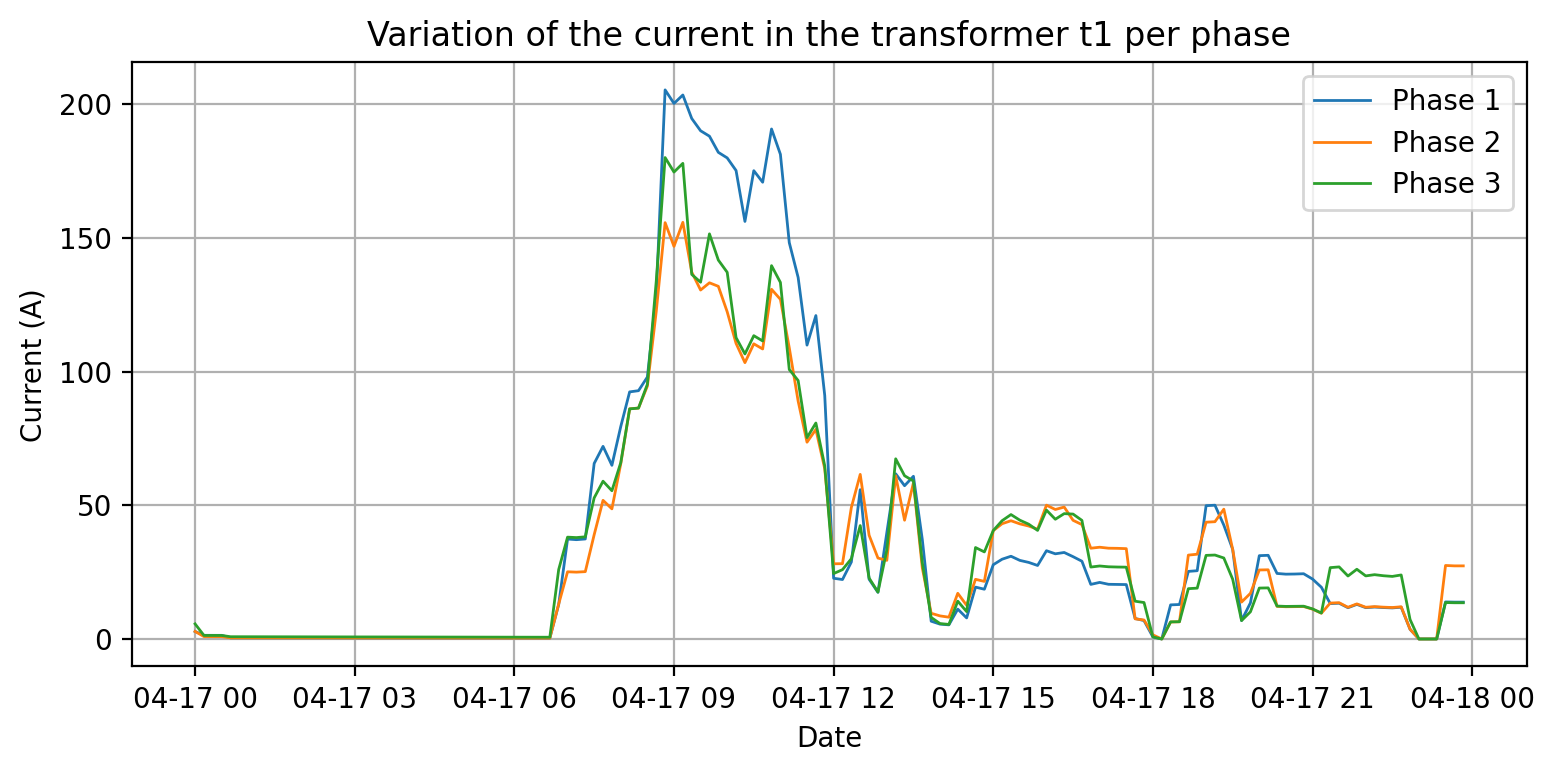

In [10]:
figure(figsize=(9, 4), dpi=200)
plt.plot(dates, result["P1 (kW)"][b:e] * 1000 / 120, linewidth=1, label = "Phase 1")
plt.plot(dates, result["P2 (kW)"][b:e] * 1000 / 120, linewidth=1, label = "Phase 2")
plt.plot(dates, result["P3 (kW)"][b:e] * 1000 / 120, linewidth=1, label = "Phase 3")
plt.xlabel("Date")
plt.ylabel("Current (A)")
plt.title("Variation of the current in the transformer t1 per phase")
plt.grid()
plt.legend()
plt.show()

### 2.6. Plotting the lines losses

There is five types of lines used in the ACN infrastructure. We would like to see the losses in each type of them, and the total losses. 

In [11]:
losses = pd.read_csv("Lines_losses.csv") #Loading the line losses from the csv file

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results

In [7]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

From (year/month/day/hour/minute):2019/04/17/00/00
To (year/month/day/hour/minute):2019/04/18/00/00


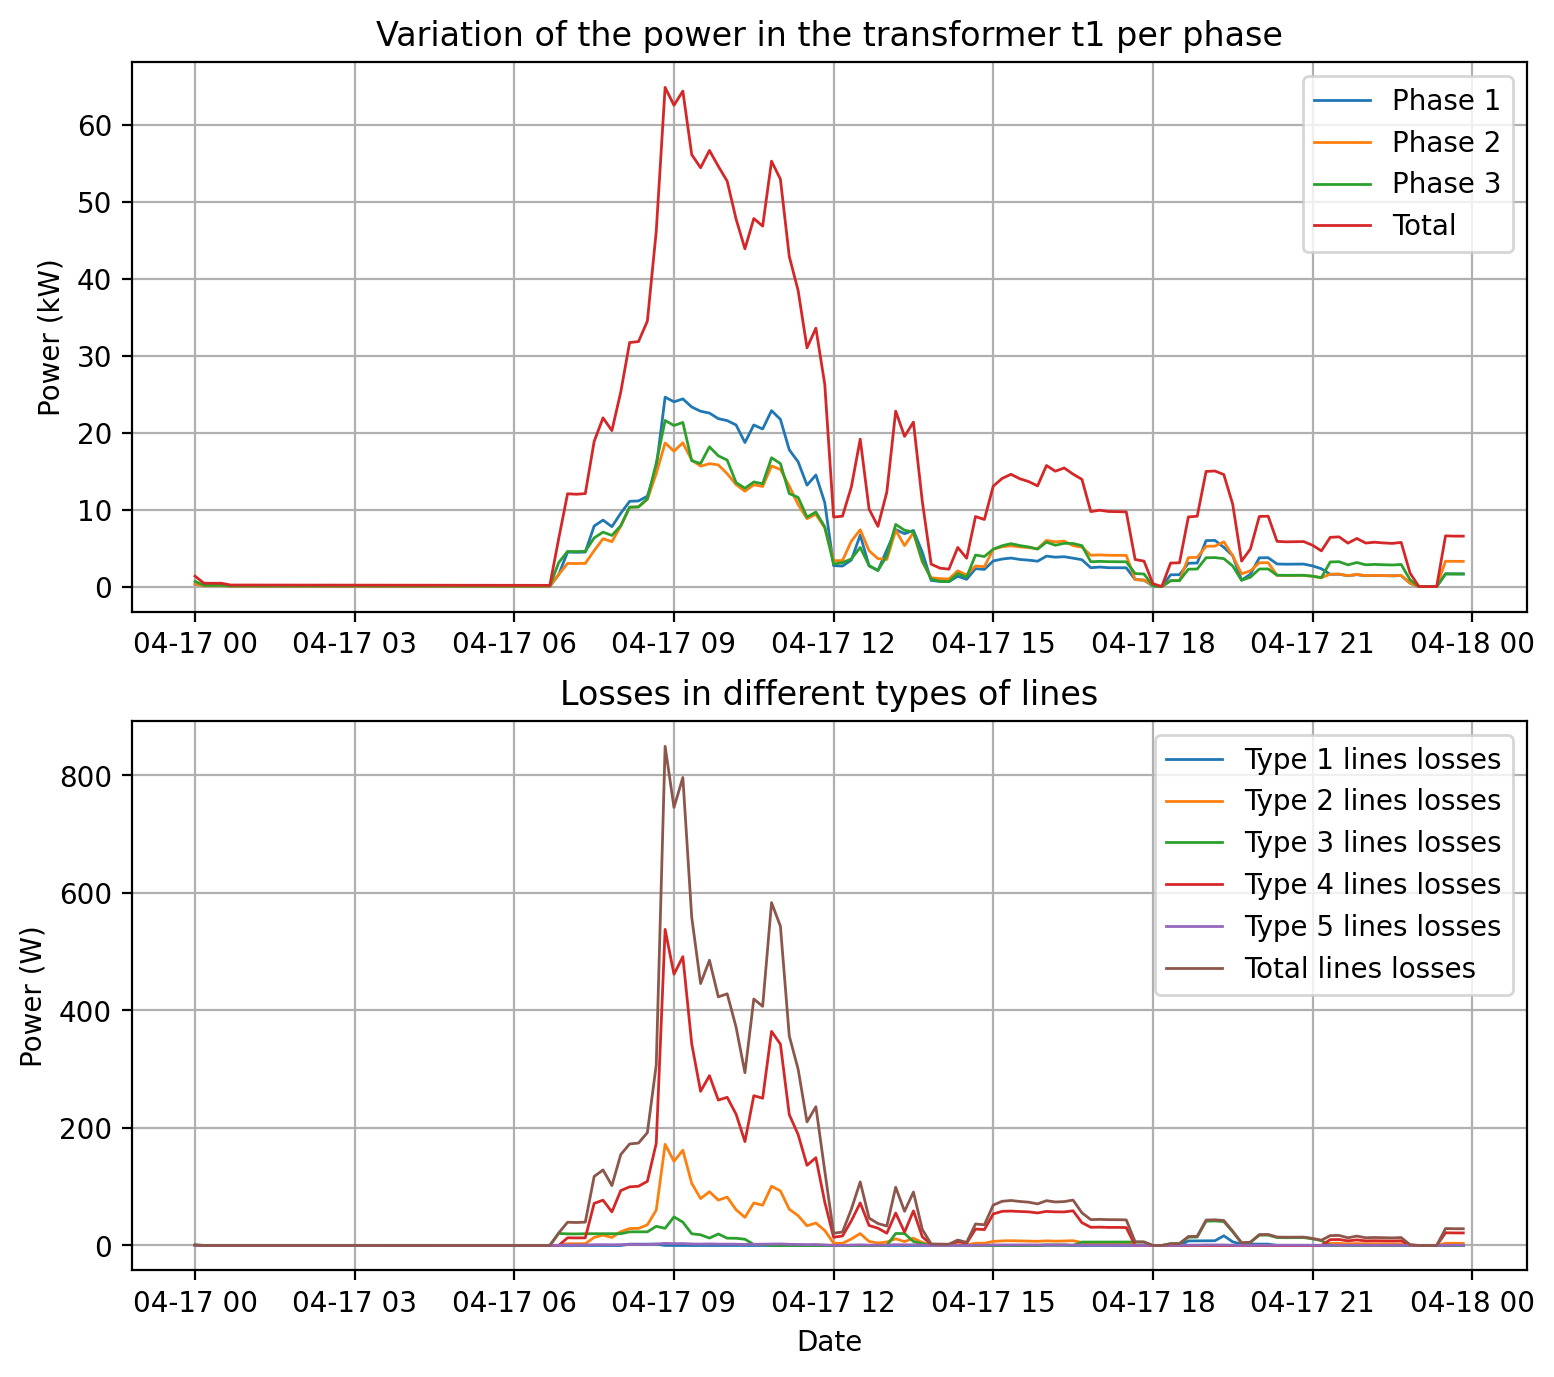

In [12]:
figure(figsize=(9, 8), dpi=200)
######################################################################################################
plt.subplot(2,1,2)
plt.plot(dates,losses["Type 1 lines losses (W)"][b:e], linewidth=1, label = "Type 1 lines losses")
plt.plot(dates,losses["Type 2 lines losses (W)"][b:e], linewidth=1, label = "Type 2 lines losses")
plt.plot(dates,losses["Type 3 lines losses (W)"][b:e], linewidth=1, label = "Type 3 lines losses")
plt.plot(dates,losses["Type 4 lines losses (W)"][b:e], linewidth=1, label = "Type 4 lines losses")
plt.plot(dates,losses["Type 5 lines losses (W)"][b:e], linewidth=1, label = "Type 5 lines losses")
plt.plot(dates,losses["Total lines losses (W)"][b:e], linewidth=1, label = "Total lines losses")
plt.xlabel("Date")
plt.ylabel("Power (W)")
plt.title("Losses in different types of lines")
plt.grid()
plt.legend()
######################################################################################################
plt.subplot(2,1,1)
plt.plot(dates, result["P1 (kW)"][b:e], linewidth=1, label = "Phase 1")
plt.plot(dates, result["P2 (kW)"][b:e], linewidth=1, label = "Phase 2")
plt.plot(dates, result["P3 (kW)"][b:e], linewidth=1, label = "Phase 3")
plt.plot(dates, result["P1 (kW)"][b:e] + result["P2 (kW)"][b:e] + result["P3 (kW)"][b:e], linewidth=1, label = "Total")
plt.ylabel("Power (kW)")
plt.title("Variation of the power in the transformer t1 per phase")
plt.grid()
plt.legend()
######################################################################################################
plt.show()

### 2.7. Plotting the Vrms

The rms value of the voltage is defined as follows:
$$V_{rms} = \sqrt{\frac{V^{2}_{a} + V^{2}_{b} + V^{2}_{c}}{3}}$$
Where:\
$V_{a}$: Line to neutral voltage of the phase one,\
$V_{b}$: Line to neutral voltage of the phase two,\
$V_{c}$: Line to neutral voltage of the phase three.

In [13]:
voltages = pd.read_csv("voltages.csv")

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results

In [6]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

From (year/month/day/hour/minute):2019/04/17/00/00
To (year/month/day/hour/minute):2019/04/18/00/00


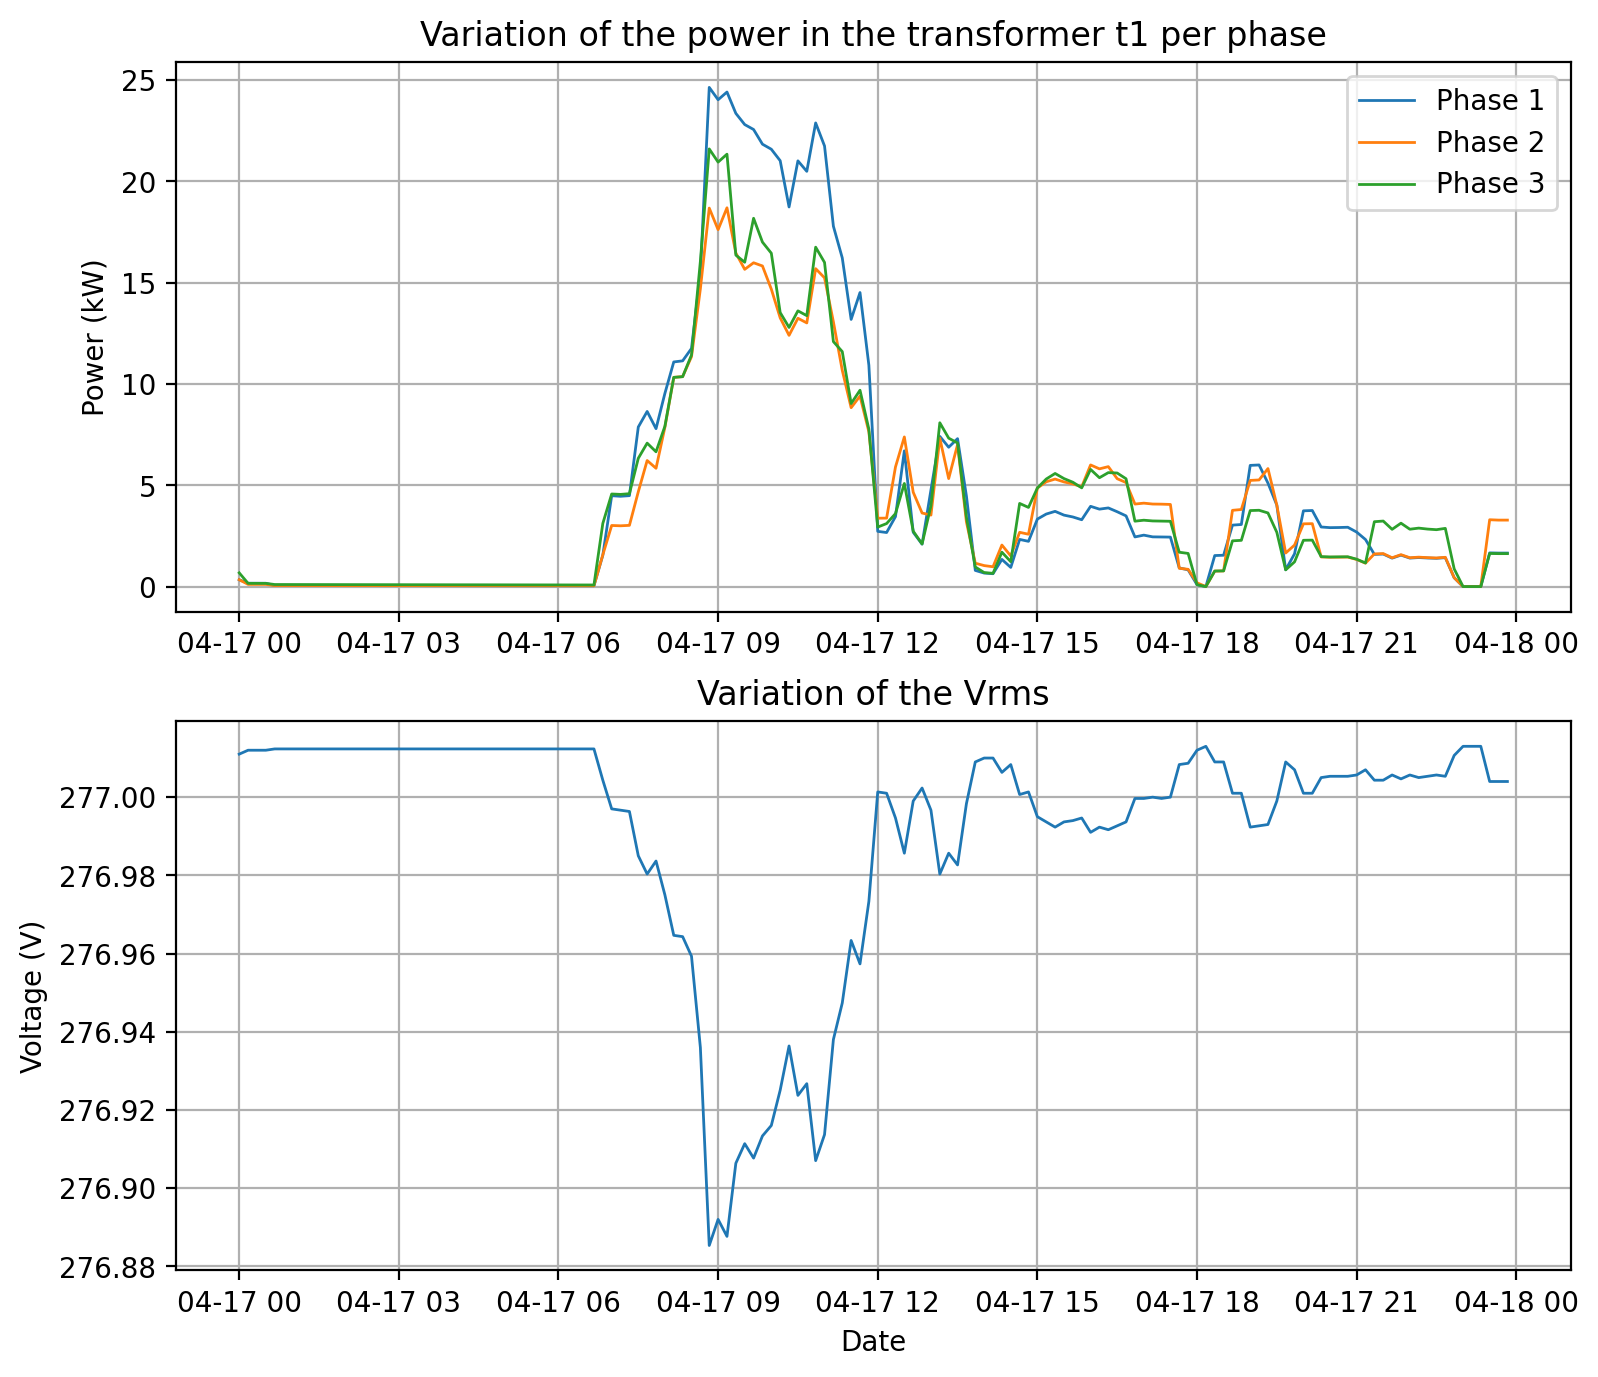

In [14]:
figure(figsize=(9, 8), dpi=200)
#######################################################################################################
plt.subplot(2,1,1)
plt.plot(dates, result["P1 (kW)"][b:e], linewidth=1, label = "Phase 1")
plt.plot(dates, result["P2 (kW)"][b:e], linewidth=1, label = "Phase 2")
plt.plot(dates, result["P3 (kW)"][b:e], linewidth=1, label = "Phase 3")
plt.ylabel("Power (kW)")
plt.title("Variation of the power in the transformer t1 per phase")
plt.grid()
plt.legend()
#######################################################################################################
plt.subplot(2,1,2)
plt.plot(dates, np.sqrt((voltages["V1 (V)"][b:e] ** 2 + voltages["V2 (V)"][b:e] ** 2 + voltages["V3 (V)"][b:e] ** 2) / 3), linewidth=1)
plt.xlabel("Date")
plt.ylabel("Voltage (V)")
plt.title("Variation of the Vrms")
plt.grid()
#######################################################################################################
plt.show()

### 2.8. Plotting the phase angle between voltage phases

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results

In [ ]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

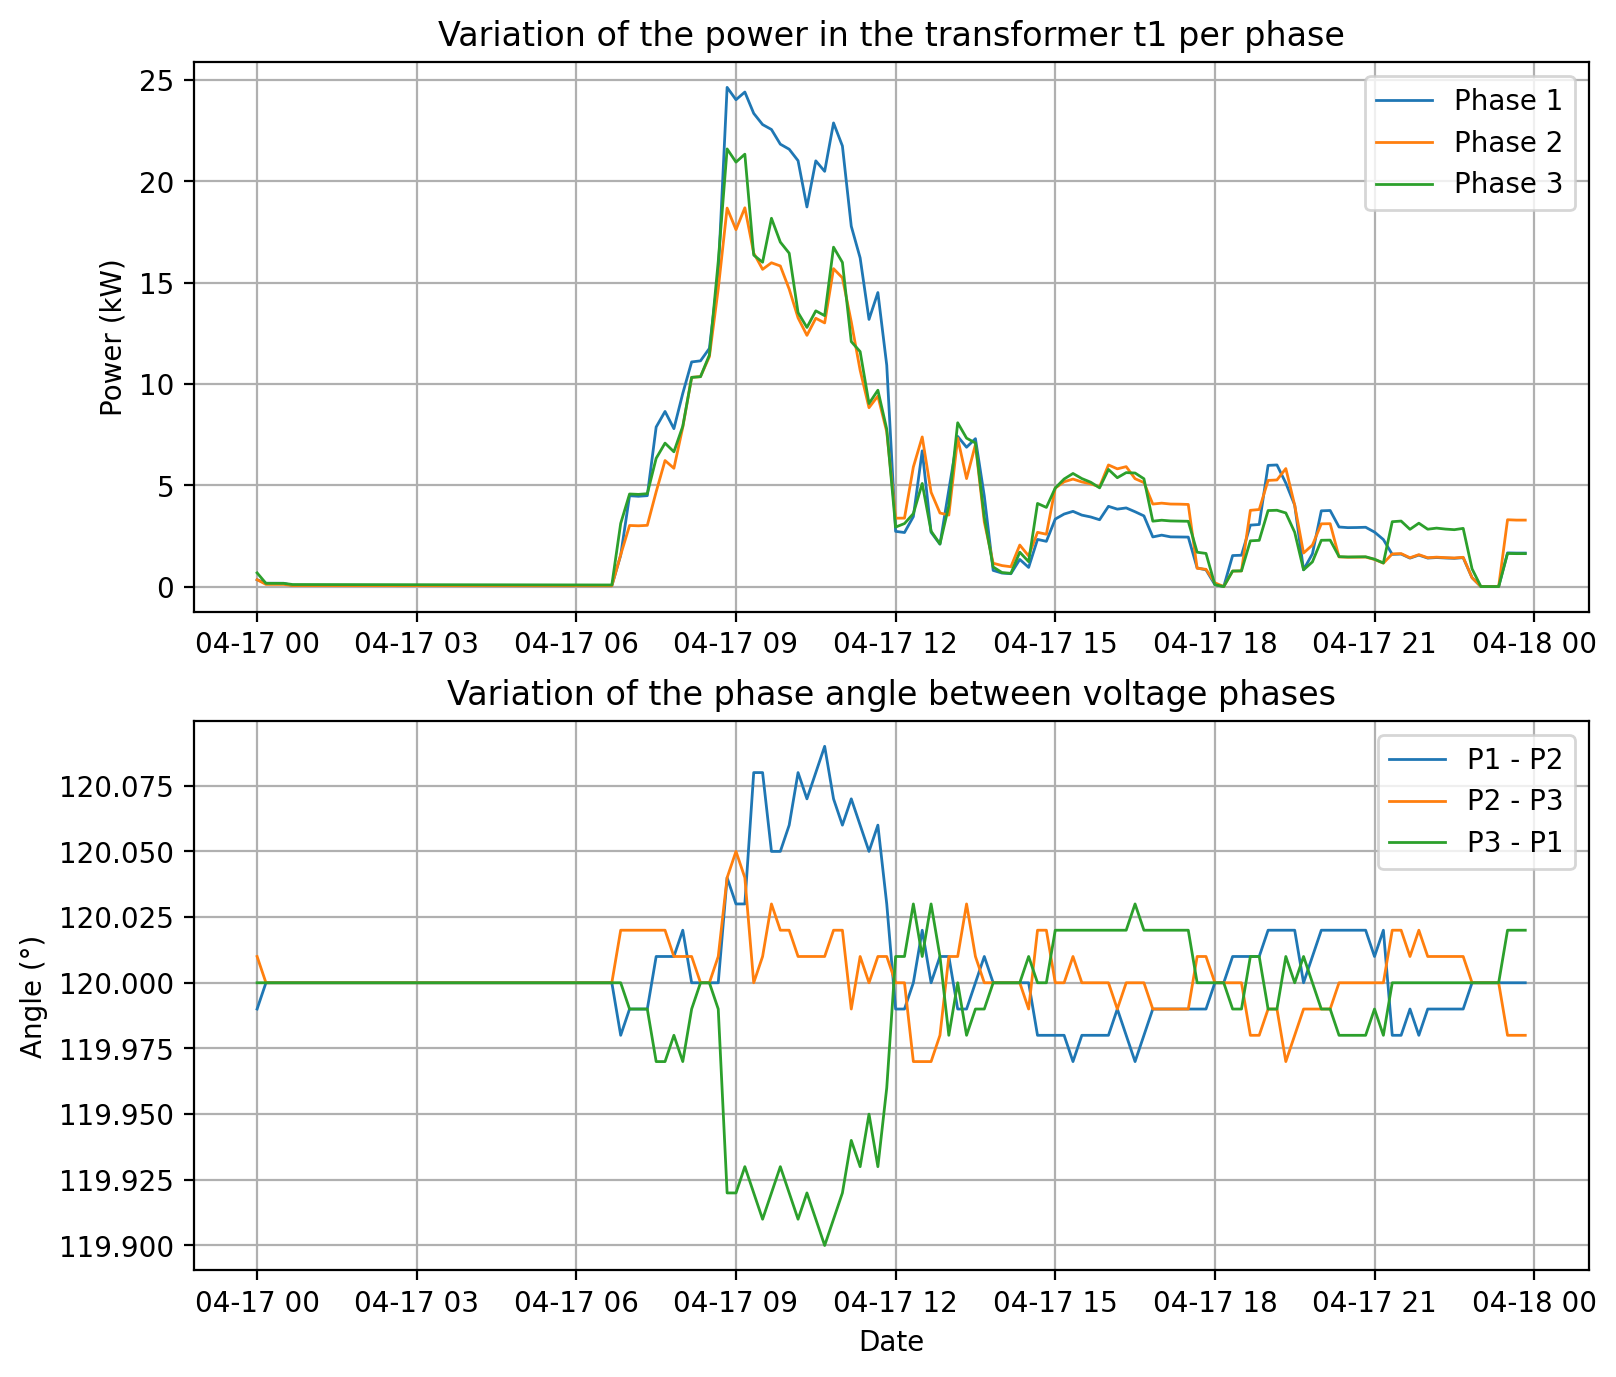

In [17]:
figure(figsize=(9, 8), dpi=200)
#######################################################################################################
plt.subplot(2,1,1)
plt.plot(dates, result["P1 (kW)"][b:e], linewidth=1, label = "Phase 1")
plt.plot(dates, result["P2 (kW)"][b:e], linewidth=1, label = "Phase 2")
plt.plot(dates, result["P3 (kW)"][b:e], linewidth=1, label = "Phase 3")
plt.ylabel("Power (kW)")
plt.title("Variation of the power in the transformer t1 per phase")
plt.grid()
plt.legend()
#######################################################################################################
plt.subplot(2,1,2)
plt.plot(dates, voltages["Ang2 (°)"][b:e] - voltages["Ang1 (°)"][b:e], linewidth=1, label = "P1 - P2")           
plt.plot(dates, 360 + voltages["Ang3 (°)"][b:e] - voltages["Ang2 (°)"][b:e], linewidth=1, label = "P2 - P3")           
plt.plot(dates, voltages["Ang1 (°)"][b:e] - voltages["Ang3 (°)"][b:e], linewidth=1, label = "P3 - P1")           
plt.xlabel("Date")
plt.ylabel("Angle (°)")
plt.title("Variation of the phase angle between voltage phases")
plt.grid()
plt.legend()
#######################################################################################################
plt.show()

### 2.9. Plotting the voltage unbalance factor (VUF)

The Voltage Unbalance Factor ($VUF$) is defined as follows:
$$VUF\ [\%] = \frac{{|\textbf{V}_{n}|}}{|\textbf{V}_{p}|} \times{100},$$
where$\ \textbf{V}_{p} = \frac{\textbf{V}_{a} + a \ . \textbf{V}_{b} + a^{2} \ . \textbf{V}_{c}}{3}$
: Positive sequence voltage phasors,\
$\ \ \ \ \ \ \ \ \ \ \textbf{V}_{n} = \frac{\textbf{V}_{a} + a^{2} \ . \textbf{V}_{b} + a \ . \textbf{V}_{c}}{3}$
: Negative sequence voltage phasors.\
and $\textbf{V}_{a} = V_{a} \ \angle \ \theta_{a}$
    : Line to neutral voltage phasor of the phase one,\
    $\ \ \ \ \ \ \ \textbf{V}_{b} = V_{b} \ \angle \ \theta_{a}$
    : Line to neutral voltage phasor of the phase two,\
    $\ \ \ \ \ \ \ \textbf{V}_{c} = V_{c} \ \angle \ \theta_{a}$ 
    : Line to neutral voltage phasor of the phase three.

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results

In [147]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

From (year/month/day/hour/minute):2019/04/17/00/00
To (year/month/day/hour/minute):2019/04/18/00/00


In [19]:
Va = np.zeros((e-b), dtype=complex)
Vb = np.zeros((e-b), dtype=complex)
Vc = np.zeros((e-b), dtype=complex)
for i in range(e-b):
    r1 = voltages["V1 (V)"][b+i]
    r2 = voltages["V2 (V)"][b+i]
    r3 = voltages["V3 (V)"][b+i]
    t1 = math.radians(voltages["Ang1 (°)"][b+i])
    t2 = math.radians(voltages["Ang2 (°)"][b+i])
    t3 = math.radians(voltages["Ang3 (°)"][b+i])
    Va[i] = complex(r1 * np.cos(t1), r1 * np.sin(t1))
    Vb[i] = complex(r2 * np.cos(t2), r2 * np.sin(t2))
    Vc[i] = complex(r3 * np.cos(t3), r3 * np.sin(t3))
a = np.array([complex(-0.5,np.sqrt(3)/2)])
Vp = (Va + a * Vb + a ** 2 * Vc) / 3
Vn = (Va + a ** 2 * Vb + a * Vc) / 3
VUF = np.absolute(Vn) / np.absolute(Vp) * 100

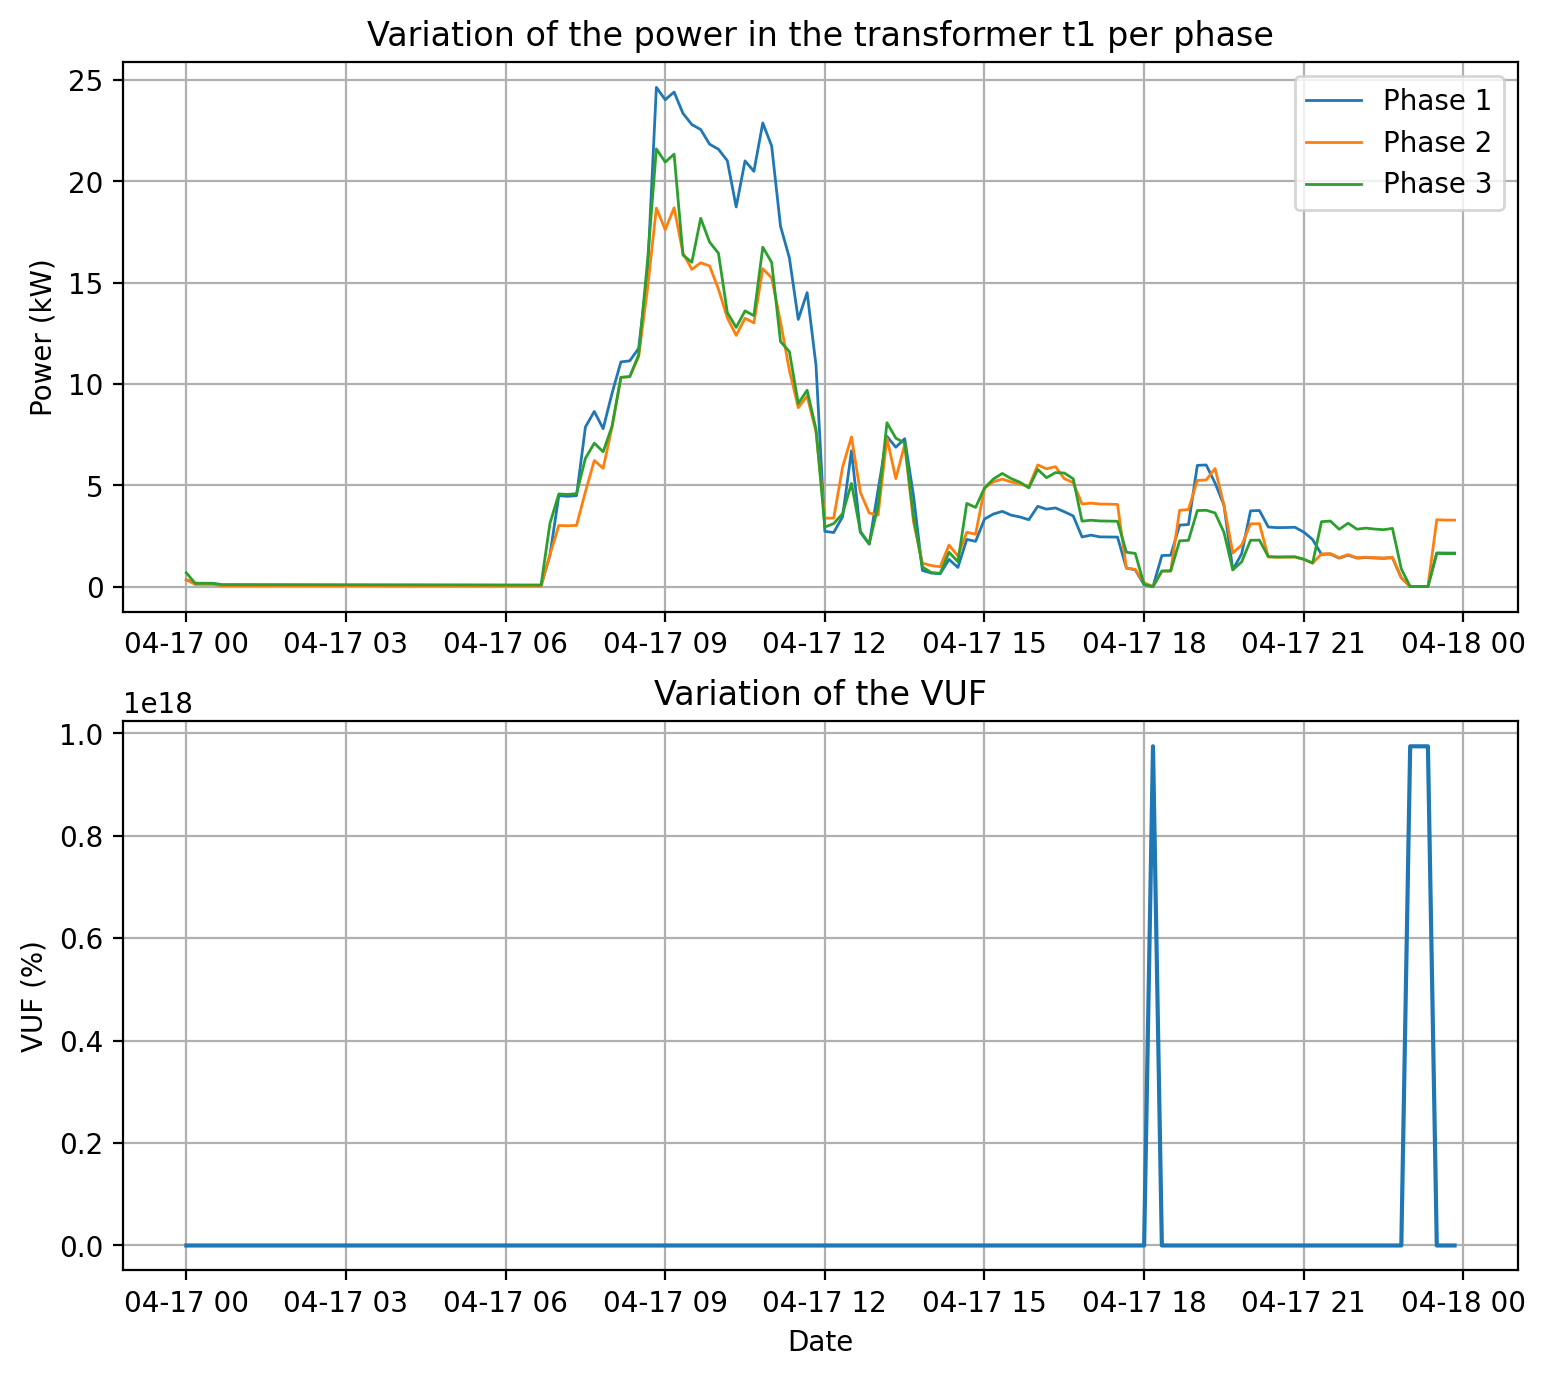

In [22]:
figure(figsize=(9, 8), dpi=200)
#######################################################################################################
plt.subplot(2,1,1)
plt.plot(dates, result["P1 (kW)"][b:e], linewidth=1, label = "Phase 1")
plt.plot(dates, result["P2 (kW)"][b:e], linewidth=1, label = "Phase 2")
plt.plot(dates, result["P3 (kW)"][b:e], linewidth=1, label = "Phase 3")
plt.ylabel("Power (kW)")
plt.title("Variation of the power in the transformer t1 per phase")
plt.grid()
plt.legend()
#######################################################################################################
plt.subplot(2,1,2)
plt.plot(dates, VUF, label="Vp")
plt.xlabel("Date")
plt.ylabel("VUF (%)")
plt.title("Variation of the VUF")
plt.grid()
#######################################################################################################
plt.show()

No handles with labels found to put in legend.


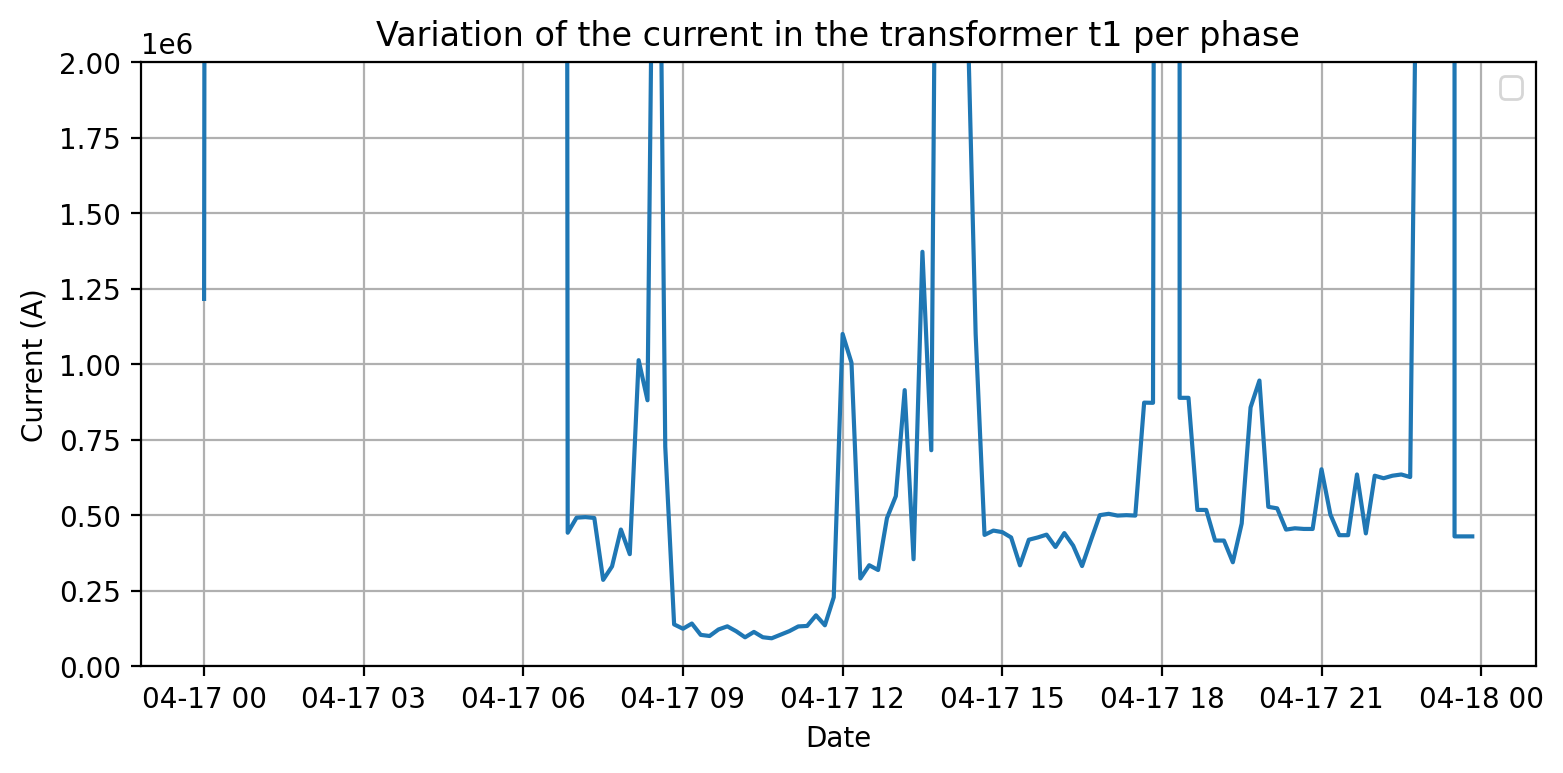

In [125]:
figure(figsize=(9, 4), dpi=200)
plt.plot(dates, VUF)
plt.xlabel("Date")
plt.ylim([0, 2000000])
plt.ylabel("Current (A)")
plt.title("Variation of the current in the transformer t1 per phase")
plt.grid()
plt.legend()
plt.show()

In [141]:
r1 = 277
r2 = 277
r3 = 277
ra = 1
t1 = math.radians(0)
t2 = math.radians(120)
t3 = math.radians(-120)
ta = math.radians(120)
Va = complex(r1 * math.cos(t1), r1 * math.sin(t1))
Vb = complex(r2 * math.cos(t2), r2 * math.sin(t2))
Vc = complex(r3 * math.cos(t3), r3 * math.sin(t3))
a = complex(ra * math.cos(ta), ra * math.sin(ta))
Vp = (Va + a * Vb + a ** 2 * Vc)/3
Vn = (Va + a ** 2 * Vb + a * Vc)/3
Vpm,_ = cmath.polar(Vp)
Vnm,_ = cmath.polar(Vn)
VUF = Vnm / Vpm * 100
print(VUF)

1.3075726453768842e+18


In [94]:
Va[i] = complex(r1 * np.cos(t1), r1 * np.sin(t1))

In [93]:
Va = np.zeros((e-b), dtype=complex)

In [35]:
n1 = np.array([1, 2, 3])

In [36]:
n2 = np.array([1, 2, 3])

In [71]:
n3 = np.zeros((e-b))

In [73]:
n3.shape

(144,)

In [68]:
n1 * a**2

array([-0.5-0.8660254j , -1. -1.73205081j, -1.5-2.59807621j])

In [77]:
r1 = np.array(voltages["V1 (V)"][b:e])
r2 = np.array(voltages["V2 (V)"][b:e])
r3 = np.array(voltages["V3 (V)"][b:e])
ra = 1
t1 = np.array(np.radians(voltages["Ang1 (°)"][b:e]))
t2 = np.array(np.radians(voltages["Ang2 (°)"][b:e]))
t3 = np.array(np.radians(voltages["Ang3 (°)"][b:e]))
ta = math.radians(120)
V1 = np.array(r1 * np.cos(t1) + r1 * np.sin(t1)j,dtype=np.complex_)
V3 = np.array(r2 * np.cos(t2) + r2 * np.sin(t2)j,dtype=np.complex_)
V2 = np.array(r3 * np.cos(t3) + r3 * np.sin(t3)j,dtype=np.complex_)
a = -0.5 + math.sqrt(3) / 2j
Vp = (V1 + a * V2 + a ** 2 * V3)/3
Vn = (V1 + a ** 2 * V2 + a * V3)/3
Vpm,_ = cmath.polar(Vp)
Vnm,_ = cmath.polar(Vn)
VUF = Vnm / Vpm * 100
print(VUF)

SyntaxError: invalid syntax (Temp/ipykernel_8324/2822922927.py, line 9)

In [54]:
r1 = np.array(voltages["V1 (V)"][b:e])

In [55]:
t1 = np.array(np.radians(voltages["Ang1 (°)"][b:e]))

In [69]:
float(r1[0]) * math.cos(float(t1[0])) + float(r1[0]) * math.sin(float(t1[0]))j

SyntaxError: invalid syntax (Temp/ipykernel_8324/2961838965.py, line 1)

In [70]:
type(float(r1[0]) * math.cos(float(t1[0])))

float

In [73]:
a = 1

In [74]:
b = 2

In [75]:
a + bj

NameError: name 'bj' is not defined

In [49]:
voltages["V1 (V)"][b+60]

276.844

In [50]:
voltages["V2 (V)"][b+60]

276.752

In [28]:
voltages["V3 (V)"][b+60]

277.154

In [29]:
voltages["Ang1 (°)"][b+60]

-0.26

In [30]:
voltages["Ang2 (°)"][b+60]

-120.18

In [31]:
voltages["Ang3 (°)"][b+60]

119.8

In [36]:
b

15264

In [45]:
result["P1 (kW)"][b] + result["P2 (kW)"][b] + result["P3 (kW)"][b]

1.354

In [41]:
data[file[3:9].lower()].iloc[b]

0    0.0
Name: 15264, dtype: float64

In [42]:
s = 0
for file in file_list:
    s = s + data[file[3:9].lower()].iloc[b]

In [43]:
print(s)

0    1352.0
Name: 15264, dtype: float64
